# Paper Figures

Mostly every figure in the paper was generated here and uses the data calculated in the previous notebooks (including the angle misalignment measurements from Michelle Jecmen's SpinAngle.ipynb),

In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
from os.path import exists 
from scipy import stats

import pandas as pd
from scipy.spatial.transform import Rotation as Rota
from tqdm import tqdm
from scipy.interpolate import CubicSpline

import sys
sys.path.append('/home/tnguser/python/')
from FigureRotation_util import *
from Cannon_get_principal_axes import *
from prob_plane_method import *

from matplotlib import rcParams
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")
plt.style.use('mplstyle.txt')
import matplotlib.gridspec as gridspec
%matplotlib inline
rcParams['font.size'] = 10

sim = 'L35n2160TNG'
basePath = '/home/tnguser/sims.TNG/' + sim + '/output'

# Halos in Neil Ash's catalog
catalogue_path = '/home/tnguser/postprocessing/halocatalogues/' + sim + '.npy'
naive_halos = np.load(catalogue_path)
main_subhalos = np.load('/home/tnguser/postprocessing/halocatalogues/' + sim + '_mainSubhalos.npy') 

# CHANGE TO DESIRED FILE PATHS
anglePath = '/home/tnguser/postprocessing/angles/' + sim + '/half_mass_rad/'
principal_path =  '/home/tnguser/postprocessing/principal_axes/' + sim + '/00_06Rvir/'
spin_suffix = '/home/tnguser/postprocessing/angular_momentum/' + sim + '/inner_disk/'
angle_std_path = '/home/tnguser/postprocessing/uncertainties/angles/'
neil_angle_std_path = '/home/tnguser/postprocessing/uncertainties/neil_angles/'
warp_angle_path = '/home/tnguser/postprocessing/angles/' + sim + '/warp_angles/'
warp_angle_std_path = '/home/tnguser/postprocessing/uncertainties/warp_angles/'

snap = 99
startSnap = 75

ModuleNotFoundError: No module named 'illustris_python'

Helper functions

In [2]:
def getAngles(v):
    """
    Returns the Brigg's angles in form [polar angle, azmuthal angle]
    """
    polar_angle = angleBtwn(v,[0,0,1])
    xy_angle = np.sign(v[1])*np.arccos(v[0]/np.sqrt(v[0]**2+v[1]**2))
    return [polar_angle, xy_angle]

def angleBtwn(u,v):
    """
    Returns angle between vectors u and v
    """
    u = np.array(u)
    v= np.array(v)
    u = 1/np.sqrt(np.sum(u**2))*u
    v = 1/np.sqrt(np.sum(v**2))*v

    return np.arccos(np.dot(u,v))

def flatten(xs):
    res = []
    def loop(ys):
        for i in ys:
            if isinstance(i, list):
                loop(i)
            else:
                res.append(i)
    loop(xs)
    return res

import math
def truncate(number, digits) -> float:
    # Improve accuracy with floating point operations, to avoid truncate(16.4, 2) = 16.39 or truncate(-1.13, 2) = -1.12
    nbDecimals = len(str(number).split('.')[1]) 
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

In [3]:
#This is from Neil as well, allows us to make the unified polar plots
def orient(E,E_ref=np.eye(3),assert_on=True):
    """
    Enforces E to be a RHS, then attempts rotations by 180 deg about each axis until
    the angles with respect to E_ref are minimized. If any of these cannot be reduced beyond 90 deg,
    throw error
    """

    # Enforce RHS
    RHS = np.dot(np.cross(E[:,0],E[:,1]),E[:,2]) > 0
    if not RHS: E[:,0] = E[:,0]*-1

    # Begin iteration
    # Check base orientation first
    rotations = [[ 1, 1, 1],
                 [-1,-1, 1],
                 [ 1,-1,-1],
                 [-1, 1,-1]]

    angles = []
    for rot in rotations:
        E_rot = E * rot

        # Check angles between E, E_ref
        angles.append(np.arccos(np.diagonal(E_rot.T.dot(E_ref))))

    # Find the rotation which gives us the smallest square error from E_ref
    angles = np.array(angles)
    mean_sqr_dev = np.mean(angles**2,axis=1)

    min_ind = np.argmin(mean_sqr_dev)
    E_new = E*rotations[min_ind]

    # Verify none of the angles on this surpass 90 deg
    #print(angles[min_ind]*180/np.pi)
    if assert_on:
        assert np.all(angles[min_ind]<np.pi/2)

    return E_new

def RotateForPolarPlot(disk_spin_axes,halo_principal_axes,
                       close_to_unit_thresh=1e-4,useMajorAxis=False):
    """
    A function to take the orientations of the disk spin axes and 
    halo minor axes and perform the rotation for plotting on polar 
    plots. The same rotation is applied to both sets of axes, such 
    that they are kept in the same frame. 
    
    Additionally, the orientation of the disk spin axis in the halo 
    body frame is returned
    
    Inputs:
            disk_spin_axes: (N,3), representing the orientation of 
                                    the inner disk
            
            halo_principal_axes: (N,3,3), the principal axes of the 
                                            halo at all snapshots
            
    Outputs:
            
            disk_theta_phi: (N,2), angular coordinates of the disk 
                                    spin axis, to be used for plotting
            
            halo_theta_phi: (N,2), angular coordinates of the halo minor 
                                    axis, to be used for plotting
            
            disk_theta_phi_in_halo_body_frame: (N,2), angular coordinates 
                                    of the disk spin axis in the halo
    
    """
    ##################################################
    #### Preprocessing block                      ####
    ##################################################
    
    # First, check input shapes
    N = len(disk_spin_axes)
    
    assert N==len(halo_principal_axes), "Length of inputs must be equal"
    assert disk_spin_axes.shape==(N,3), "Disk spin axes must have shape (N,3), but found "+str(disk_spin_axes.shape)
    assert halo_principal_axes.shape==(N,3,3), "Halo principal axes must have shape (N,3,3), but found "+str(halo_principal_axes.shape)
    
    # Second, do some checks on the axes
    
    # Are all spin axes unit vectors?
    spin_mag = np.sqrt(np.sum(disk_spin_axes**2,axis=1))
    assert all(abs(spin_mag-1)<close_to_unit_thresh), "Disk spin axes are not unit length"
    
    # Are the principal axes all RHS and unit vectors?
    halo_PA_det = np.linalg.det(halo_principal_axes)
    assert all(halo_PA_det>0), "Principal axes must make up a RHS"
    
    # Are all the principal axes unit length?
    assert all(abs(halo_PA_det-1)<close_to_unit_thresh), "Principal axes must be mutually orthogonal unit vectors"
    
    # Check that all the principal axes have been oriented correctly
    halo_PA_orient = [halo_principal_axes[0]]
    for j in range(1,N):
        halo_PA_orient.append(orient(halo_principal_axes[j],E_ref=halo_PA_orient[j-1]))
    halo_PA_orient = np.array(halo_PA_orient)
    
    # Check that the halo minor axis is not opposite the disk spin axis
    # If it is, flip minor and intermediate axes
    if useMajorAxis:
        halo_minor_axes = halo_PA_orient[:,:,2]
    else:
        halo_minor_axes = halo_PA_orient[:,:,2]
    
    dot_prod = np.sum(halo_minor_axes*disk_spin_axes,axis=1)
    if np.mean(dot_prod)<0:
        halo_PA_orient *= np.array([1,-1,-1]).reshape((1,1,3))
        
    ##################################################
    #### Frame def block                          ####
    ##################################################
    
    # Define the rotation matrix
    # First, compute the covariance matrix of the stellar spin axes
    covMat = disk_spin_axes.T.dot(disk_spin_axes)
    
    # eigen decompose the covariance matrix
    val,vec = np.linalg.eig(covMat)
    
    # Rearrange by variance, so that the z axis is the first eigenvector,
    # x axis the second eigenvector, and y axis the third
    sortInds = np.argsort(val)
    #sortInds[1:] = sortInds[1:][::-1]
    
    vec = vec[:,[sortInds[1],sortInds[0],sortInds[2]]]
    
    # Check that the first eigenvector is mostly aligned with 
    # the stellar spin axes
    if np.mean(np.sum(vec[:,2]*disk_spin_axes,axis=1))<0:
        vec[:,2] *= -1
        
    # Check that the eigenvectors form a RHS, correct if not
    if np.linalg.det(vec)<0:
        vec = vec*np.array([-1,-1,1])
        
    # Finally, define the rotation matrix
    R = vec.T
    
    ##################################################
    #### Coordinate transform block               ####
    ##################################################
    
    # First the disk spin axes
    disk_rot = R.dot(disk_spin_axes.T).T
    
    theta = np.arccos(disk_rot[:,2])
    phi = np.arctan2(disk_rot[:,1],disk_rot[:,0])
    
    disk_theta_phi = np.array([theta,phi])
    
    # Next halo minor axes
    if useMajorAxis:
        halo_minor_axes = halo_PA_orient[:,:,0]
    else:
        halo_minor_axes = halo_PA_orient[:,:,2]
    halo_rot = R.dot(halo_minor_axes.T).T
    
    theta = np.arccos(halo_rot[:,2])
    phi = np.arctan2(halo_rot[:,1],halo_rot[:,0])
    
    halo_theta_phi = np.array([theta,phi])
    
    # Finally, output the disk spin axis orientation in 
    # the halo body frame
    
    disk_in_body_frame = np.array([halo_PA_orient[i].T.dot(disk_spin_axes[i]) for i in range(N)])
    
    theta = np.arccos(disk_in_body_frame[:,2])
    phi = np.arctan2(disk_in_body_frame[:,1],disk_in_body_frame[:,0])
    
    disk_theta_phi_in_halo_body_frame = np.array([theta,phi])
    
    # output
    
    return disk_theta_phi, halo_theta_phi, disk_theta_phi_in_halo_body_frame

## Polar plot generating functions

In [4]:
def get_body_briggs(GrNr, subfindID, flip):
    #Loads polar plot evolution coordinates given GrNr and SubfindID of halo
    principal_file = principal_path + 'GrNr_%d_snap_%d_99_principal_axes_full.npy'%(GrNr,75)
    spin_file = spin_suffix + 'GrNr_%d_snap_%d_99_lambda_prime_baryons_stars.npy'%(GrNr,75)

    # MAKING SURE HALO EXISTS
    if exists(principal_file):
        
        principal_axes = np.load(principal_file,allow_pickle=True)
        spins = np.load(spin_file,allow_pickle=True)

        L_body_theta = RotateForPolarPlot(spins,principal_axes,close_to_unit_thresh=1e-4,useMajorAxis=False)[2][0]
        L_body_phi = RotateForPolarPlot(spins,principal_axes,close_to_unit_thresh=1e-4,useMajorAxis=False)[2][1]
        
    return L_body_theta, L_body_phi

In [5]:
def get_z_briggs(GrNr, subfindID, flip):
    principal_file = principal_path + 'GrNr_%d_snap_%d_99_principal_axes_full.npy'%(GrNr,75)
    spin_file = spin_suffix + 'GrNr_%d_snap_%d_99_lambda_prime_baryons_stars.npy'%(GrNr,75)

    # MAKE SURE HALO EXISTS
    theta = []; phi = []
    if exists(principal_file):
        
        principal_axes = np.load(principal_file,allow_pickle=True)
        spins = np.load(spin_file,allow_pickle=True)
        
        for snap in range(25):

            z_0 = principal_axes[0][2]
            z_0_new = 1/np.sqrt(np.sum(z_0**2))*z_0
            # Finds transformation matrix that rotates halo minor axis to align with z-axis, tries to align
            z = [[0, 0, 1], [1, 0, 0]]
            rot, rssd, sens = Rota.align_vectors(z, [z_0_new, [1,0,0]], return_sensitivity=True, weights=[100, .1])
            z_0_new = (rot.apply(z_0_new))

            z_bf = principal_axes[snap][2]
            z_new = (rot.apply(z_bf)) # Then applies new rotation 
            z_new = 1/np.sqrt(np.sum(z_new**2))*z_new

            # Theta (polar angle): angle between fiducial z-axis (figure rotation axis)
            # Phi (azimuthal angle): angle between projection onto xy-plane and x-axis (near halo major axis)
            t,p = getAngles(z_new)
            theta.append(t)
            phi.append(p)

    return theta, phi

In [6]:
def get_x_briggs(GrNr, subfindID, flip):
    principal_file = principal_path + 'GrNr_%d_snap_%d_99_principal_axes_full.npy'%(GrNr,75)
    spin_file = spin_suffix + 'GrNr_%d_snap_%d_99_lambda_prime_baryons_stars.npy'%(GrNr,75)

    # MAKE SURE HALO EXISTS
    theta = []; phi = []
    if exists(principal_file):
        
        principal_axes = np.load(principal_file,allow_pickle=True)
        spins = np.load(spin_file,allow_pickle=True)
        
        for snap in range(25):

            z_0 = principal_axes[0][0]
            z_0_new = 1/np.sqrt(np.sum(z_0**2))*z_0
            # Finds transformation matrix that rotates halo minor axis to align with z-axis, tries to align
            z = [[0, 0, 1], [1, 0, 0]]
            rot, rssd, sens = Rota.align_vectors(z, [z_0_new, [1,0,0]], return_sensitivity=True, weights=[100, .1])
            z_0_new = (rot.apply(z_0_new))

            z_bf = principal_axes[snap][0]
            z_new = (rot.apply(z_bf)) # Then applies new rotation 
            z_new = 1/np.sqrt(np.sum(z_new**2))*z_new

            # Theta (polar angle): angle between fiducial z-axis (figure rotation axis)
            # Phi (azimuthal angle): angle between projection onto xy-plane and x-axis (near halo major axis)
            t,p = getAngles(z_new)
            theta.append(t)
            phi.append(p)

    return theta, phi

In [7]:
def get_minor_briggs(GrNr, subfindID, flip):
    #Loads polar plot evolution coordinates given GrNr and SubfindID of halo
    principal_file = principal_path + 'GrNr_%d_snap_%d_99_principal_axes_full.npy'%(GrNr,75)
    spin_file = spin_suffix + 'GrNr_%d_snap_%d_99_lambda_prime_baryons_stars.npy'%(GrNr,75)

    # MAKING SURE HALO EXISTS
    if exists(principal_file):
        
        principal_axes = np.load(principal_file,allow_pickle=True)
        spins = np.load(spin_file,allow_pickle=True)

        L_theta = RotateForPolarPlot(spins,principal_axes,close_to_unit_thresh=1e-4,useMajorAxis=False)[0][0]
        L_phi = RotateForPolarPlot(spins,principal_axes,close_to_unit_thresh=1e-4,useMajorAxis=False)[0][1]
        z_theta = RotateForPolarPlot(spins,principal_axes,close_to_unit_thresh=1e-4,useMajorAxis=False)[1][0]
        z_phi = RotateForPolarPlot(spins,principal_axes,close_to_unit_thresh=1e-4,useMajorAxis=False)[1][1]
        
    return L_theta, L_phi, z_theta, z_phi

In [8]:
def get_major_briggs(GrNr, subfindID, flip):
    #Loads polar plot evolution coordinates given GrNr and SubfindID of halo
    principal_file = principal_path + 'GrNr_%d_snap_%d_99_principal_axes_full.npy'%(GrNr,75)
    spin_file = spin_suffix + 'GrNr_%d_snap_%d_99_lambda_prime_baryons_stars.npy'%(GrNr,75)

    # MAKING SURE HALO EXISTS
    if exists(principal_file):
        
        principal_axes = np.load(principal_file,allow_pickle=True)
        spins = np.load(spin_file,allow_pickle=True)

        L_theta = RotateForPolarPlot(spins,principal_axes,close_to_unit_thresh=1e-4,useMajorAxis=True)[0][0]
        L_phi = RotateForPolarPlot(spins,principal_axes,close_to_unit_thresh=1e-4,useMajorAxis=True)[0][1]
        z_theta = RotateForPolarPlot(spins,principal_axes,close_to_unit_thresh=1e-4,useMajorAxis=True)[1][0]
        z_phi = RotateForPolarPlot(spins,principal_axes,close_to_unit_thresh=1e-4,useMajorAxis=True)[1][1]
        
    return L_theta, L_phi, z_theta, z_phi

In [9]:
lookback_time = [3.966,3.269,2.48,1.66,0.81,0]
colorbar_lookback = [3.966,3.269,2.48,1.66,0.81]
snapshot_times = [3.966,3.794,3.621,3.504,3.269,3.149,2.969,2.787,2.665,2.480,2.294,2.169,1.979,1.852,1.660,1.466,1.336,1.140,1.008,0.810,0.676,0.475,0.340,0.136,0]

## Load quantities

In [10]:
final_diskyIDs = np.load('/home/tnguser/postprocessing/circularity_study/real_final_diskyIDs.npy')

In [11]:
final_GrNr = np.load('/home/tnguser/postprocessing/real_final_diskyGrNr.npy')

In [12]:
z_angles = []
x_angles = []
warp_angles = []
tau_angles = []
gas_angles = []

for subfindID in (final_diskyIDs):
    GrNr = il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr']
    z_file = anglePath + 'GrNr_%d_snap_%d_99_RaxisLaxis_z_angle.npy'%(GrNr,startSnap)
    x_file = anglePath + 'GrNr_%d_snap_%d_99_RaxisLaxis_x_angle.npy'%(GrNr,startSnap)
    warp_angle_file = warp_angle_path+'GrNr_%d_snap_%d_99_warp_z_angles.npy'%(GrNr,75)
    tau_file = anglePath + 'GrNr_%d_snap_%d_99_torque_angle.npy'%(GrNr,startSnap)
    gas_file = anglePath + 'GrNr_%d_snap_%d_99_LGaxisL*axis_angle.npy'%(GrNr,startSnap)
    if exists(z_file) and exists(x_file) and exists(warp_angle_file):
        z_angles.append(np.load(z_file,allow_pickle=True))
        x_angles.append(np.load(x_file,allow_pickle=True))
        warp_angles.append(np.load(warp_angle_file,allow_pickle=True))
        tau_angles.append(np.load(tau_file,allow_pickle=True))
        gas_angles.append(np.load(gas_file,allow_pickle=True))

In [13]:
z_angles = np.array(z_angles)
x_angles = np.array(x_angles)
warp_angles = np.array(warp_angles)
tau_angles = np.array(tau_angles)
gas_angles = np.array(gas_angles)

In [14]:
warp_angles_stds = []
z_angles_stds = []
x_angles_stds = []
disk_theta_stds = []
disk_phi_stds = []
gas_angles_stds = []

N = []
c_a =[]
b_a = []

for subfindID in final_diskyIDs:
    GrNr = il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr']
    warp_std_file = warp_angle_std_path + 'GrNr_%d_snap_%d_99_warp_angle_std.npy'%(GrNr,startSnap)
    gas_std_file = angle_std_path + 'GrNr_%d_snap_%d_99_LGaxisL*axis_angle_std.npy'%(GrNr,75)
    z_std_file = angle_std_path + 'GrNr_%d_snap_%d_99_RaxisLaxis_z_angle_std.npy'%(GrNr,startSnap)
    x_std_file = angle_std_path + 'GrNr_%d_snap_%d_99_RaxisLaxis_x_angle_std.npy'%(GrNr,startSnap)
    disk_theta_std_file = neil_angle_std_path + 'GrNr_%d_snap_%d_99_body_lambda_theta_std.npy'%(GrNr,startSnap)
    disk_phi_std_file = neil_angle_std_path + 'GrNr_%d_snap_%d_99_body_lambda_phi_std.npy'%(GrNr,startSnap)
    N_file = principal_path + 'GrNr_%d_snap_75_99_Npart.npy'%(GrNr)
    ratio_file = principal_path + 'GrNr_%d_snap_75_99_axisRatios_full.npy'%(GrNr)

    if exists (gas_std_file) and exists(z_std_file) and exists(x_std_file) and exists(disk_theta_std_file) and exists(disk_phi_std_file) and exists(warp_std_file) and exists(N_file) and exists(ratio_file):
        warp_angles_stds.append(np.load(warp_std_file,allow_pickle=True)) 
        gas_angles_stds.append(np.load(gas_std_file,allow_pickle=True))
        z_angles_stds.append(np.load(z_std_file,allow_pickle=True))  
        x_angles_stds.append(np.load(x_std_file,allow_pickle=True))  
        disk_theta_stds.append(np.load(disk_theta_std_file,allow_pickle=True))  
        disk_phi_stds.append(np.load(disk_phi_std_file,allow_pickle=True)) 
        N.append(np.load(N_file,allow_pickle=True))
        b_a.append(np.load(ratio_file,allow_pickle=True)[:,0])
        c_a.append(np.load(ratio_file,allow_pickle=True)[:,1])
        
z_angles_stds = np.array(z_angles_stds)
x_angles_stds = np.array(x_angles_stds)
warp_angles_stds = np.array(warp_angles_stds)

## Quantitative correlation attempts

Before we load in and consider all of the uncertainty estimates involved, we can look at some attempts to directly correlate figure rotation measurements and some other misalignment measurements with warp. Since these are not extremely relevant to the paper's argument (only a couple of these are in the appendix to talk about why we're not directly correlating anything), I think it's fair to ignore the uncertainties. The first thing we need to do is load up our "good rotation dictionary" below, which specifies the galaxies in our sample of 82 galaxies that have both figure rotation products calculated as well as pass Neil's chi^2 and unphysical pattern speed cuts. It contains which snapshot range specifically pass these cuts, which has made it tricky to work with these quantites as we have to disregard ranges of snapshots in the measurements we have just loaded in.

In [15]:
good_rotation_dict = np.load('/home/tnguser/Saarthak_catalogue_good_FR_selected.npy',allow_pickle=True).item()

In [16]:
FR_GrNr = []
for GrNr in final_GrNr:
    angle_file = anglePath +'GrNr_%d_snap_%d_99_RaxisLaxis_L_angle.npy'%(GrNr,startSnap)
    warp_angle_file = warp_angle_path+'GrNr_%d_snap_%d_99_warp_z_angles.npy'%(GrNr,75)
    if exists(warp_angle_file) and exists(angle_file):
        FR_GrNr.append(GrNr)

100%|██████████| 40/40 [00:00<00:00, 177.25it/s]


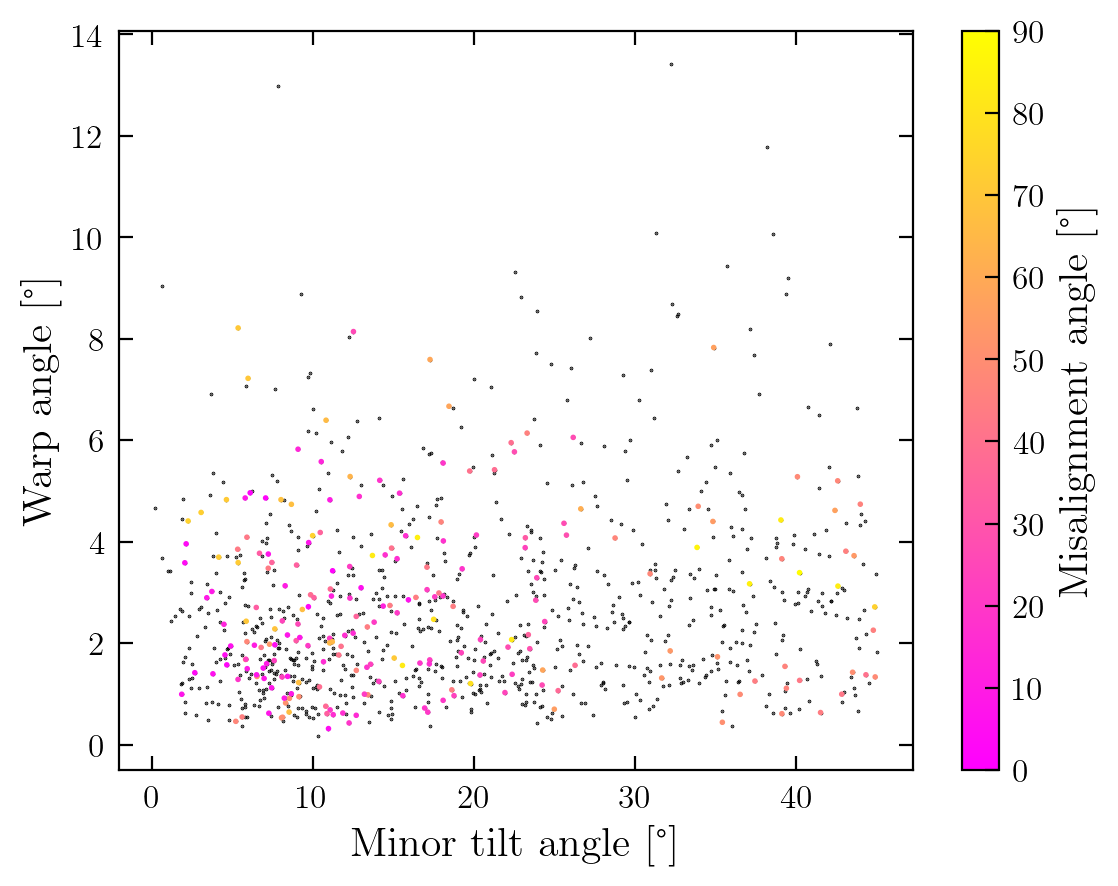

In [17]:
plt.scatter(np.array(tau_angles), np.array(warp_angles), s=.1, c='black')
for GrNr in tqdm(final_GrNr):    
    angle_file = anglePath +'GrNr_%d_snap_%d_99_RaxisLaxis_L_angle.npy'%(GrNr,startSnap)
    z_file = anglePath + 'GrNr_%d_snap_%d_99_torque_angle.npy'%(GrNr,startSnap)
    warp_angle_file = warp_angle_path+'GrNr_%d_snap_%d_99_warp_z_angles.npy'%(GrNr,75)
    
    if exists(z_file) and exists(warp_angle_file) and exists(angle_file):
        z_angle = np.load(z_file,allow_pickle=True)
        warp_angle = np.load(warp_angle_file,allow_pickle=True)
        disky_angle = np.load(angle_file,allow_pickle=True)
        for interval in range(len(good_rotation_dict[GrNr]['startStop'])):
            snap_0 = good_rotation_dict[GrNr]['startStop'][interval][0]
            snap_min = good_rotation_dict[GrNr]['startStop'][interval][-1]
            plt.scatter(z_angle[snap_0:snap_min], warp_angle[snap_0:snap_min], c=disky_angle[snap_0:snap_min],s=1, vmin=0, vmax=90, cmap='spring')
plt.xlabel('Minor tilt angle [°]')
plt.ylabel('Warp angle [°]')
plt.colorbar(label='Misalignment angle [°]')

100%|██████████| 32/32 [00:00<00:00, 323.66it/s]


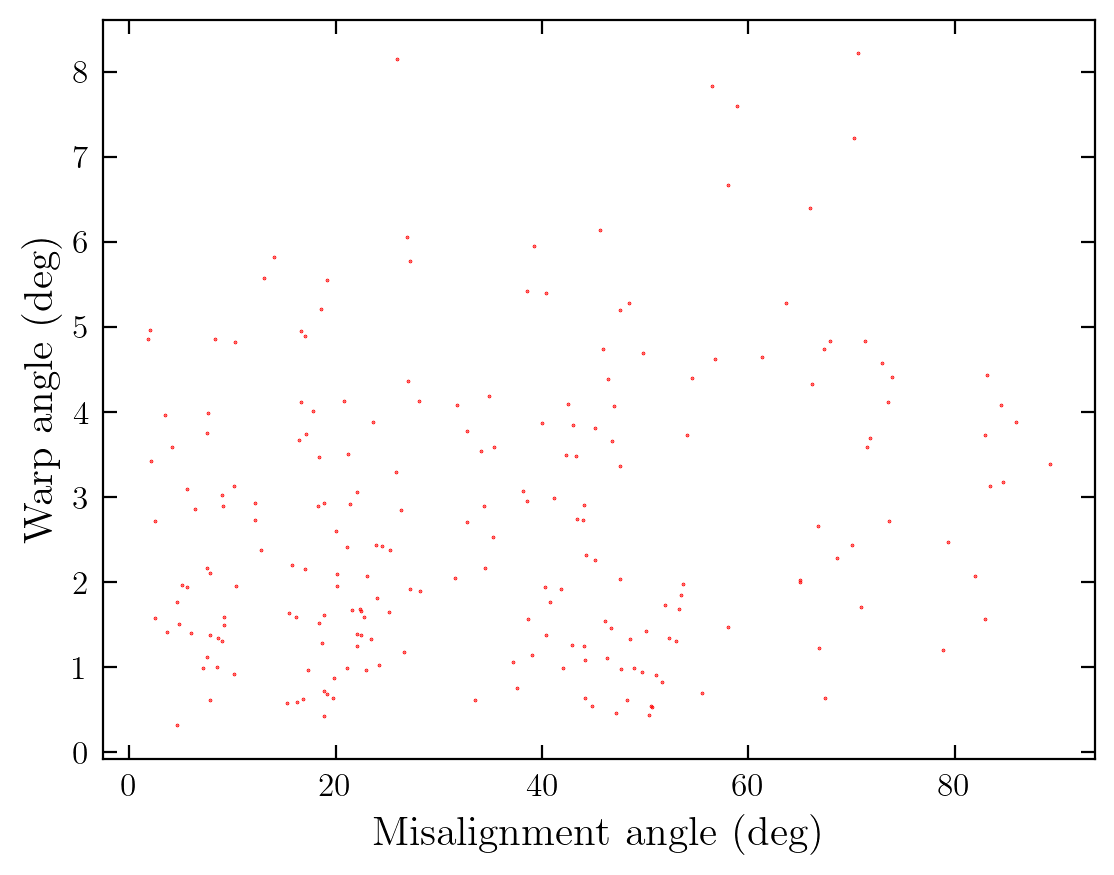

In [18]:
for GrNr in tqdm(FR_GrNr):
    angle_file = anglePath +'GrNr_%d_snap_%d_99_RaxisLaxis_L_angle.npy'%(GrNr,startSnap)
    warp_angle_file = warp_angle_path+'GrNr_%d_snap_%d_99_warp_z_angles.npy'%(GrNr,75)
    warp_angle = (np.load(warp_angle_file,allow_pickle=True))
    disky_angle = (np.load(angle_file,allow_pickle=True))
    warp_angle = np.array(warp_angle)
    disky_angle = np.array(disky_angle)

    for interval in range(len(good_rotation_dict[GrNr]['startStop'])):
        snap_0 = good_rotation_dict[GrNr]['startStop'][interval][0]
        snap_min = good_rotation_dict[GrNr]['startStop'][interval][-1]            
        plt.scatter(disky_angle.T[snap_0:snap_min], warp_angle.T[snap_0:snap_min], s=.1, c='r')
        plt.xlabel('Misalignment angle (deg)')
        plt.ylabel('Warp angle (deg)')

100%|██████████| 40/40 [00:00<00:00, 433.04it/s]


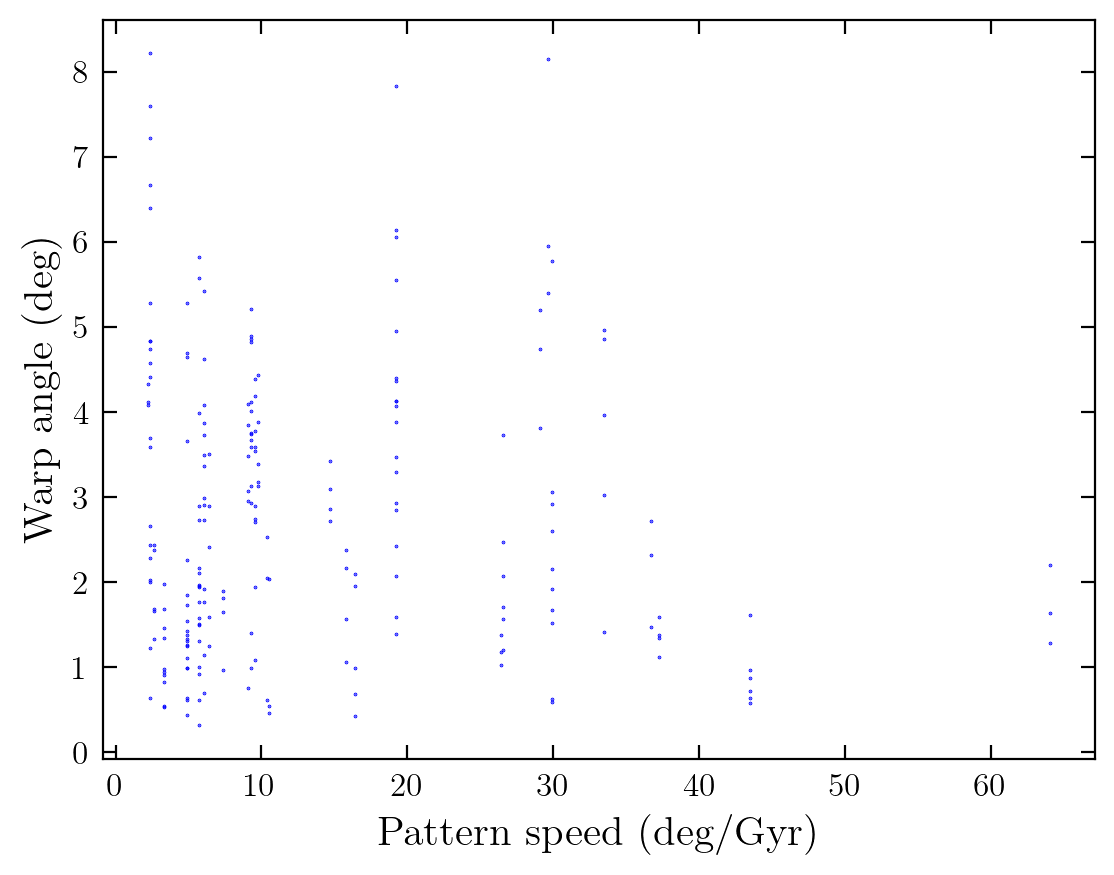

In [19]:
for GrNr in tqdm(final_GrNr):
    warp_angle = []
    angle_file = anglePath +'GrNr_%d_snap_%d_99_RaxisLaxis_L_angle.npy'%(GrNr,startSnap)
    warp_angle_file = warp_angle_path+'GrNr_%d_snap_%d_99_warp_z_angles.npy'%(GrNr,75)

    if exists(warp_angle_file) and exists(angle_file):
        warp_angle.append(np.load(warp_angle_file,allow_pickle=True))
        warp_angle = np.array(warp_angle)
        for interval in range(len(good_rotation_dict[GrNr]['startStop'])):
            snap_0 = good_rotation_dict[GrNr]['startStop'][interval][0]
            snap_min = good_rotation_dict[GrNr]['startStop'][interval][-1]            
            plt.scatter(abs(np.ones((snap_min - snap_0))*good_rotation_dict[GrNr]['Omega'][interval]), warp_angle.T[snap_0:snap_min], s=.1, c='blue')
            plt.xlabel('Pattern speed (deg/Gyr)')
            plt.ylabel('Warp angle (deg)')

As we can see, direct linear correlation probably isn't in the cards, but what if we staggered the snapshots that measurements were compared in to account for the lengthy timescale over which changes in the dark matter halo would induce changes in the disk? There's a lag tester (which plots the Pearson correlation coefficient averaged across snapshots as a function of each lag it tests), but to make sure we're only using measurements from valid epochs, I have the block below. There's probably a more elegant way to do this, but it essentially just goes through each valid interval listed in good_rotation_dict and loads in the valid measurements, populating the rest of the snapshots for eacy galaxy with NaN. After that, it has to put all of these nested lists of lists/arrays and flatten them, and then I put them in Pandas dataframes because those calculate correlation while ignoring NaNs by default.

In [20]:
warp_angle_array = []
disky_angle_array = []
pattern_speed_array = []
for GrNr in tqdm(FR_GrNr):
    warp_angle_list = []
    disky_angle_list = []  
    pattern_speed = []
    angle_file = anglePath +'GrNr_%d_snap_%d_99_RaxisLaxis_L_angle.npy'%(GrNr,startSnap)
    warp_angle_file = warp_angle_path+'GrNr_%d_snap_%d_99_warp_z_angles.npy'%(GrNr,75)
    warp_angle = np.load(warp_angle_file,allow_pickle=True)
    disky_angle = np.load(angle_file,allow_pickle=True)
    if not len(good_rotation_dict[GrNr]['startStop']) == 0:
        
        for interval in range(len(good_rotation_dict[GrNr]['startStop'])):
            if interval == 0:
                snap_0 = good_rotation_dict[GrNr]['startStop'][interval][0]
                snap_min = good_rotation_dict[GrNr]['startStop'][interval][-1]
                if len(good_rotation_dict[GrNr]['startStop']) == 1:
                    warp_angle_list.append([np.nan*np.ones(snap_0),warp_angle[snap_0:snap_min],np.nan*np.ones(25 - snap_min)])
                    disky_angle_list.append([np.nan*np.ones(snap_0),disky_angle[snap_0:snap_min],np.nan*np.ones(25 - snap_min)])
                    pattern_speed.append([np.nan*np.ones(snap_0),np.ones((snap_min - snap_0))*good_rotation_dict[GrNr]['Omega'][interval],np.nan*np.ones(25 - snap_min)])                 
                elif snap_0 == 0:
                    warp_angle_list.append(warp_angle[:snap_min])
                    disky_angle_list.append(disky_angle[:snap_min])
                    pattern_speed.append(np.ones((snap_min))*good_rotation_dict[GrNr]['Omega'][interval])
                else:
                    warp_angle_list.append([np.nan*np.ones(snap_0),warp_angle[snap_0:snap_min]])
                    disky_angle_list.append([np.nan*np.ones(snap_0),disky_angle[snap_0:snap_min]])
                    pattern_speed.append([np.nan*np.ones(snap_0),np.ones((snap_min - snap_0))*good_rotation_dict[GrNr]['Omega'][interval]])
                    
            elif interval == np.arange(len(good_rotation_dict[GrNr]['startStop']))[-1]:
                snap_0 = good_rotation_dict[GrNr]['startStop'][interval][0]
                snap_min = good_rotation_dict[GrNr]['startStop'][interval][-1]    
                snap_last = good_rotation_dict[GrNr]['startStop'][interval-1][-1]
                snap_diff = snap_0 - snap_last
                if snap_diff == 0:
                    if snap_min == 24:
                        warp_angle_list.append(warp_angle[snap_0:])
                        disky_angle_list.append(disky_angle[snap_0:])
                        pattern_speed.append(np.ones((25-snap_0))*good_rotation_dict[GrNr]['Omega'][interval])
                    else:
                        warp_angle_list.append([warp_angle[snap_0:snap_min],np.nan*np.ones(25 - snap_min)])
                        disky_angle_list.append([disky_angle[snap_0:snap_min],np.nan*np.ones(25 - snap_min)])
                        pattern_speed.append([np.ones((snap_min - snap_0))*good_rotation_dict[GrNr]['Omega'][interval],np.nan*np.ones(25 - snap_min)])
                else:
                    if snap_min == 24:
                        warp_angle_list.append([np.nan*np.ones(snap_diff), warp_angle[snap_0:]])
                        disky_angle_list.append([np.nan*np.ones(snap_diff), disky_angle[snap_0:]])
                        pattern_speed.append([np.nan*np.ones(snap_diff), np.ones(25-snap_0)*good_rotation_dict[GrNr]['Omega'][interval]])
                    else:
                        warp_angle_list.append([np.nan*np.ones(snap_diff),warp_angle[snap_0:snap_min],np.nan*np.ones(25 - snap_min)])
                        disky_angle_list.append([np.nan*np.ones(snap_diff),disky_angle[snap_0:snap_min],np.nan*np.ones(25 - snap_min)])
                        pattern_speed.append([np.nan*np.ones(snap_diff),np.ones((snap_min - snap_0))*good_rotation_dict[GrNr]['Omega'][interval],np.nan*np.ones(25 - snap_min)])

            else:
                snap_0 = good_rotation_dict[GrNr]['startStop'][interval][0]
                snap_min = good_rotation_dict[GrNr]['startStop'][interval][-1]
                snap_last = good_rotation_dict[GrNr]['startStop'][interval-1][-1]
                snap_diff = snap_0 - snap_last
                if snap_diff == 0:
                    warp_angle_list.append(warp_angle[snap_0:snap_min])
                    disky_angle_list.append(disky_angle[snap_0:snap_min])
                    pattern_speed.append(np.ones((snap_min - snap_0))*good_rotation_dict[GrNr]['Omega'][interval])
                else:
                    warp_angle_list.append([np.nan*np.ones(snap_diff),warp_angle[snap_0:snap_min]])
                    disky_angle_list.append([np.nan*np.ones(snap_diff),disky_angle[snap_0:snap_min]])
                    pattern_speed.append([np.nan*np.ones(snap_diff),np.ones((snap_min - snap_0))*good_rotation_dict[GrNr]['Omega'][interval]])
                    
        warp_angle_array.append(np.concatenate(flatten(warp_angle_list)).ravel())
        disky_angle_array.append(np.concatenate(flatten(disky_angle_list)).ravel())
        pattern_speed_array.append(np.abs(np.concatenate(flatten(pattern_speed)).ravel()))

100%|██████████| 32/32 [00:00<00:00, 1568.35it/s]


In [21]:
warp_angle_array = np.array(warp_angle_array)
disky_angle_array = np.array(disky_angle_array)
pattern_speed_array = np.array(pattern_speed_array)

TypeError: pearsonr() got an unexpected keyword argument 'nan_policy'

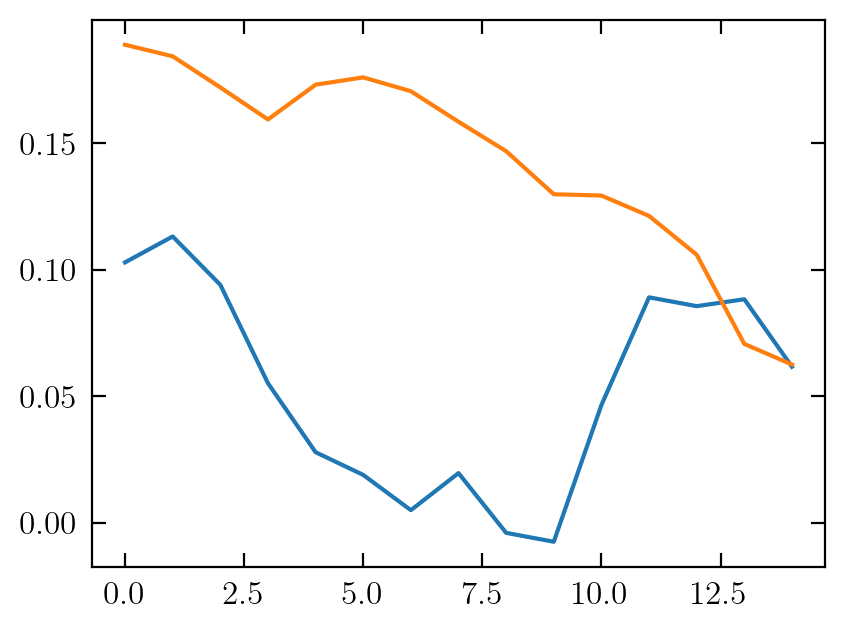

In [23]:
plt.figure(figsize=(4.733,3.55))
lag = np.arange(15)
gavg_correlation = []
g_p_values = []
for i in lag:
    correlation_array = []
    p_array = []
    for snap in range(25-i):
        correlation_array.append(stats.pearsonr(np.array(gas_angles)[:,snap],np.array(warp_angles)[:,(snap+i)])[0])
        p_array.append(stats.pearsonr(np.array(gas_angles)[:,snap],np.array(warp_angles)[:,(snap+i)])[1])
    gavg_correlation.append(np.mean(correlation_array))
    g_p_values.append(np.mean(p_array))
plt.plot(lag,gavg_correlation,label=r"Gas misalignment angle, $\bar{p}$ = 0.518")

tavg_correlation = []
t_p_values = []
for i in lag:
    correlation_array = []
    p_array = []
    for snap in range(25-i):
        correlation_array.append(stats.pearsonr(np.array(z_angles)[:,snap],np.array(warp_angles)[:,(snap+i)])[0])
        p_array.append(stats.pearsonr(np.array(z_angles)[:,snap],np.array(warp_angles)[:,(snap+i)])[1])
    tavg_correlation.append(np.mean(correlation_array))
    t_p_values.append(np.mean(p_array))
plt.plot(lag,tavg_correlation,label=r"Tilt angle, $\bar{p}$ = 0.322")

pavg_correlation = []
d_p_values = []
for i in lag:
    correlation_array = []
    p_array = []
    for snap in range(25-i):
        correlation_array.append(stats.pearsonr(pattern_speed_array[:,snap],(warp_angle_array[:,(snap+i)]),nan_policy='propagate')[0])
        p_array.append(stats.pearsonr(pattern_speed_array[:,snap],(warp_angle_array[:,(snap+i)]),nan_policy='propagate')[1])
    pavg_correlation.append(np.mean(correlation_array))
    d_p_values.append(np.mean(p_array))
plt.plot(lag,pavg_correlation,label=r"Pattern speed, $\bar{p}$ = 0.580")

davg_correlation = []
p_p_values = []
for i in lag:
    correlation_array = []
    p_array = []
    for snap in range(25-i):
        correlation_array.append(stats.pearsonr(disky_angle_array[:,snap],(warp_angle_array[:,(snap+i)]),nan_policy='propagate')[0])
        p_array.append(stats.pearsonr(disky_angle_array[:,snap],(warp_angle_array[:,(snap+i)]),nan_policy='propagate')[1])
    davg_correlation.append(np.mean(correlation_array))
    p_p_values.append(np.mean(p_array))
plt.plot(lag,davg_correlation,label=r"FR misalignment angle, $\bar{p}$ = 0.580")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Lag (snapshots)",fontsize=10)
plt.ylabel("Mean Pearson correlation",fontsize=10)
plt.legend(fontsize=10)

In [ ]:
np.mean(p_p_values)

In [ ]:
np.mean(d_p_values)

In [ ]:
# For one galaxy, zero-lag correlation
FR_axis_misalignment_spl = CubicSpline(tArr[FR_is_defined_inds],FR_AM)
warp_spl = CubicSpline(tArr,warp_vals)

sample_t_arr = np.linspace(0,3.966,25)
resampled_FR_axis_misalignment = FR_axis_misalignment_spl(sample_t_arr)
resampled_warp_vals = warp_spl(sample_t_arr)

resample_FR_axis_misalignment[FR_not_defined_inds] = np.nan


# option 1
corr_coef,p_val = scipy.stats.pearsonr(resample_FR_axis_misalignment,resampled_warp_vals,nan_policy='omit')

# option 2, if 1 fails
corr_coef,p_val = scipy.stats.pearsonr(resample_FR_axis_misalignment[FR_is_defined_inds],resampled_warp_vals[FR_is_defined_inds])

In [22]:
xs = np.linspace(0, 3.966, 25)
tr_list = []
gr_list = []
lags_tested = np.arange(15)

for i in tqdm(range(len(final_diskyIDs))):
    tr_values = [] 
    gr_values = [] 

    for lag in lags_tested:

    warp_f = CubicSpline(snapshot_times[::-1],warp_angles[i][::-1])
    tilt_f = CubicSpline(snapshot_times[::-1],z_angles[i][::-1])
    gas_f = CubicSpline(snapshot_times[::-1],gas_angles[i][::-1])
    
    tr_list.append(np.max(tr_values))
    gr_list.append(np.max(gr_values))

IndentationError: expected an indented block after 'for' statement on line 10 (4282883043.py, line 12)

In [21]:
def r_pvalues(df):
    cols = pd.DataFrame(columns=df.columns)
    p = cols.transpose().join(cols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            p[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)
    return p

Now we can go back to the main figures in the paper

## Warp angle KDE

In [15]:
# defining the epanechnikov kernel
def K_E(u):
    if (u<=1):
        return 3/4*(1-np.square(u))
    else:
        return 0

def KDE(x_input,h,data):
    """
    Generating kernel density estimate for data and bins
    """
    output = np.zeros(len(x_input))
    for i,x in enumerate(x_input):
        for j, xj in enumerate(data):
            output[i] += 1/h*K_E(np.abs((x-xj)/h))
        output[i] = output[i]/len(data)
    return output

def silverman(data):
    """
    Establishes Silverman's rule for the bandwidth
    """
    std = np.std(data)
    m = stats.iqr(data)/1.34
    if (std) < m:
        m = std
    return 0.9*m*(len(data))**(-1/5)

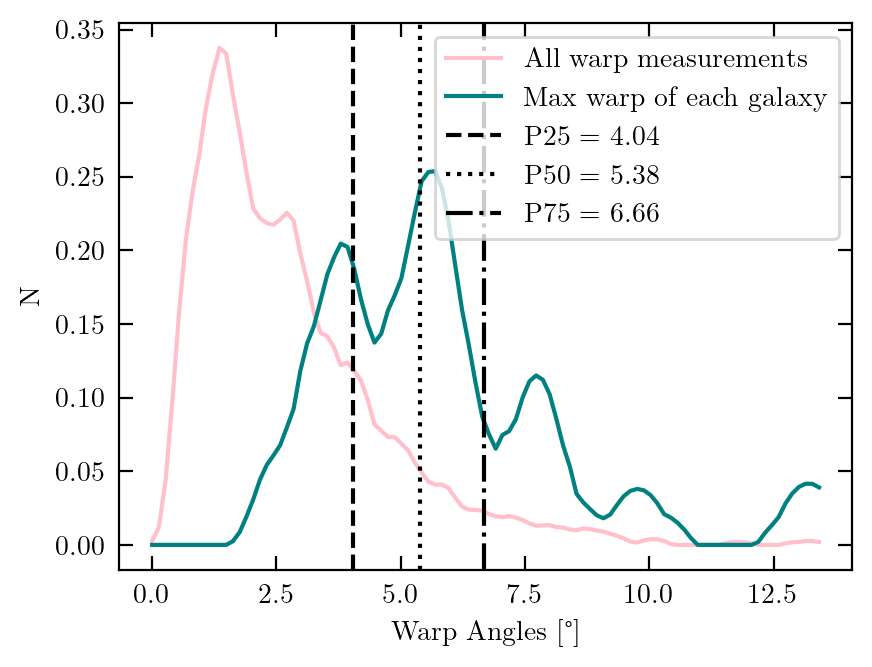

In [16]:
plt.figure(figsize=(4.733,3.55))
x = np.linspace(0,np.max(warp_angles),100)
#plt.hist(warp_angles.flatten(),density=1,color='r')
plt.plot(x,KDE(x,silverman((np.array(warp_angles).flatten())),np.array(warp_angles).flatten()),label='All warp measurements',c='pink')
#plt.hist(np.max(warp_angles,1),density=1,color='b')
plt.plot(x,KDE(x,silverman(np.max(np.array(warp_angles),axis=1)),np.max(np.array(warp_angles),axis=1)),label='Max warp of each galaxy', c='teal')

plt.xlabel('Warp Angles [°]',fontsize=10)
plt.ylabel('N',fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axvline(np.percentile(np.max(warp_angles,1), 25), c='black', linestyle = '--', label=f'P25 = {truncate(np.percentile(np.max(warp_angles,1), 25),2)}')
plt.axvline(np.percentile(np.max(warp_angles,1), 50), c='black', linestyle = ':', label=f'P50 = {truncate(np.median(np.max(warp_angles,1)),2)}')
plt.axvline(np.percentile(np.max(warp_angles,1), 75), c='black', linestyle = '-.', label=f'P75 = {truncate(np.percentile(np.max(warp_angles,1), 75),2)}')
plt.legend(fontsize=10)

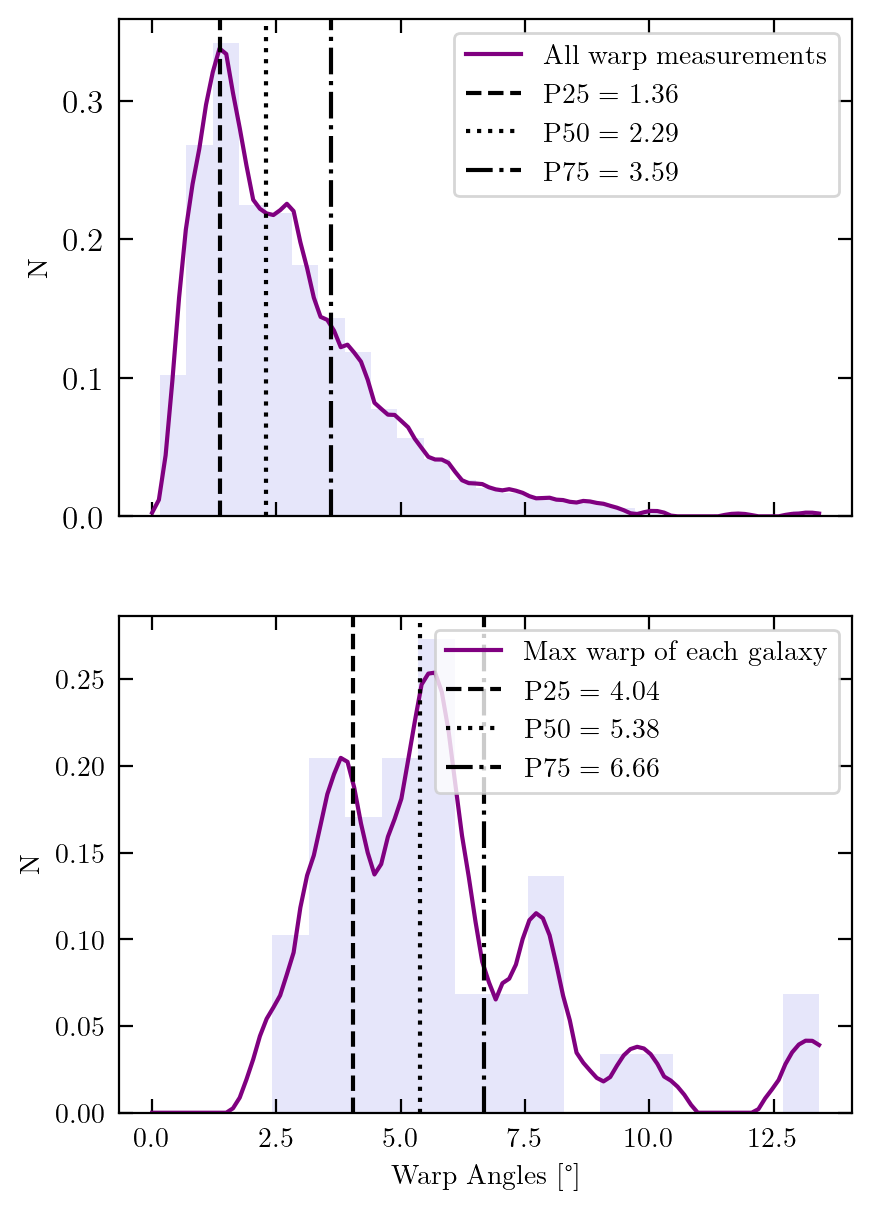

In [17]:
fig,axes = plt.subplots(2,1,figsize=(4.733,2*3.55),sharex=True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

x = np.linspace(0,np.max(warp_angles),100)
axes[0].hist(warp_angles.flatten(),density=1,color='lavender',bins=25)
axes[0].plot(x,KDE(x,silverman((np.array(warp_angles).flatten())),np.array(warp_angles).flatten()),label='All warp measurements',c='purple')
axes[0].set_ylabel('N',fontsize=10)
axes[0].axvline(np.percentile(warp_angles, 25), c='black', linestyle = '--', label=f'P25 = {truncate(np.percentile((warp_angles), 25),2)}')
axes[0].axvline(np.percentile((warp_angles), 50), c='black', linestyle = ':', label=f'P50 = {truncate(np.median((warp_angles)),2)}')
axes[0].axvline(np.percentile((warp_angles), 75), c='black', linestyle = '-.', label=f'P75 = {truncate(np.percentile((warp_angles), 75),2)}')
axes[0].legend(fontsize=10)

axes[1].hist(np.max(warp_angles,1),density=1,color='lavender',bins=15)
axes[1].plot(x,KDE(x,silverman(np.max(np.array(warp_angles),axis=1)),np.max(np.array(warp_angles),axis=1)),label='Max warp of each galaxy', c='purple')
axes[1].set_xlabel('Warp Angles [°]',fontsize=10)
axes[1].set_ylabel('N',fontsize=10)
axes[1].axvline(np.percentile(np.max(warp_angles,1), 25), c='black', linestyle = '--', label=f'P25 = {truncate(np.percentile(np.max(warp_angles,1), 25),2)}')
axes[1].axvline(np.percentile(np.max(warp_angles,1), 50), c='black', linestyle = ':', label=f'P50 = {truncate(np.median(np.max(warp_angles,1)),2)}')
axes[1].axvline(np.percentile(np.max(warp_angles,1), 75), c='black', linestyle = '-.', label=f'P75 = {truncate(np.percentile(np.max(warp_angles,1), 75),2)}')
axes[1].legend(fontsize=10)

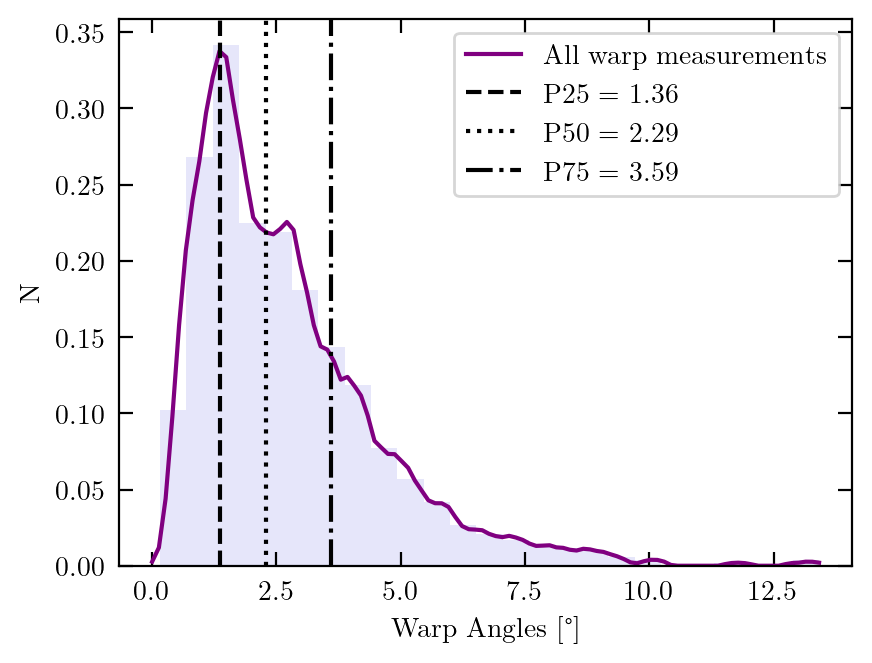

In [18]:
plt.figure(figsize=(4.733,3.55))
plt.hist(warp_angles.flatten(),density=1,color='lavender',bins=25)
plt.plot(x,KDE(x,silverman((np.array(warp_angles).flatten())),np.array(warp_angles).flatten()),label='All warp measurements',c='purple')

plt.xlabel('Warp Angles [°]',fontsize=10)
plt.ylabel('N',fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axvline(np.percentile(warp_angles, 25), c='black', linestyle = '--', label=f'P25 = {truncate(np.percentile((warp_angles), 25),2)}')
plt.axvline(np.percentile((warp_angles), 50), c='black', linestyle = ':', label=f'P50 = {truncate(np.median((warp_angles)),2)}')
plt.axvline(np.percentile((warp_angles), 75), c='black', linestyle = '-.', label=f'P75 = {truncate(np.percentile((warp_angles), 75),2)}')
plt.legend(fontsize=10)

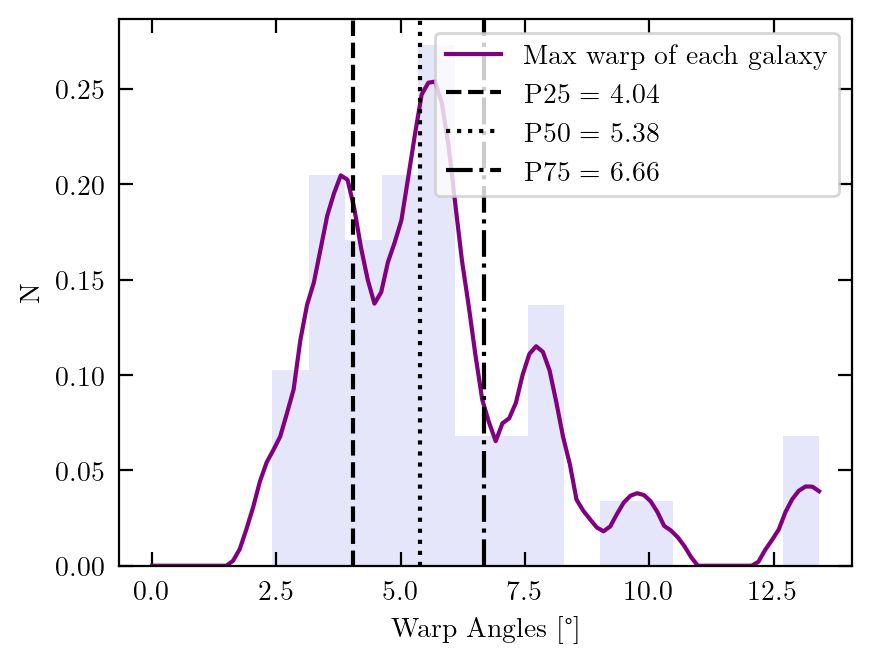

In [19]:
plt.figure(figsize=(4.733,3.55))
x = np.linspace(0,np.max(warp_angles),100)
plt.hist(np.max(warp_angles,1),density=1,color='lavender',bins=15)
plt.plot(x,KDE(x,silverman(np.max(np.array(warp_angles),axis=1)),np.max(np.array(warp_angles),axis=1)),label='Max warp of each galaxy', c='purple')

plt.xlabel('Warp Angles [°]',fontsize=10)
plt.ylabel('N',fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axvline(np.percentile(np.max(warp_angles,1), 25), c='black', linestyle = '--', label=f'P25 = {truncate(np.percentile(np.max(warp_angles,1), 25),2)}')
plt.axvline(np.percentile(np.max(warp_angles,1), 50), c='black', linestyle = ':', label=f'P50 = {truncate(np.median(np.max(warp_angles,1)),2)}')
plt.axvline(np.percentile(np.max(warp_angles,1), 75), c='black', linestyle = '-.', label=f'P75 = {truncate(np.percentile(np.max(warp_angles,1), 75),2)}')
plt.legend(fontsize=10)

## Case Studies

(4.1, -0.1)

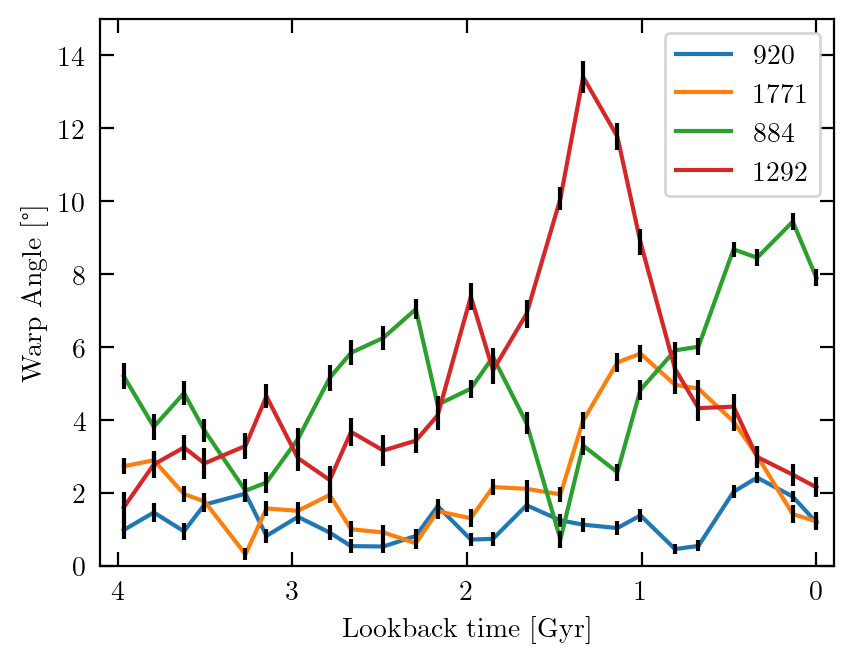

In [15]:
case_ids = [6,28,9,23]
plt.figure(figsize=(4.733,3.55))

for i in case_ids:
    plt.plot(snapshot_times, warp_angles[i], label = final_GrNr[i])
    plt.errorbar(snapshot_times, warp_angles[i], yerr = warp_angles_stds[i],fmt='none',ecolor='black') 
plt.legend(fontsize = 10)
plt.ylim(0,15)
plt.xlabel('Lookback time [Gyr]',fontsize = 10)
plt.ylabel(r'Warp Angle [°]',fontsize = 10)
plt.tick_params(labelsize=10)
plt.xlim(4.1,-0.1)

Text(0.5, 0, 'Lookback time [Gyr]')

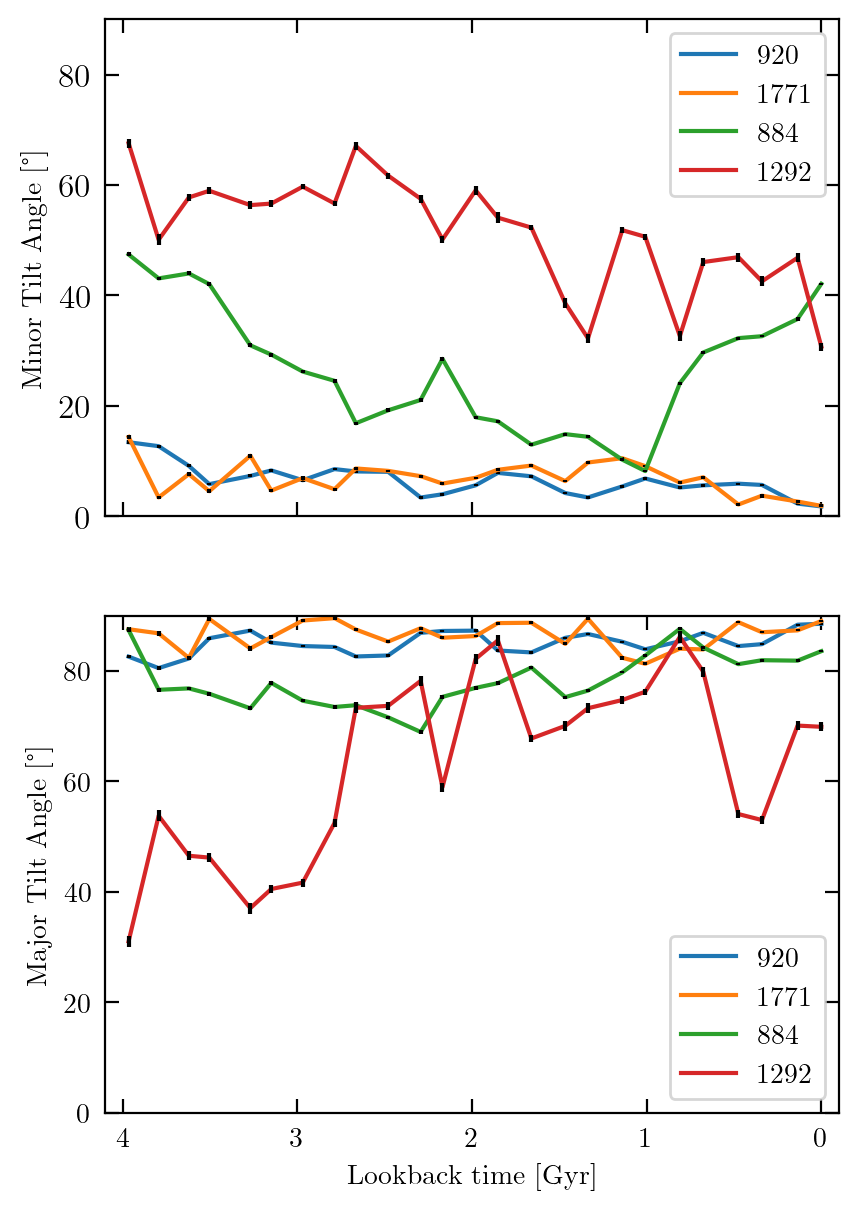

In [16]:
fig,axes = plt.subplots(2,1,figsize=(4.733,3.55*2),sharex=True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(labelsize=10)

for i in case_ids:
    axes[0].plot(snapshot_times, z_angles[i], label = final_GrNr[i])
    axes[0].errorbar(snapshot_times, z_angles[i], yerr = z_angles_stds[i],fmt='none',ecolor='black') 
axes[0].legend(fontsize = 10)
axes[0].set_ylim(0,90)
axes[0].set_ylabel(r'Minor Tilt Angle [°]',fontsize = 10)
axes[0].set_xlim(4.1,-0.1)

for i in case_ids:
    axes[1].plot(snapshot_times, x_angles[i], label = final_GrNr[i])
    axes[1].errorbar(snapshot_times, x_angles[i], yerr = x_angles_stds[i],fmt='none',ecolor='black') 
axes[1].legend(fontsize = 10)
axes[1].set_ylim(0,90)
axes[1].set_ylabel(r'Major Tilt Angle [°]',fontsize = 10)
axes[1].set_xlim(4.1,-0.1)
axes[1].set_xlabel('Lookback time [Gyr]',fontsize = 10)

In [17]:
def get_axes_error(N,c_a,b_a):
    p_e = (1 - 2*b_a + c_a)/(1 - c_a)
    sigma_x = 1.01e-2 * np.sqrt(N) / np.sinh(.817 * (1 + p_e))
    sigma_z = 5.34e-6 * np.sqrt(N) / np.sinh(5.84e-4 * (1 - p_e))
    return sigma_x, sigma_z

Text(0, 0.9, '$\\bar{x}$')

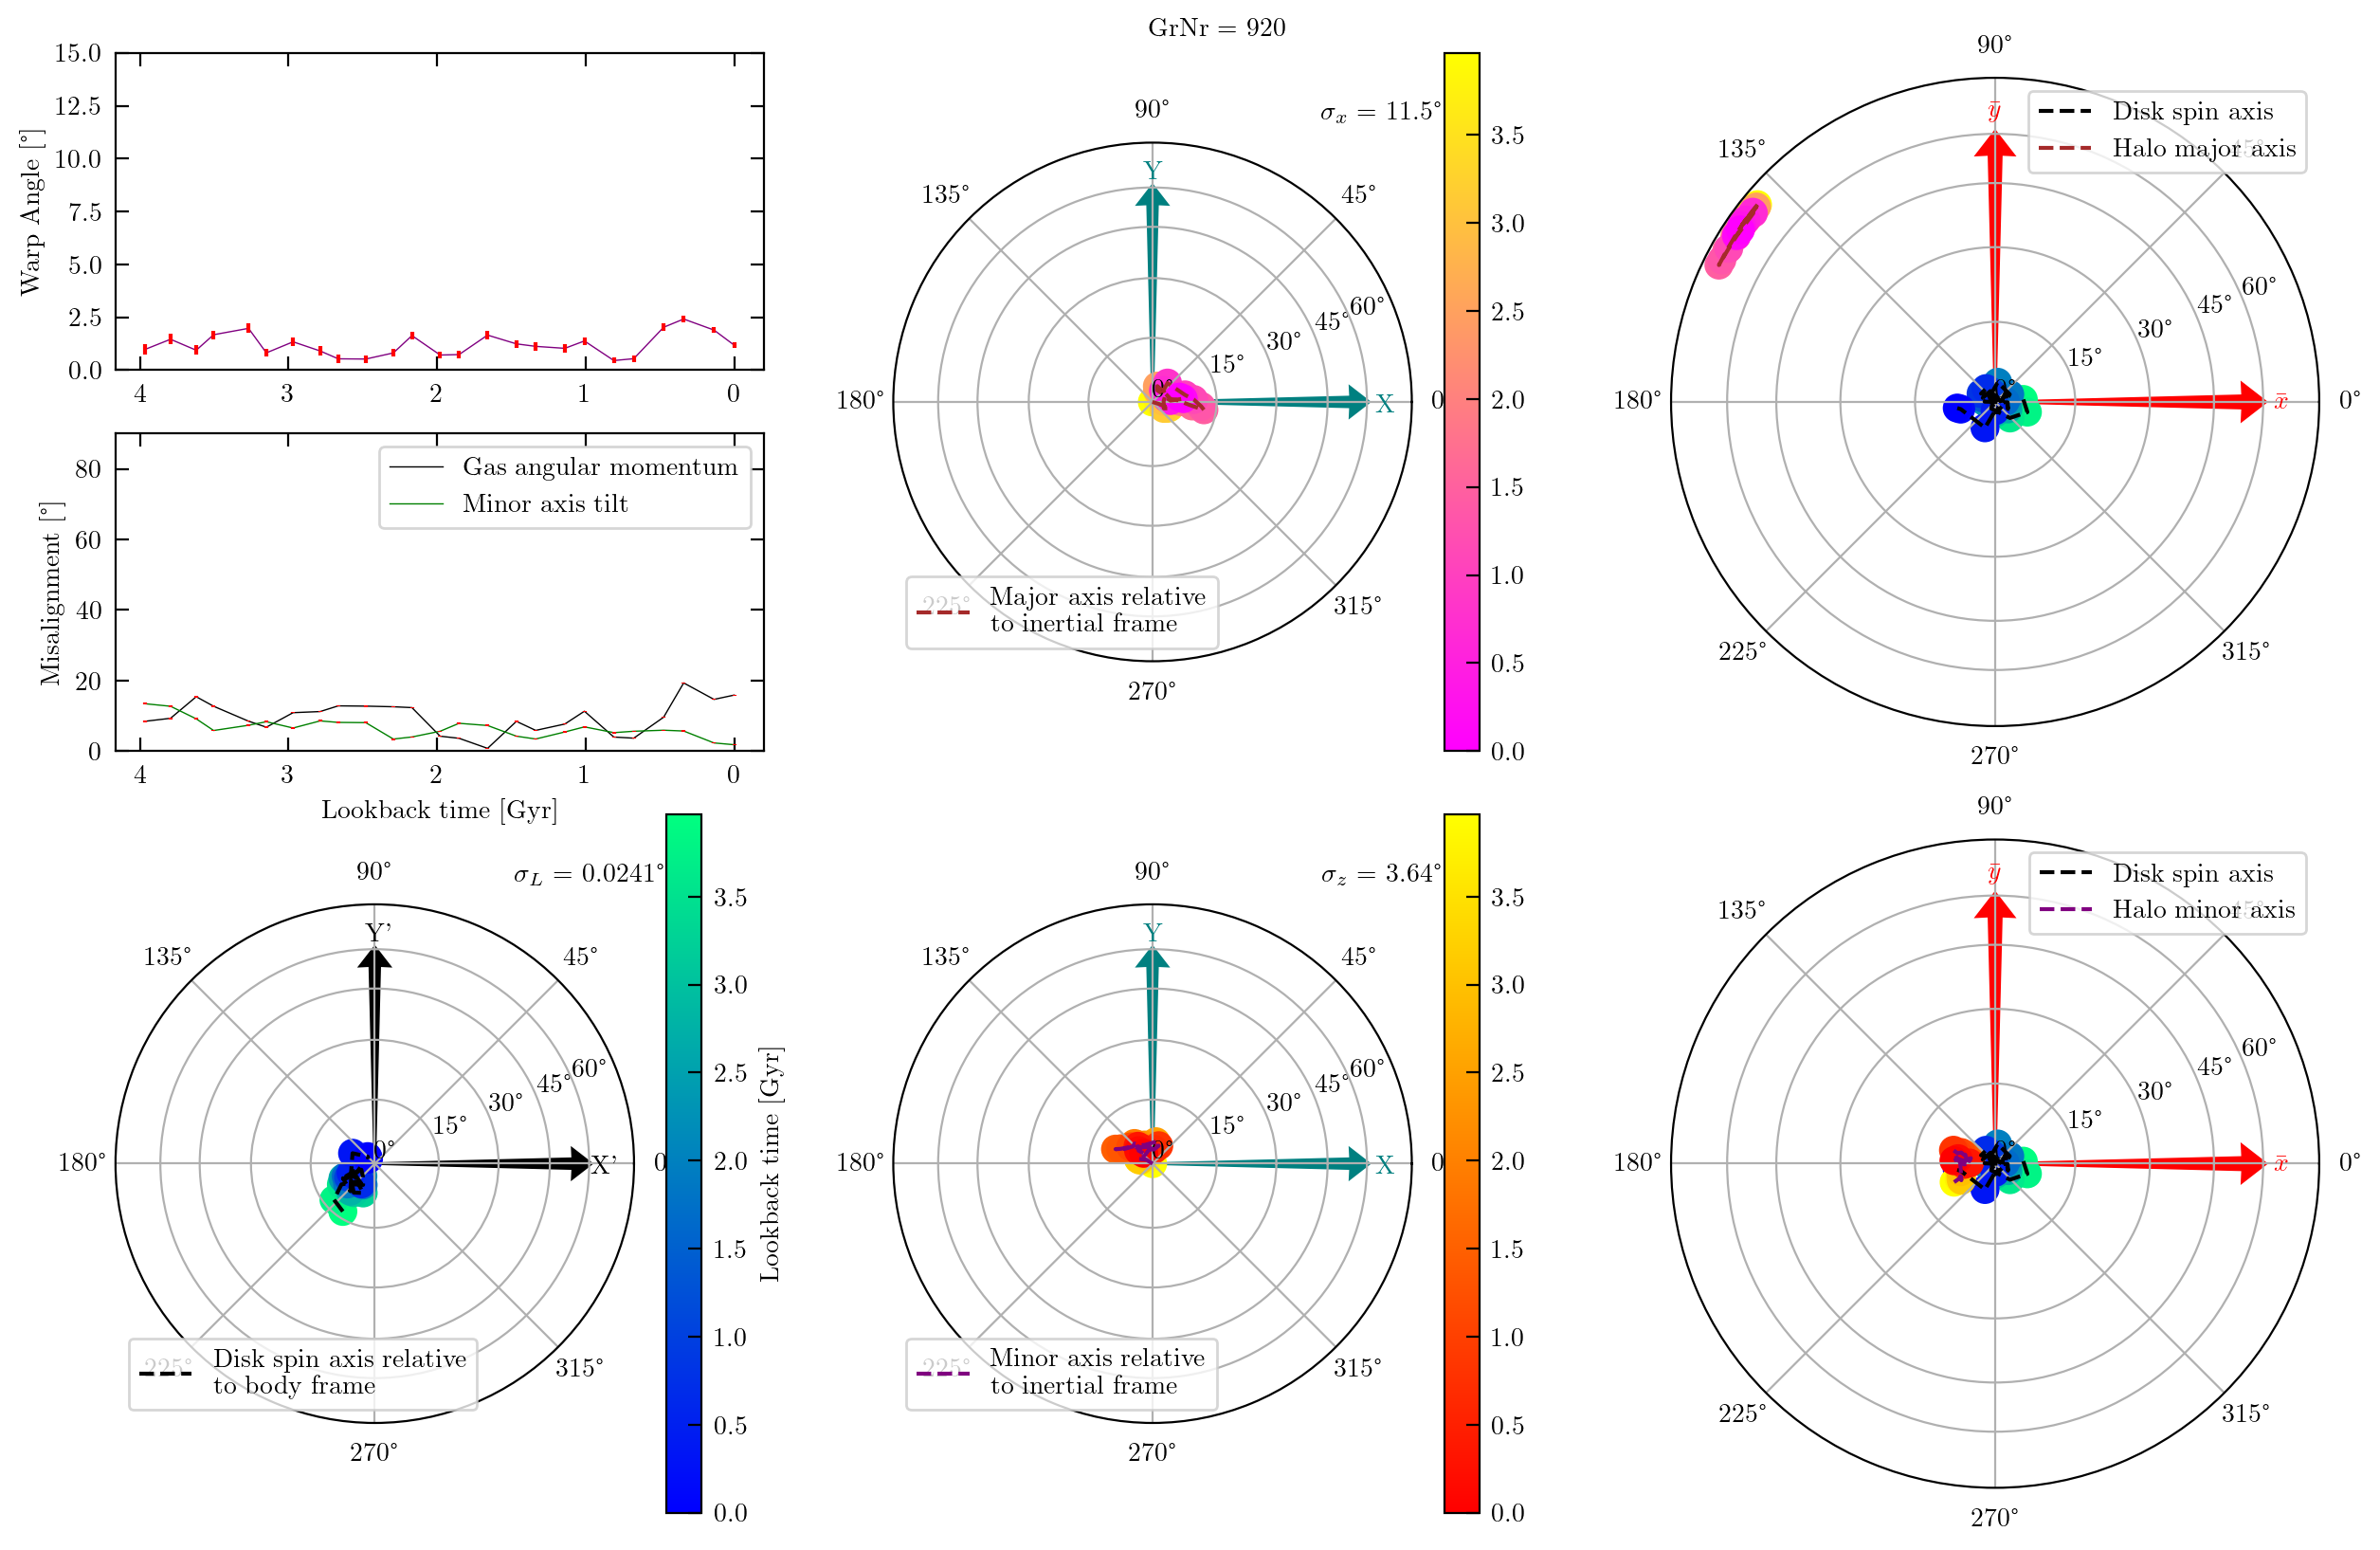

In [17]:
diskyidx = 6
fig = plt.figure(figsize=(15,10),frameon=True)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gs = gridspec.GridSpec(4,3)
plt.xticks([])
plt.yticks([])
GrNr = final_GrNr[diskyidx]
subfindID = final_diskyIDs[diskyidx]
rel_mag = warp_angles[diskyidx]
plt.title(f'GrNr = {GrNr}',fontsize = 10)

L_body_theta,L_body_phi = get_body_briggs(GrNr, subfindID, False)
x_body_theta,x_body_phi = get_x_briggs(GrNr, subfindID, False)
z_body_theta,z_body_phi = get_z_briggs(GrNr, subfindID, False)
L_theta_z,L_phi_z,z_theta_z,z_phi_z = get_minor_briggs(GrNr, subfindID, False)
L_theta_x,L_phi_x,z_theta_x,z_phi_x = get_major_briggs(GrNr, subfindID, False)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylim(0,15)
ax1.plot(snapshot_times, warp_angles[diskyidx], c='purple', linewidth = 0.5)
ax1.errorbar(snapshot_times, warp_angles[diskyidx], yerr = warp_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax1.set_ylabel(r'Warp Angle [°]',fontsize = 10)
ax1.tick_params(labelsize=10)

ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
ax2.set_ylim(0,90)
ax2.plot(snapshot_times, gas_angles[diskyidx], c='black', linewidth = 1/2,label='Gas angular momentum')
ax2.errorbar(snapshot_times, gas_angles[diskyidx], yerr = gas_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax2.plot(snapshot_times, z_angles[diskyidx], c='green', linewidth = 1/2,label='Minor axis tilt')
ax2.errorbar(snapshot_times, z_angles[diskyidx], yerr = z_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax2.xaxis.set_inverted(True)  
ax2.set_ylabel('Misalignment [°]',fontsize = 10)
ax2.legend(fontsize=10)
ax2.set_xlabel('Lookback time [Gyr]',fontsize = 10)
ax2.tick_params(labelsize=10)

ax4 = fig.add_subplot(gs[2:, 0],projection = 'polar')
ax4.plot(L_body_phi, np.sin(L_body_theta),c='black',linestyle = '--',label='Disk spin axis relative \n to body frame')
color_scatter = ax4.scatter(L_body_phi, np.sin(L_body_theta),c=snapshot_times,s=100,cmap='winter')
cbar = plt.colorbar(color_scatter)
cbar.ax.tick_params(labelsize = 10)
cbar.set_label('Lookback time [Gyr]',fontsize = 10)
ax4.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax4.tick_params(labelsize=10)
ax4.set_rlim([0,np.pi/3])
ax4.legend(fontsize=10)
ax4.text(1.06, 1.08, f'$\sigma_L$ = {truncate(np.mean(np.array([disk_phi_stds[diskyidx],disk_theta_stds[diskyidx]])),4)}°', 
        transform=ax4.transAxes, va='top', ha='right',fontsize = 10)
ax4.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.annotate("Y'", c='black',xy=(np.pi/2-np.pi/192,0.9),ha='center',fontsize = 10)
ax4.annotate("X'", c='black',xy=(-np.pi/192,0.87),va='center',fontsize = 10)

ax5 = fig.add_subplot(gs[:2,1],projection='polar')
ax5.plot(x_body_phi, np.sin(x_body_theta),c='brown',linestyle = '--',markersize=1,label='Major axis relative \n to inertial frame')
color_scatter = ax5.scatter(x_body_phi, np.sin(x_body_theta),c=snapshot_times,s=100,cmap='spring')
cbar = plt.colorbar(color_scatter)
cbar.ax.tick_params(labelsize = 10)
ax5.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax5.tick_params(labelsize=10)
ax5.set_rlim([0,np.pi/3])
ax5.legend(fontsize=10)
ax5.text(1.06, 1.08, f'$\sigma_x$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[0],1)}°', 
        transform=ax5.transAxes, va='top', ha='right',fontsize = 10)
ax5.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax5.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax6 = fig.add_subplot(gs[2:, 1],projection='polar')
ax6.plot(z_body_phi, np.sin(z_body_theta),c='purple',linestyle = '--',markersize=1,label='Minor axis relative \n to inertial frame')
color_scatter = ax6.scatter(z_body_phi, np.sin(z_body_theta),c=snapshot_times,s=100,cmap='autumn')
cbar = plt.colorbar(color_scatter)
cbar.ax.tick_params(labelsize = 10)
ax6.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax6.tick_params(labelsize=10)
ax6.set_rlim([0,np.pi/3])
ax6.legend(fontsize=10)
ax6.text(1.06, 1.08, f'$\sigma_z$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[1],2)}°', 
        transform=ax6.transAxes, va='top', ha='right',fontsize = 10)
ax6.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax6.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax7 = fig.add_subplot(gs[2:,2],projection='polar')
ax7.plot(L_phi_z, np.sin(L_theta_z),c='black',linestyle = '--',label='Disk spin axis')
ax7.scatter(L_phi_z, np.sin(L_theta_z),c=snapshot_times,s=100,cmap='winter')
ax7.plot(z_phi_z, np.sin(z_theta_z),c='purple',linestyle = '--',markersize=1,label='Halo minor axis')
ax7.scatter(z_phi_z, np.sin(z_theta_z),c=snapshot_times,s=100,cmap='autumn')
ax7.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax7.tick_params(labelsize=10)
ax7.set_rlim([0,np.pi/3])
ax7.legend(fontsize=10)
ax7.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax7.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

ax8 = fig.add_subplot(gs[:2,2],projection='polar')
ax8.plot(L_phi_x, np.sin(L_theta_x),c='black',linestyle = '--',label='Disk spin axis')
ax8.scatter(L_phi_x, np.sin(L_theta_x),c=snapshot_times,s=100,cmap='winter')
ax8.plot(z_phi_x, np.sin(z_theta_x),c='brown',linestyle = '--',markersize=1,label='Halo major axis')
ax8.scatter(z_phi_x, np.sin(z_theta_x),c=snapshot_times,s=100,cmap='spring')
ax8.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax8.tick_params(labelsize=10)
ax8.set_rlim([0,np.pi/3])
ax8.legend(fontsize=10)
ax8.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax8.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

Text(0, 0.9, '$\\bar{x}$')

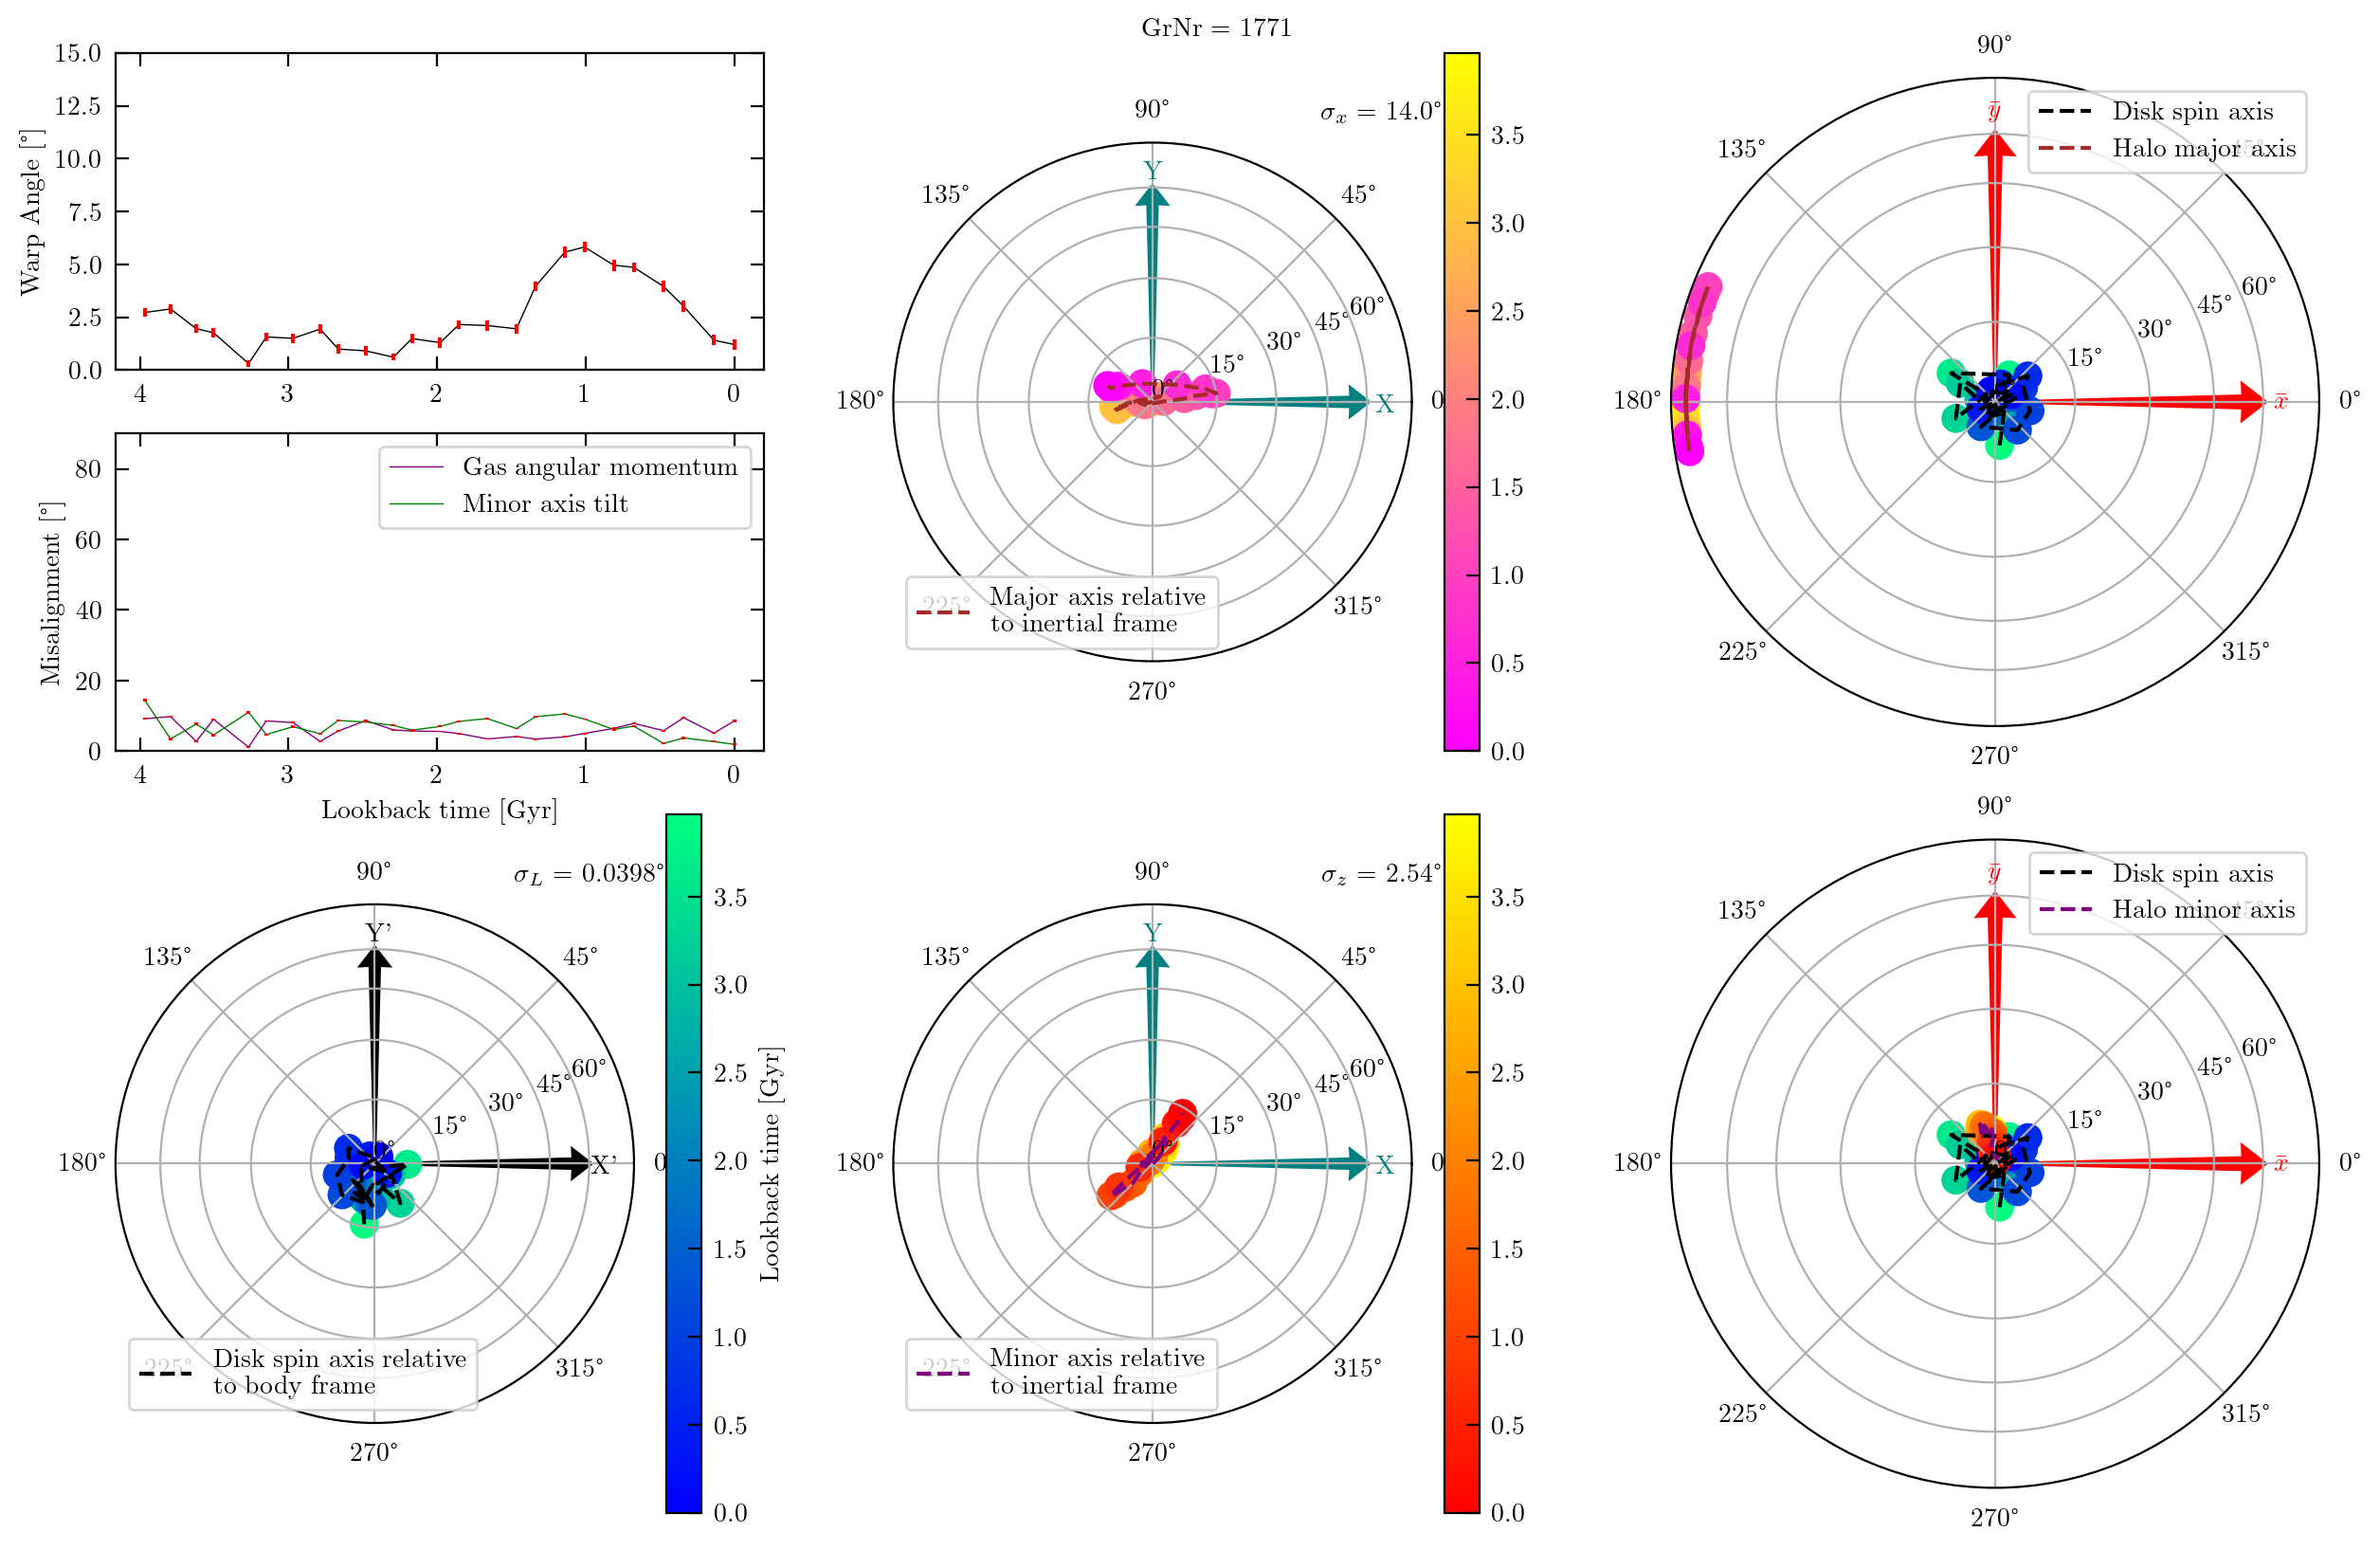

In [18]:
diskyidx = 28
fig = plt.figure(figsize=(15,10),frameon=True)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gs = gridspec.GridSpec(4,3)
plt.xticks([])
plt.yticks([])
GrNr = final_GrNr[diskyidx]
subfindID = final_diskyIDs[diskyidx]
rel_mag = warp_angles[diskyidx]
plt.title(f'GrNr = {GrNr}',fontsize = 10)

L_body_theta,L_body_phi = get_body_briggs(GrNr, subfindID, False)
x_body_theta,x_body_phi = get_x_briggs(GrNr, subfindID, False)
z_body_theta,z_body_phi = get_z_briggs(GrNr, subfindID, False)
L_theta_z,L_phi_z,z_theta_z,z_phi_z = get_minor_briggs(GrNr, subfindID, False)
L_theta_x,L_phi_x,z_theta_x,z_phi_x = get_major_briggs(GrNr, subfindID, False)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylim(0,15)
ax1.plot(snapshot_times, warp_angles[diskyidx], c='black', linewidth = 0.5)
ax1.errorbar(snapshot_times, warp_angles[diskyidx], yerr = warp_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax1.set_ylabel(r'Warp Angle [°]',fontsize = 10)
ax1.tick_params(labelsize=10)

ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
ax2.set_ylim(0,90)
ax2.plot(snapshot_times, gas_angles[diskyidx], c='purple', linewidth = 1/2,label='Gas angular momentum')
ax2.errorbar(snapshot_times, gas_angles[diskyidx], yerr = gas_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax2.plot(snapshot_times, z_angles[diskyidx], c='green', linewidth = 1/2,label='Minor axis tilt')
ax2.errorbar(snapshot_times, z_angles[diskyidx], yerr = z_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax2.xaxis.set_inverted(True)  
ax2.set_ylabel('Misalignment [°]',fontsize = 10)
ax2.legend(fontsize=10)
ax2.set_xlabel('Lookback time [Gyr]',fontsize = 10)
ax2.tick_params(labelsize=10)

ax4 = fig.add_subplot(gs[2:, 0],projection = 'polar')
ax4.plot(L_body_phi, np.sin(L_body_theta),c='black',linestyle = '--',label='Disk spin axis relative \n to body frame')
color_scatter = ax4.scatter(L_body_phi, np.sin(L_body_theta),c=snapshot_times,s=100,cmap='winter')
cbar = plt.colorbar(color_scatter)
cbar.ax.tick_params(labelsize = 10)
cbar.set_label('Lookback time [Gyr]',fontsize = 10)
ax4.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax4.tick_params(labelsize=10)
ax4.set_rlim([0,np.pi/3])
ax4.legend(fontsize=10)
ax4.text(1.06, 1.08, f'$\sigma_L$ = {truncate(np.mean(np.array([disk_phi_stds[diskyidx],disk_theta_stds[diskyidx]])),4)}°', 
        transform=ax4.transAxes, va='top', ha='right',fontsize = 10)
ax4.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.annotate("Y'", c='black',xy=(np.pi/2-np.pi/192,0.9),ha='center',fontsize = 10)
ax4.annotate("X'", c='black',xy=(-np.pi/192,0.87),va='center',fontsize = 10)

ax5 = fig.add_subplot(gs[:2,1],projection='polar')
ax5.plot(x_body_phi, np.sin(x_body_theta),c='brown',linestyle = '--',markersize=1,label='Major axis relative \n to inertial frame')
color_scatter = ax5.scatter(x_body_phi, np.sin(x_body_theta),c=snapshot_times,s=100,cmap='spring')
cbar = plt.colorbar(color_scatter)
cbar.ax.tick_params(labelsize = 10)
ax5.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax5.tick_params(labelsize=10)
ax5.set_rlim([0,np.pi/3])
ax5.legend(fontsize=10)
ax5.text(1.06, 1.08, f'$\sigma_x$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[0],1)}°', 
        transform=ax5.transAxes, va='top', ha='right',fontsize = 10)
ax5.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax5.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax6 = fig.add_subplot(gs[2:, 1],projection='polar')
ax6.plot(z_body_phi, np.sin(z_body_theta),c='purple',linestyle = '--',markersize=1,label='Minor axis relative \n to inertial frame')
color_scatter = ax6.scatter(z_body_phi, np.sin(z_body_theta),c=snapshot_times,s=100,cmap='autumn')
cbar = plt.colorbar(color_scatter)
cbar.ax.tick_params(labelsize = 10)
ax6.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax6.tick_params(labelsize=10)
ax6.set_rlim([0,np.pi/3])
ax6.legend(fontsize=10)
ax6.text(1.06, 1.08, f'$\sigma_z$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[1],2)}°', 
        transform=ax6.transAxes, va='top', ha='right',fontsize = 10)
ax6.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax6.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax7 = fig.add_subplot(gs[2:,2],projection='polar')
ax7.plot(L_phi_z, np.sin(L_theta_z),c='black',linestyle = '--',label='Disk spin axis')
ax7.scatter(L_phi_z, np.sin(L_theta_z),c=snapshot_times,s=100,cmap='winter')
ax7.plot(z_phi_z, np.sin(z_theta_z),c='purple',linestyle = '--',markersize=1,label='Halo minor axis')
ax7.scatter(z_phi_z, np.sin(z_theta_z),c=snapshot_times,s=100,cmap='autumn')
ax7.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax7.tick_params(labelsize=10)
ax7.set_rlim([0,np.pi/3])
ax7.legend(fontsize=10)
ax7.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax7.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

ax8 = fig.add_subplot(gs[:2,2],projection='polar')
ax8.plot(L_phi_x, np.sin(L_theta_x),c='black',linestyle = '--',label='Disk spin axis')
ax8.scatter(L_phi_x, np.sin(L_theta_x),c=snapshot_times,s=100,cmap='winter')
ax8.plot(z_phi_x, np.sin(z_theta_x),c='brown',linestyle = '--',markersize=1,label='Halo major axis')
ax8.scatter(z_phi_x, np.sin(z_theta_x),c=snapshot_times,s=100,cmap='spring')
ax8.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax8.tick_params(labelsize=10)
ax8.set_rlim([0,np.pi/3])
ax8.legend(fontsize=10)
ax8.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax8.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

Text(0, 0.9, '$\\bar{x}$')

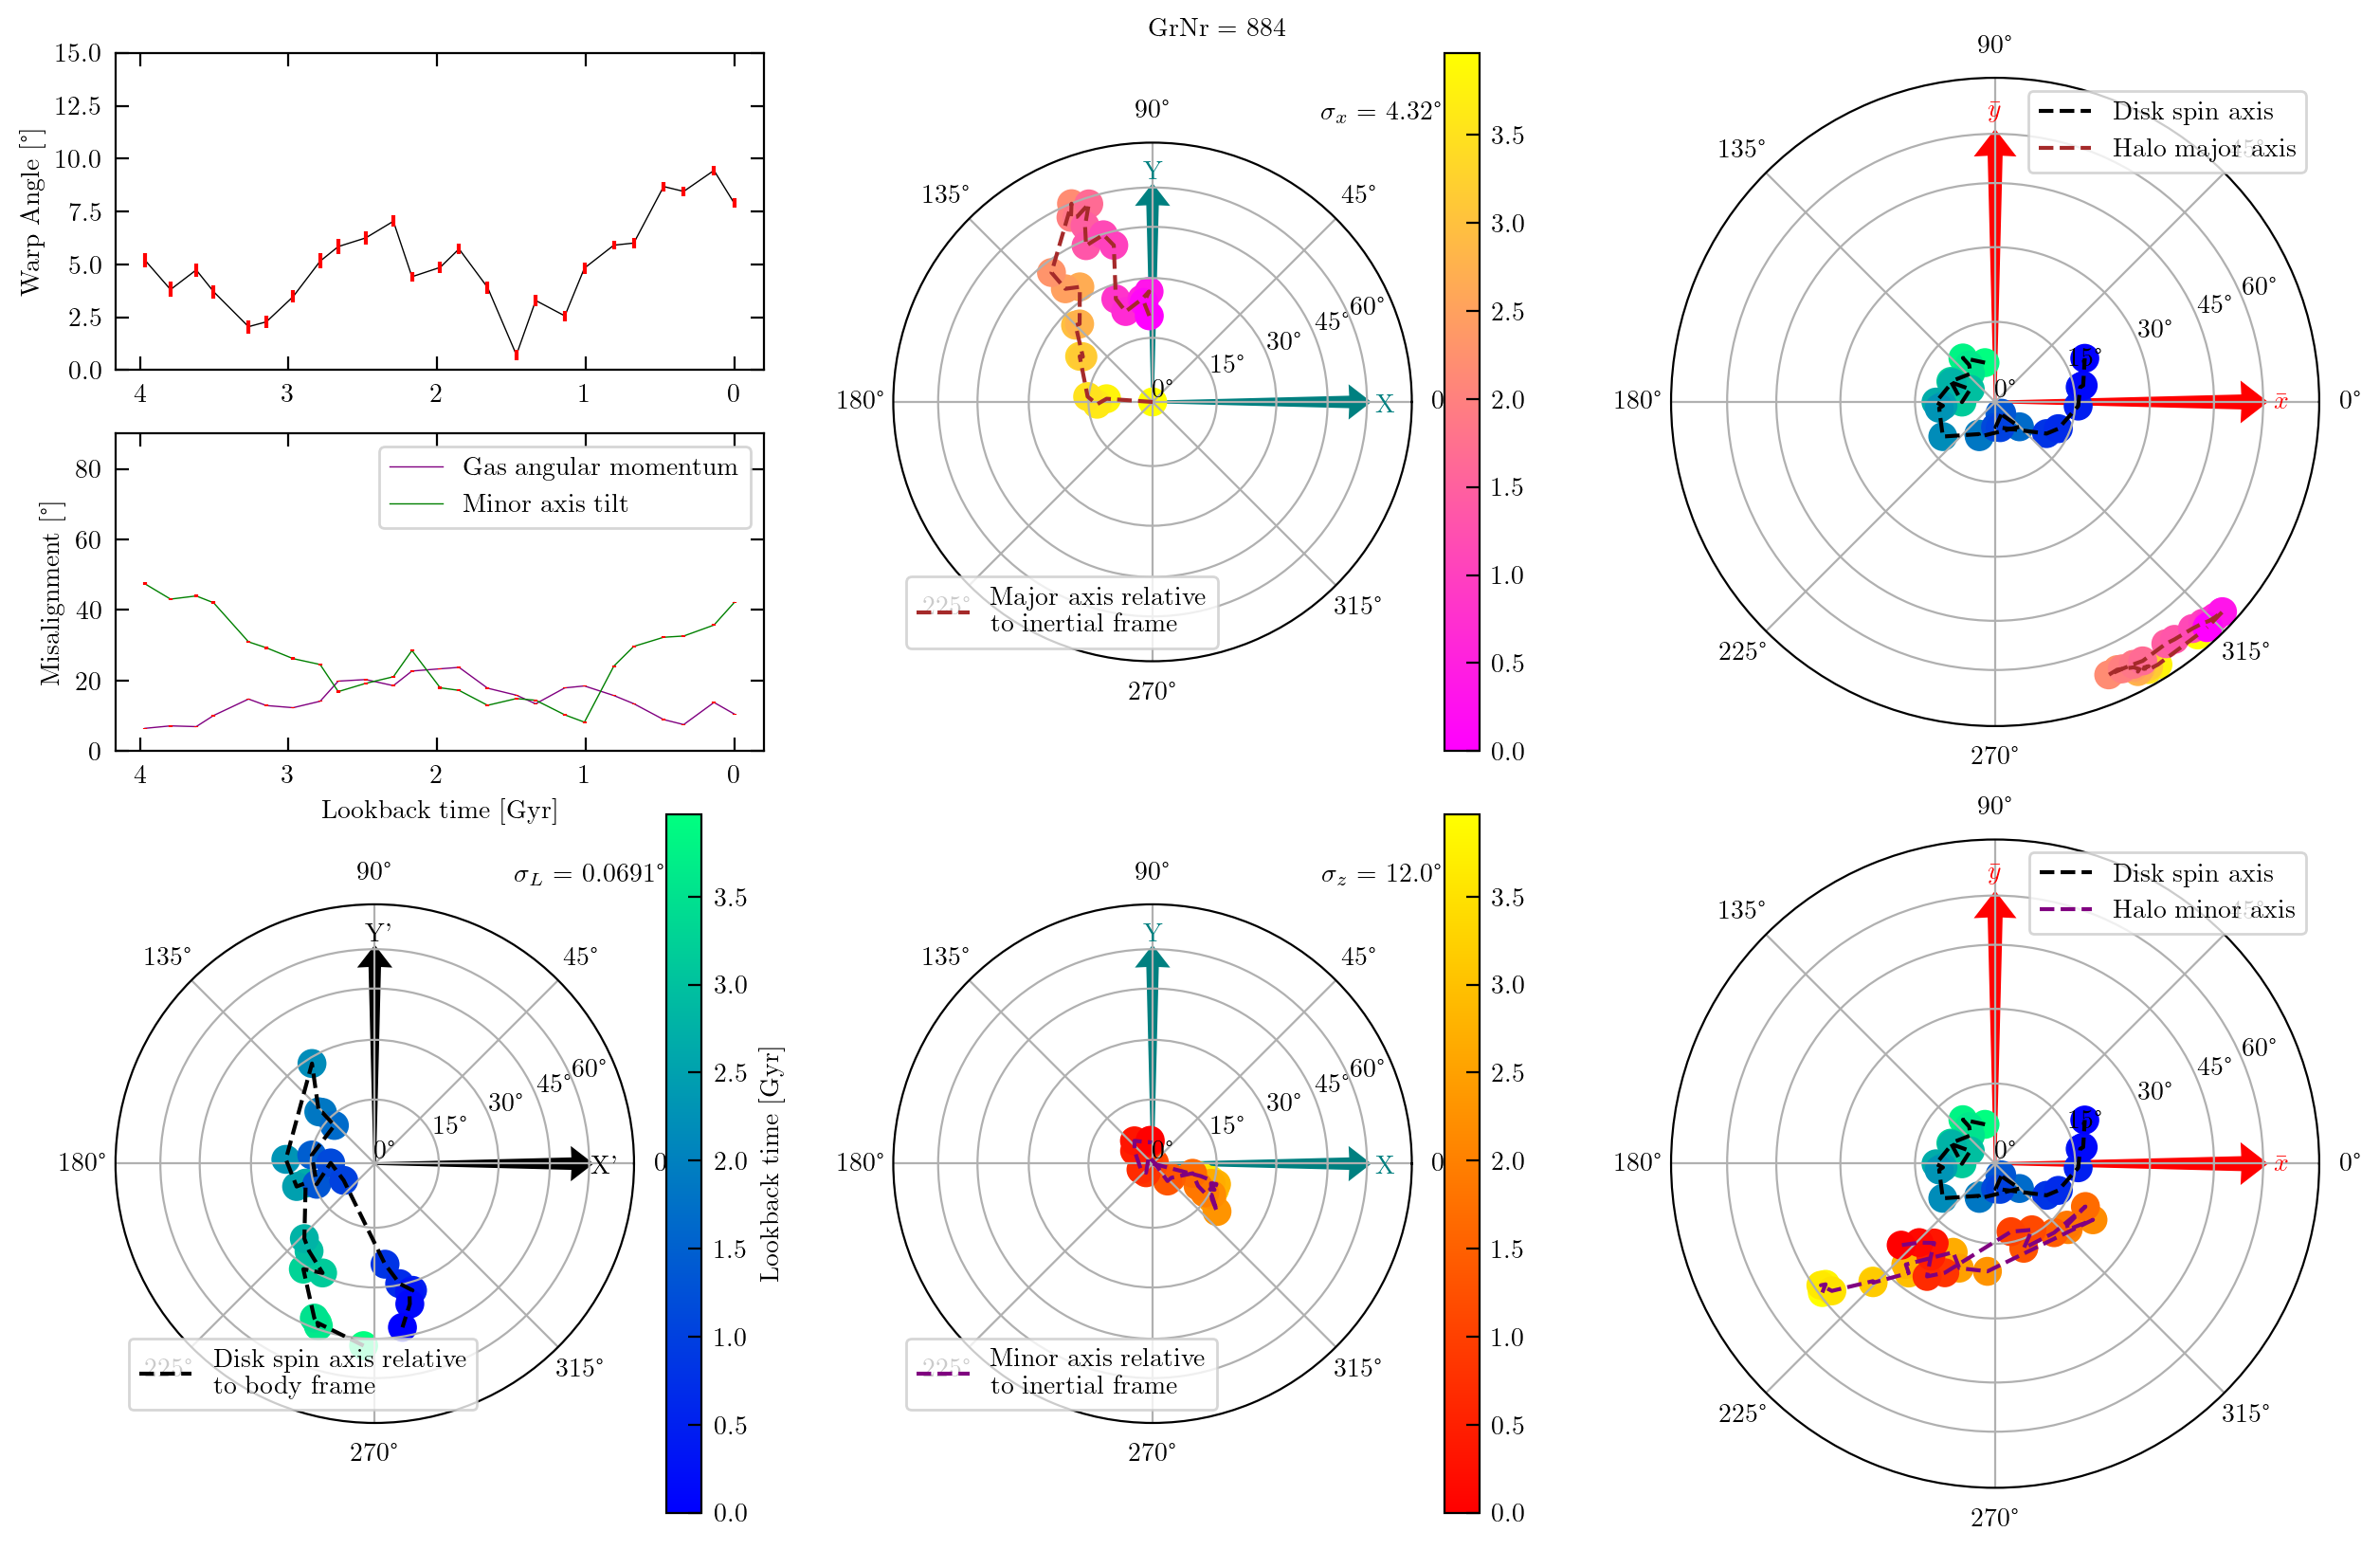

In [19]:
diskyidx = 9
fig = plt.figure(figsize=(15,10),frameon=True)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gs = gridspec.GridSpec(4,3)
plt.xticks([])
plt.yticks([])
GrNr = final_GrNr[diskyidx]
subfindID = final_diskyIDs[diskyidx]
rel_mag = warp_angles[diskyidx]
plt.title(f'GrNr = {GrNr}',fontsize = 10)

L_body_theta,L_body_phi = get_body_briggs(GrNr, subfindID, False)
x_body_theta,x_body_phi = get_x_briggs(GrNr, subfindID, False)
z_body_theta,z_body_phi = get_z_briggs(GrNr, subfindID, False)
L_theta_z,L_phi_z,z_theta_z,z_phi_z = get_minor_briggs(GrNr, subfindID, False)
L_theta_x,L_phi_x,z_theta_x,z_phi_x = get_major_briggs(GrNr, subfindID, False)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylim(0,15)
ax1.plot(snapshot_times, warp_angles[diskyidx], c='black', linewidth = 0.5)
ax1.errorbar(snapshot_times, warp_angles[diskyidx], yerr = warp_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax1.set_ylabel(r'Warp Angle [°]',fontsize = 10)
ax1.tick_params(labelsize=10)

ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
ax2.set_ylim(0,90)
ax2.plot(snapshot_times, gas_angles[diskyidx], c='purple', linewidth = 1/2,label='Gas angular momentum')
ax2.errorbar(snapshot_times, gas_angles[diskyidx], yerr = gas_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax2.plot(snapshot_times, z_angles[diskyidx], c='green', linewidth = 1/2,label='Minor axis tilt')
ax2.errorbar(snapshot_times, z_angles[diskyidx], yerr = z_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax2.xaxis.set_inverted(True)  
ax2.set_ylabel('Misalignment [°]',fontsize = 10)
ax2.legend(fontsize=10)
ax2.set_xlabel('Lookback time [Gyr]',fontsize = 10)
ax2.tick_params(labelsize=10)

ax4 = fig.add_subplot(gs[2:, 0],projection = 'polar')
ax4.plot(L_body_phi, np.sin(L_body_theta),c='black',linestyle = '--',label='Disk spin axis relative \n to body frame')
color_scatter = ax4.scatter(L_body_phi, np.sin(L_body_theta),c=snapshot_times,s=100,cmap='winter')
cbar = plt.colorbar(color_scatter)
cbar.ax.tick_params(labelsize = 10)
cbar.set_label('Lookback time [Gyr]',fontsize = 10)
ax4.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax4.tick_params(labelsize=10)
ax4.set_rlim([0,np.pi/3])
ax4.legend(fontsize=10)
ax4.text(1.06, 1.08, f'$\sigma_L$ = {truncate(np.mean(np.array([disk_phi_stds[diskyidx],disk_theta_stds[diskyidx]])),4)}°', 
        transform=ax4.transAxes, va='top', ha='right',fontsize = 10)
ax4.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.annotate("Y'", c='black',xy=(np.pi/2-np.pi/192,0.9),ha='center',fontsize = 10)
ax4.annotate("X'", c='black',xy=(-np.pi/192,0.87),va='center',fontsize = 10)

ax5 = fig.add_subplot(gs[:2,1],projection='polar')
ax5.plot(x_body_phi, np.sin(x_body_theta),c='brown',linestyle = '--',markersize=1,label='Major axis relative \n to inertial frame')
color_scatter = ax5.scatter(x_body_phi, np.sin(x_body_theta),c=snapshot_times,s=100,cmap='spring')
cbar = plt.colorbar(color_scatter)
cbar.ax.tick_params(labelsize = 10)
ax5.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax5.tick_params(labelsize=10)
ax5.set_rlim([0,np.pi/3])
ax5.legend(fontsize=10)
ax5.text(1.06, 1.08, f'$\sigma_x$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[0],2)}°', 
        transform=ax5.transAxes, va='top', ha='right',fontsize = 10)
ax5.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax5.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax6 = fig.add_subplot(gs[2:, 1],projection='polar')
ax6.plot(z_body_phi, np.sin(z_body_theta),c='purple',linestyle = '--',markersize=1,label='Minor axis relative \n to inertial frame')
color_scatter = ax6.scatter(z_body_phi, np.sin(z_body_theta),c=snapshot_times,s=100,cmap='autumn')
cbar = plt.colorbar(color_scatter)
cbar.ax.tick_params(labelsize = 10)
ax6.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax6.tick_params(labelsize=10)
ax6.set_rlim([0,np.pi/3])
ax6.legend(fontsize=10)
ax6.text(1.06, 1.08, f'$\sigma_z$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[1],1)}°', 
        transform=ax6.transAxes, va='top', ha='right',fontsize = 10)
ax6.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax6.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax7 = fig.add_subplot(gs[2:,2],projection='polar')
ax7.plot(L_phi_z, np.sin(L_theta_z),c='black',linestyle = '--',label='Disk spin axis')
ax7.scatter(L_phi_z, np.sin(L_theta_z),c=snapshot_times,s=100,cmap='winter')
ax7.plot(z_phi_z, np.sin(z_theta_z),c='purple',linestyle = '--',markersize=1,label='Halo minor axis')
ax7.scatter(z_phi_z, np.sin(z_theta_z),c=snapshot_times,s=100,cmap='autumn')
ax7.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax7.tick_params(labelsize=10)
ax7.set_rlim([0,np.pi/3])
ax7.legend(fontsize=10)
ax7.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax7.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

ax8 = fig.add_subplot(gs[:2,2],projection='polar')
ax8.plot(L_phi_x, np.sin(L_theta_x),c='black',linestyle = '--',label='Disk spin axis')
ax8.scatter(L_phi_x, np.sin(L_theta_x),c=snapshot_times,s=100,cmap='winter')
ax8.plot(z_phi_x, np.sin(z_theta_x),c='brown',linestyle = '--',markersize=1,label='Halo major axis')
ax8.scatter(z_phi_x, np.sin(z_theta_x),c=snapshot_times,s=100,cmap='spring')
ax8.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax8.tick_params(labelsize=10)
ax8.set_rlim([0,np.pi/3])
ax8.legend(fontsize=10)
ax8.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax8.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

Text(0, 0.9, '$\\bar{x}$')

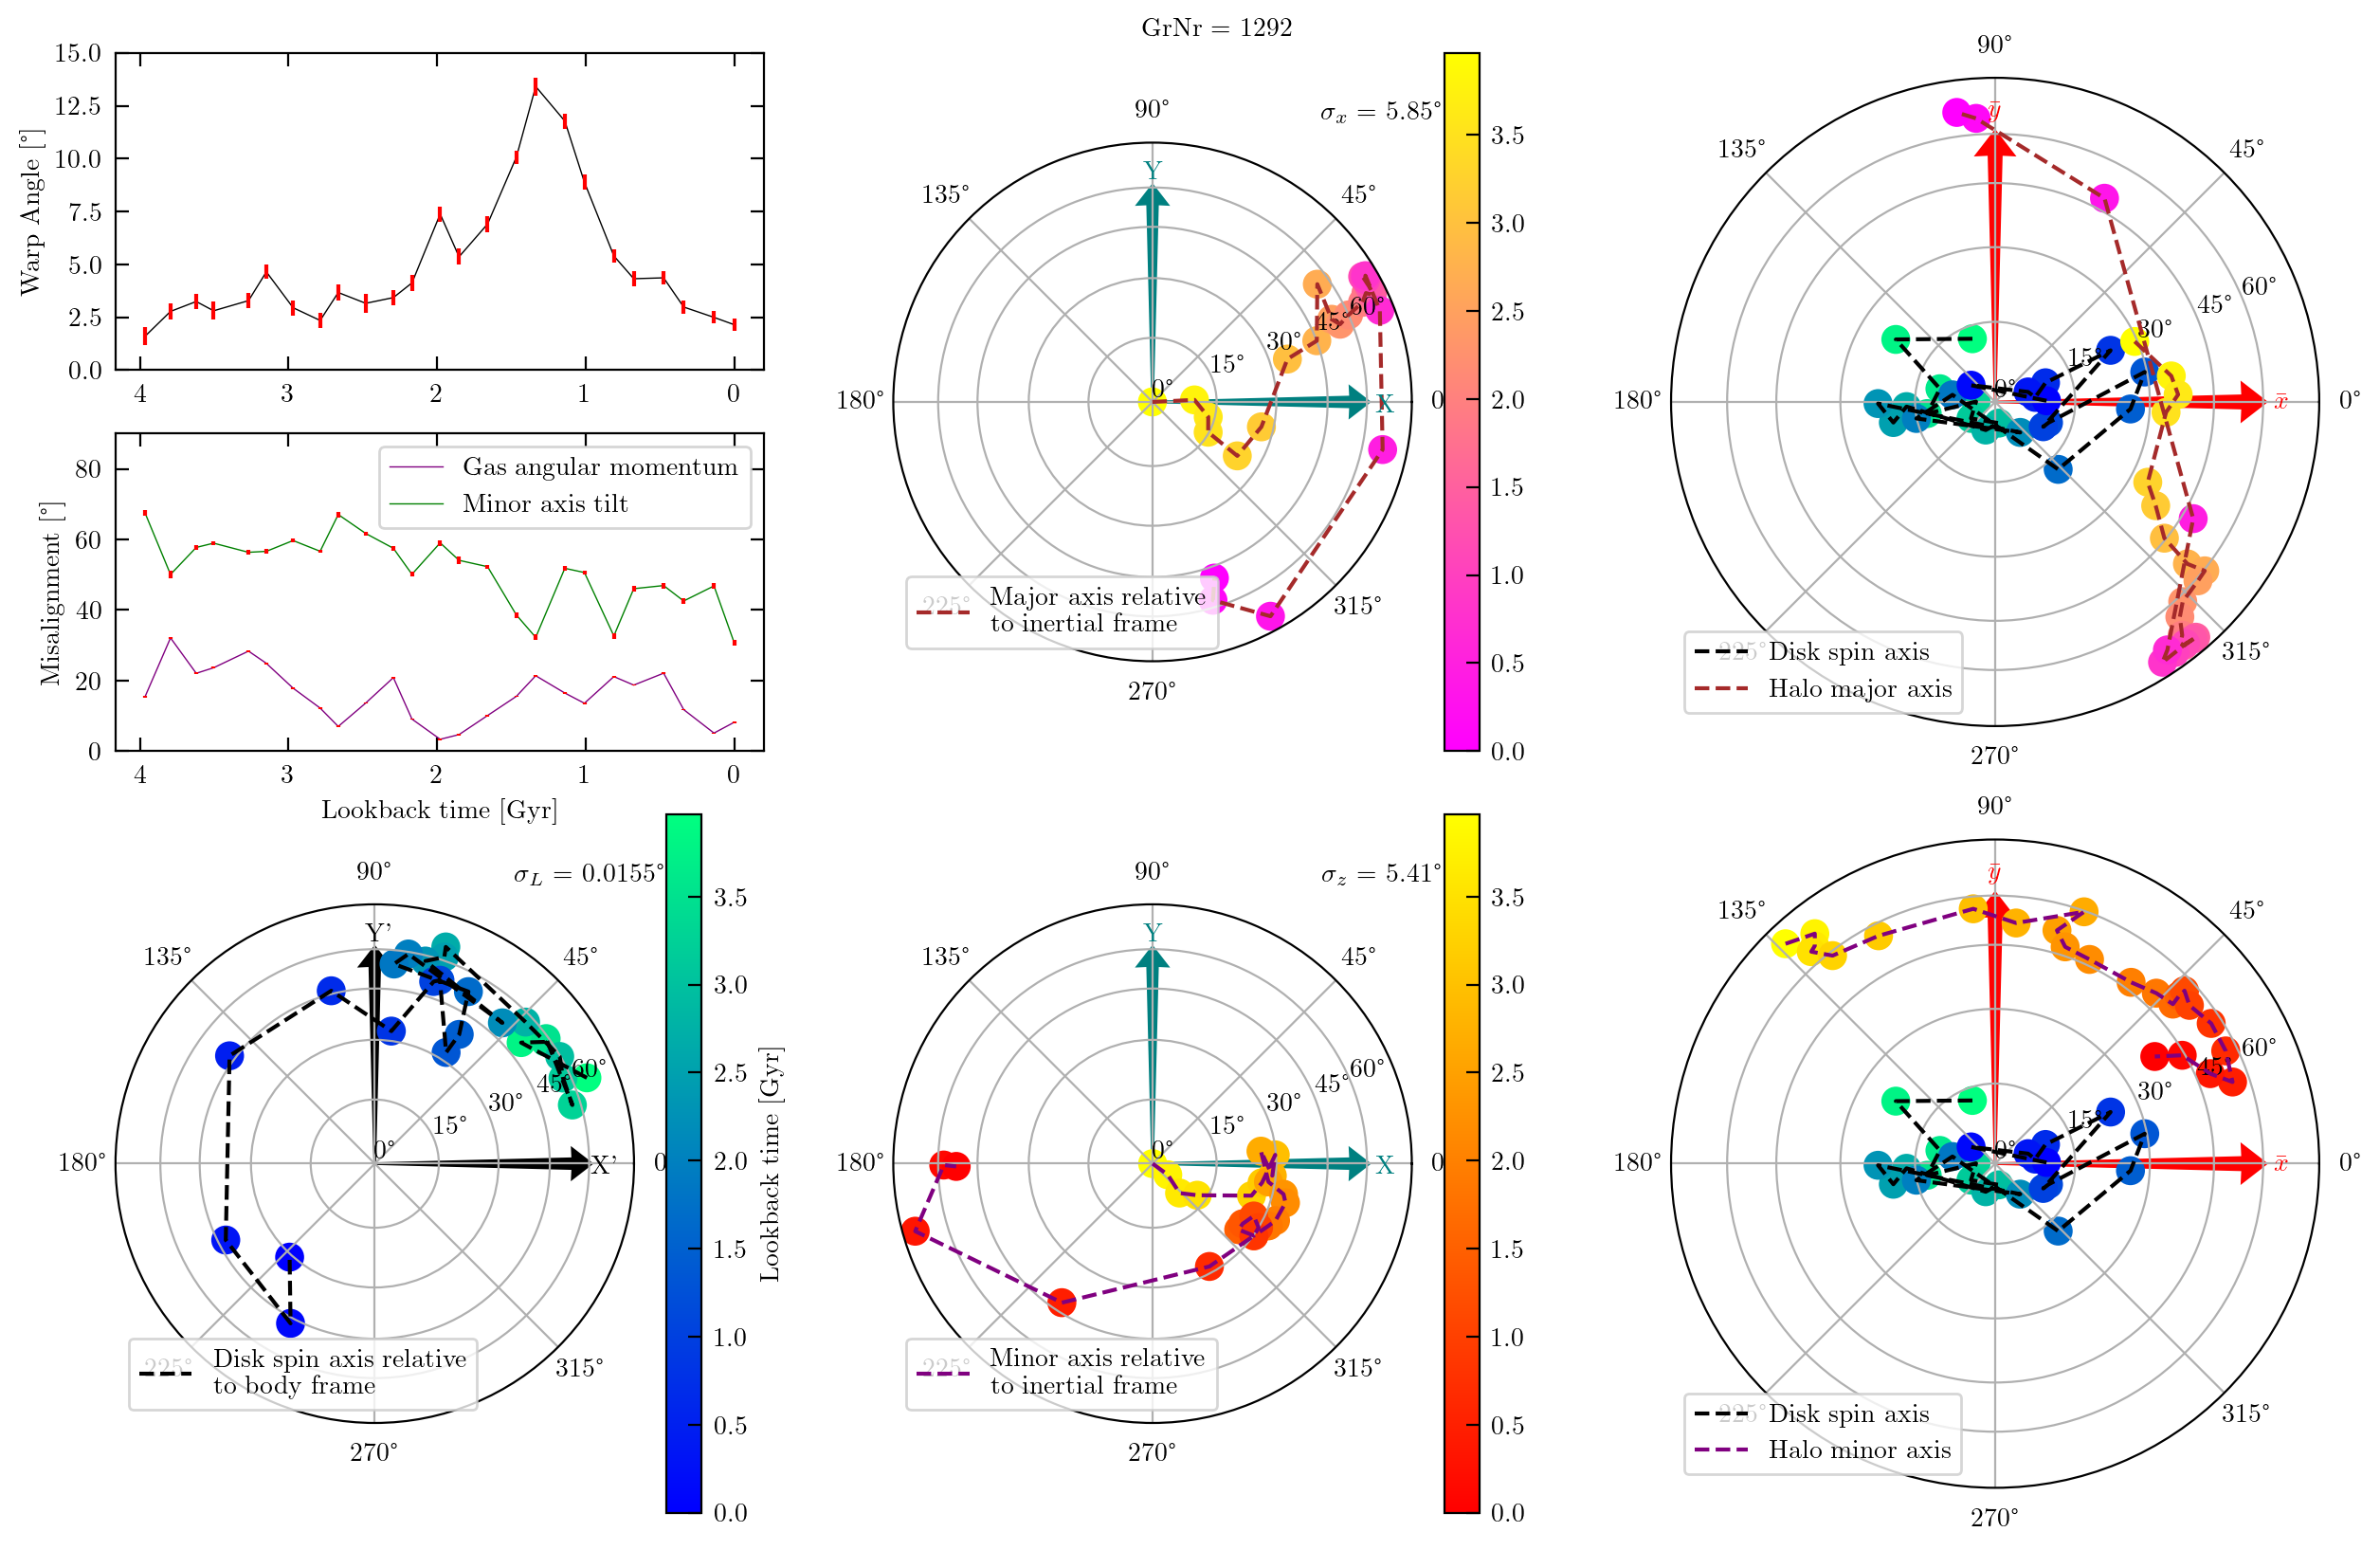

In [20]:
diskyidx = 23
fig = plt.figure(figsize=(15,10),frameon=True)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gs = gridspec.GridSpec(4,3)
plt.xticks([])
plt.yticks([])
GrNr = final_GrNr[diskyidx]
subfindID = final_diskyIDs[diskyidx]
rel_mag = warp_angles[diskyidx]
plt.title(f'GrNr = {GrNr}',fontsize = 10)

L_body_theta,L_body_phi = get_body_briggs(GrNr, subfindID, False)
x_body_theta,x_body_phi = get_x_briggs(GrNr, subfindID, False)
z_body_theta,z_body_phi = get_z_briggs(GrNr, subfindID, False)
L_theta_z,L_phi_z,z_theta_z,z_phi_z = get_minor_briggs(GrNr, subfindID, False)
L_theta_x,L_phi_x,z_theta_x,z_phi_x = get_major_briggs(GrNr, subfindID, False)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylim(0,15)
ax1.plot(snapshot_times, warp_angles[diskyidx], c='black', linewidth = 0.5)
ax1.errorbar(snapshot_times, warp_angles[diskyidx], yerr = warp_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax1.set_ylabel(r'Warp Angle [°]',fontsize = 10)
ax1.tick_params(labelsize=10)

ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
ax2.set_ylim(0,90)
ax2.plot(snapshot_times, gas_angles[diskyidx], c='purple', linewidth = 1/2,label='Gas angular momentum')
ax2.errorbar(snapshot_times, gas_angles[diskyidx], yerr = gas_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax2.plot(snapshot_times, z_angles[diskyidx], c='green', linewidth = 1/2,label='Minor axis tilt')
ax2.errorbar(snapshot_times, z_angles[diskyidx], yerr = z_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax2.xaxis.set_inverted(True)  
ax2.set_ylabel('Misalignment [°]',fontsize = 10)
ax2.legend(fontsize=10)
ax2.set_xlabel('Lookback time [Gyr]',fontsize = 10)
ax2.tick_params(labelsize=10)

ax4 = fig.add_subplot(gs[2:, 0],projection = 'polar')
ax4.plot(L_body_phi, np.sin(L_body_theta),c='black',linestyle = '--',label='Disk spin axis relative \n to body frame')
color_scatter = ax4.scatter(L_body_phi, np.sin(L_body_theta),c=snapshot_times,s=100,cmap='winter')
cbar = plt.colorbar(color_scatter)
cbar.ax.tick_params(labelsize = 10)
cbar.set_label('Lookback time [Gyr]',fontsize = 10)
ax4.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax4.tick_params(labelsize=10)
ax4.set_rlim([0,np.pi/3])
ax4.legend(fontsize=10)
ax4.text(1.06, 1.08, f'$\sigma_L$ = {truncate(np.mean(np.array([disk_phi_stds[diskyidx],disk_theta_stds[diskyidx]])),4)}°', 
        transform=ax4.transAxes, va='top', ha='right',fontsize = 10)
ax4.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.annotate("Y'", c='black',xy=(np.pi/2-np.pi/192,0.9),ha='center',fontsize = 10)
ax4.annotate("X'", c='black',xy=(-np.pi/192,0.87),va='center',fontsize = 10)

ax5 = fig.add_subplot(gs[:2,1],projection='polar')
ax5.plot(x_body_phi, np.sin(x_body_theta),c='brown',linestyle = '--',markersize=1,label='Major axis relative \n to inertial frame')
color_scatter = ax5.scatter(x_body_phi, np.sin(x_body_theta),c=snapshot_times,s=100,cmap='spring')
cbar = plt.colorbar(color_scatter)
cbar.ax.tick_params(labelsize = 10)
ax5.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax5.tick_params(labelsize=10)
ax5.set_rlim([0,np.pi/3])
ax5.legend(fontsize=10)
ax5.text(1.06, 1.08, f'$\sigma_x$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[0],2)}°', 
        transform=ax5.transAxes, va='top', ha='right',fontsize = 10)
ax5.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax5.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax6 = fig.add_subplot(gs[2:, 1],projection='polar')
ax6.plot(z_body_phi, np.sin(z_body_theta),c='purple',linestyle = '--',markersize=1,label='Minor axis relative \n to inertial frame')
color_scatter = ax6.scatter(z_body_phi, np.sin(z_body_theta),c=snapshot_times,s=100,cmap='autumn')
cbar = plt.colorbar(color_scatter)
cbar.ax.tick_params(labelsize = 10)
ax6.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax6.tick_params(labelsize=10)
ax6.set_rlim([0,np.pi/3])
ax6.legend(fontsize=10)
ax6.text(1.06, 1.08, f'$\sigma_z$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[1],2)}°', 
        transform=ax6.transAxes, va='top', ha='right',fontsize = 10)
ax6.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax6.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax7 = fig.add_subplot(gs[2:,2],projection='polar')
ax7.plot(L_phi_z, np.sin(L_theta_z),c='black',linestyle = '--',label='Disk spin axis')
ax7.scatter(L_phi_z, np.sin(L_theta_z),c=snapshot_times,s=100,cmap='winter')
ax7.plot(z_phi_z, np.sin(z_theta_z),c='purple',linestyle = '--',markersize=1,label='Halo minor axis')
ax7.scatter(z_phi_z, np.sin(z_theta_z),c=snapshot_times,s=100,cmap='autumn')
ax7.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax7.tick_params(labelsize=10)
ax7.set_rlim([0,np.pi/3])
ax7.legend(fontsize=10)
ax7.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax7.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

ax8 = fig.add_subplot(gs[:2,2],projection='polar')
ax8.plot(L_phi_x, np.sin(L_theta_x),c='black',linestyle = '--',label='Disk spin axis')
ax8.scatter(L_phi_x, np.sin(L_theta_x),c=snapshot_times,s=100,cmap='winter')
ax8.plot(z_phi_x, np.sin(z_theta_x),c='brown',linestyle = '--',markersize=1,label='Halo major axis')
ax8.scatter(z_phi_x, np.sin(z_theta_x),c=snapshot_times,s=100,cmap='spring')
ax8.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax8.tick_params(labelsize=10)
ax8.set_rlim([0,np.pi/3])
ax8.legend(fontsize=10)
ax8.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax8.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

Text(0, 0.9, '$\\bar{x}$')

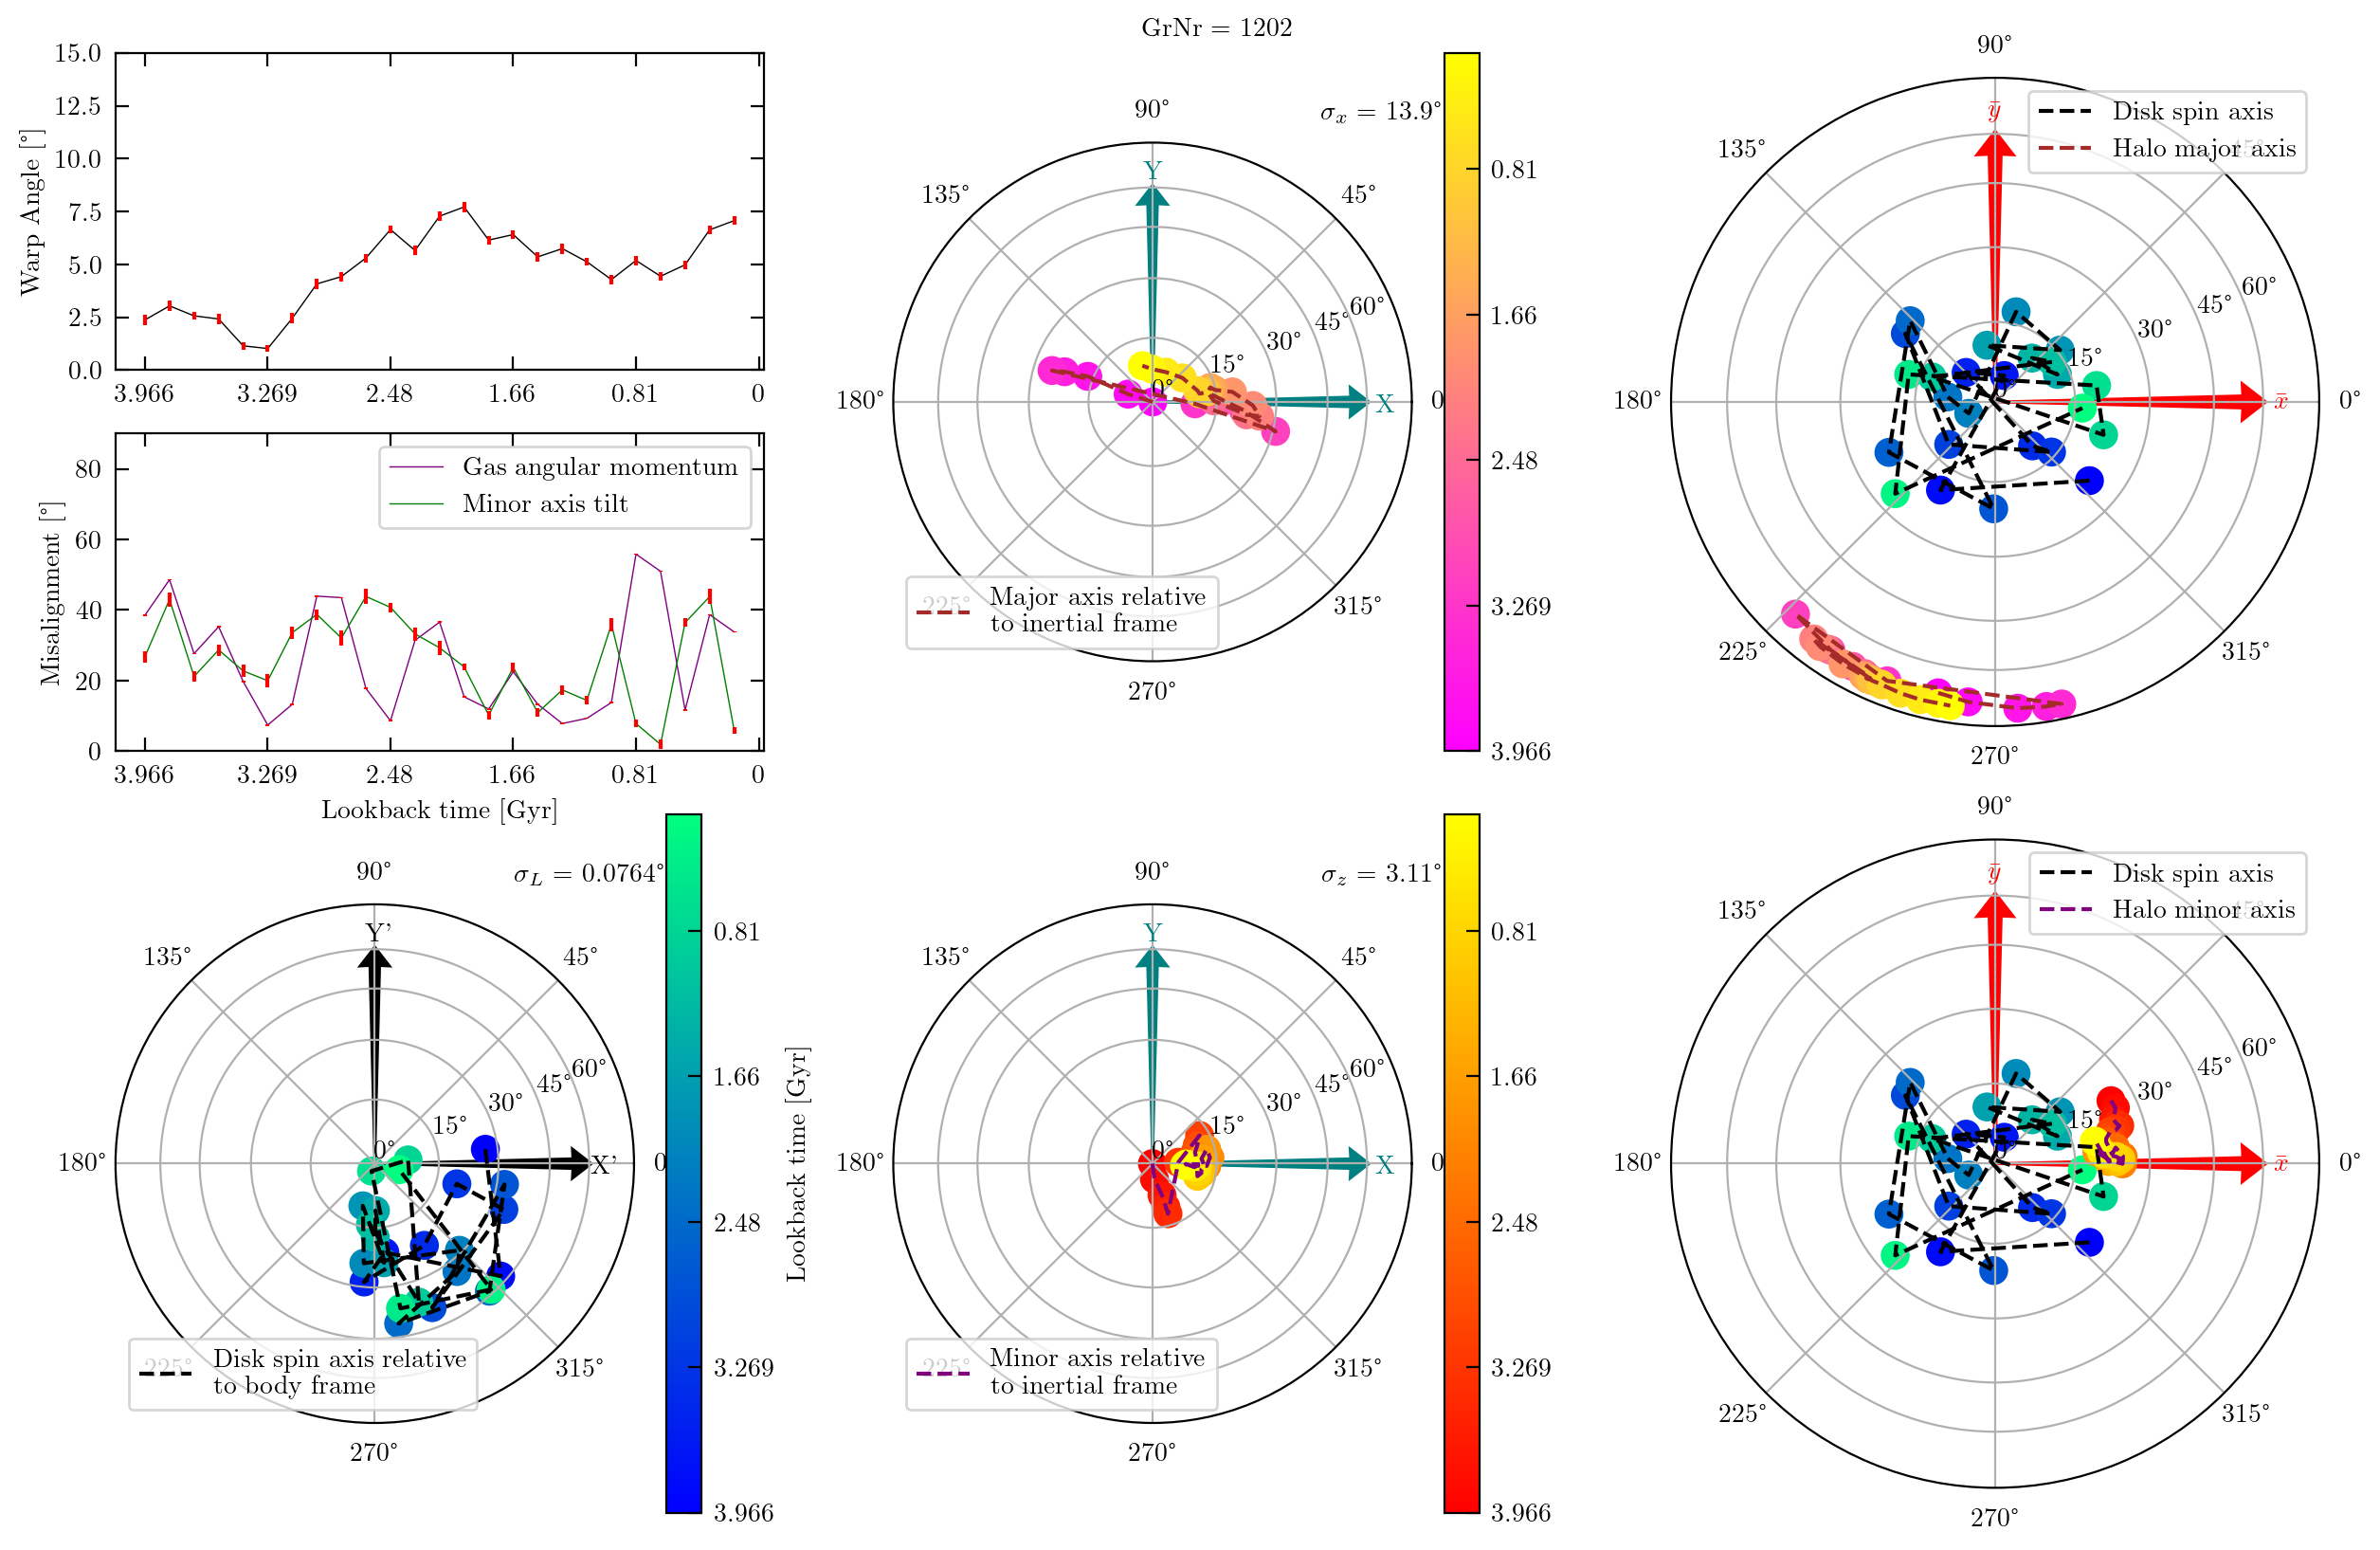

In [18]:
diskyidx = 20
fig = plt.figure(figsize=(15,10),frameon=True)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gs = gridspec.GridSpec(4,3)
plt.xticks([])
plt.yticks([])
GrNr = final_GrNr[diskyidx]
subfindID = final_diskyIDs[diskyidx]
rel_mag = warp_angles[diskyidx]
plt.title(f'GrNr = {GrNr}',fontsize = 10)

L_body_theta,L_body_phi = get_body_briggs(GrNr, subfindID, False)
x_body_theta,x_body_phi = get_x_briggs(GrNr, subfindID, False)
z_body_theta,z_body_phi = get_z_briggs(GrNr, subfindID, False)
L_theta_z,L_phi_z,z_theta_z,z_phi_z = get_minor_briggs(GrNr, subfindID, False)
L_theta_x,L_phi_x,z_theta_x,z_phi_x = get_major_briggs(GrNr, subfindID, False)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylim(0,15)
ax1.plot(snapshot_times, warp_angles[diskyidx], c='black', linewidth = 0.5)
ax1.errorbar(snapshot_times, warp_angles[diskyidx], yerr = warp_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax1.set_ylabel(r'Warp Angle [°]',fontsize = 10)
ax1.tick_params(labelsize=10)

ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
ax2.set_ylim(0,90)
ax2.plot(snapshot_times, gas_angles[diskyidx], c='purple', linewidth = 1/2,label='Gas angular momentum')
ax2.errorbar(snapshot_times, gas_angles[diskyidx], yerr = gas_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax2.plot(snapshot_times, z_angles[diskyidx], c='green', linewidth = 1/2,label='Minor axis tilt')
ax2.errorbar(snapshot_times, z_angles[diskyidx], yerr = z_angles_stds[diskyidx],fmt='none',ecolor='red') 

ax2.set_ylabel('Misalignment [°]',fontsize = 10)
ax2.legend(fontsize=10)
ax2.set_xlabel('Lookback time [Gyr]',fontsize = 10)
ax2.tick_params(labelsize=10)

ax4 = fig.add_subplot(gs[2:, 0],projection = 'polar')
ax4.plot(L_body_phi, np.sin(L_body_theta),c='black',linestyle = '--',label='Disk spin axis relative \n to body frame')
color_scatter = ax4.scatter(L_body_phi, np.sin(L_body_theta),c=np.arange(len(L_body_phi)),s=100,cmap='winter')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
cbar.set_label('Lookback time [Gyr]',fontsize = 10)
ax4.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax4.tick_params(labelsize=10)
ax4.set_rlim([0,np.pi/3])
ax4.legend(fontsize=10)
ax4.text(1.06, 1.08, f'$\sigma_L$ = {truncate(np.mean(np.array([disk_phi_stds[diskyidx],disk_theta_stds[diskyidx]])),4)}°', 
        transform=ax4.transAxes, va='top', ha='right',fontsize = 10)
ax4.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.annotate("Y'", c='black',xy=(np.pi/2-np.pi/192,0.9),ha='center',fontsize = 10)
ax4.annotate("X'", c='black',xy=(-np.pi/192,0.87),va='center',fontsize = 10)

ax5 = fig.add_subplot(gs[:2,1],projection='polar')
ax5.plot(x_body_phi, np.sin(x_body_theta),c='brown',linestyle = '--',markersize=1,label='Major axis relative \n to inertial frame')
color_scatter = ax5.scatter(x_body_phi, np.sin(x_body_theta),c=np.arange(len(x_body_phi)),s=100,cmap='spring')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
ax5.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax5.tick_params(labelsize=10)
ax5.set_rlim([0,np.pi/3])
ax5.legend(fontsize=10)
ax5.text(1.06, 1.08, f'$\sigma_x$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[0],1)}°', 
        transform=ax5.transAxes, va='top', ha='right',fontsize = 10)
ax5.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax5.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax6 = fig.add_subplot(gs[2:, 1],projection='polar')
ax6.plot(z_body_phi, np.sin(z_body_theta),c='purple',linestyle = '--',markersize=1,label='Minor axis relative \n to inertial frame')
color_scatter = ax6.scatter(z_body_phi, np.sin(z_body_theta),c=np.arange(len(z_body_phi)),s=100,cmap='autumn')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
ax6.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax6.tick_params(labelsize=10)
ax6.set_rlim([0,np.pi/3])
ax6.legend(fontsize=10)
ax6.text(1.06, 1.08, f'$\sigma_z$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[1],2)}°', 
        transform=ax6.transAxes, va='top', ha='right',fontsize = 10)
ax6.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax6.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax7 = fig.add_subplot(gs[2:,2],projection='polar')
ax7.plot(L_phi_z, np.sin(L_theta_z),c='black',linestyle = '--',label='Disk spin axis')
ax7.scatter(L_phi_z, np.sin(L_theta_z),c=np.arange(len(L_phi_z)),s=100,cmap='winter')
ax7.plot(z_phi_z, np.sin(z_theta_z),c='purple',linestyle = '--',markersize=1,label='Halo minor axis')
ax7.scatter(z_phi_z, np.sin(z_theta_z),c=np.arange(len(z_phi_z)),s=100,cmap='autumn')
ax7.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax7.tick_params(labelsize=10)
ax7.set_rlim([0,np.pi/3])
ax7.legend(fontsize=10)
ax7.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax7.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

ax8 = fig.add_subplot(gs[:2,2],projection='polar')
ax8.plot(L_phi_x, np.sin(L_theta_x),c='black',linestyle = '--',label='Disk spin axis')
ax8.scatter(L_phi_x, np.sin(L_theta_x),c=np.arange(len(L_phi_x)),s=100,cmap='winter')
ax8.plot(z_phi_x, np.sin(z_theta_x),c='brown',linestyle = '--',markersize=1,label='Halo major axis')
ax8.scatter(z_phi_x, np.sin(z_theta_x),c=np.arange(len(z_phi_x)),s=100,cmap='spring')
ax8.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax8.tick_params(labelsize=10)
ax8.set_rlim([0,np.pi/3])
ax8.legend(fontsize=10)
ax8.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax8.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

Text(0, 0.9, '$\\bar{x}$')

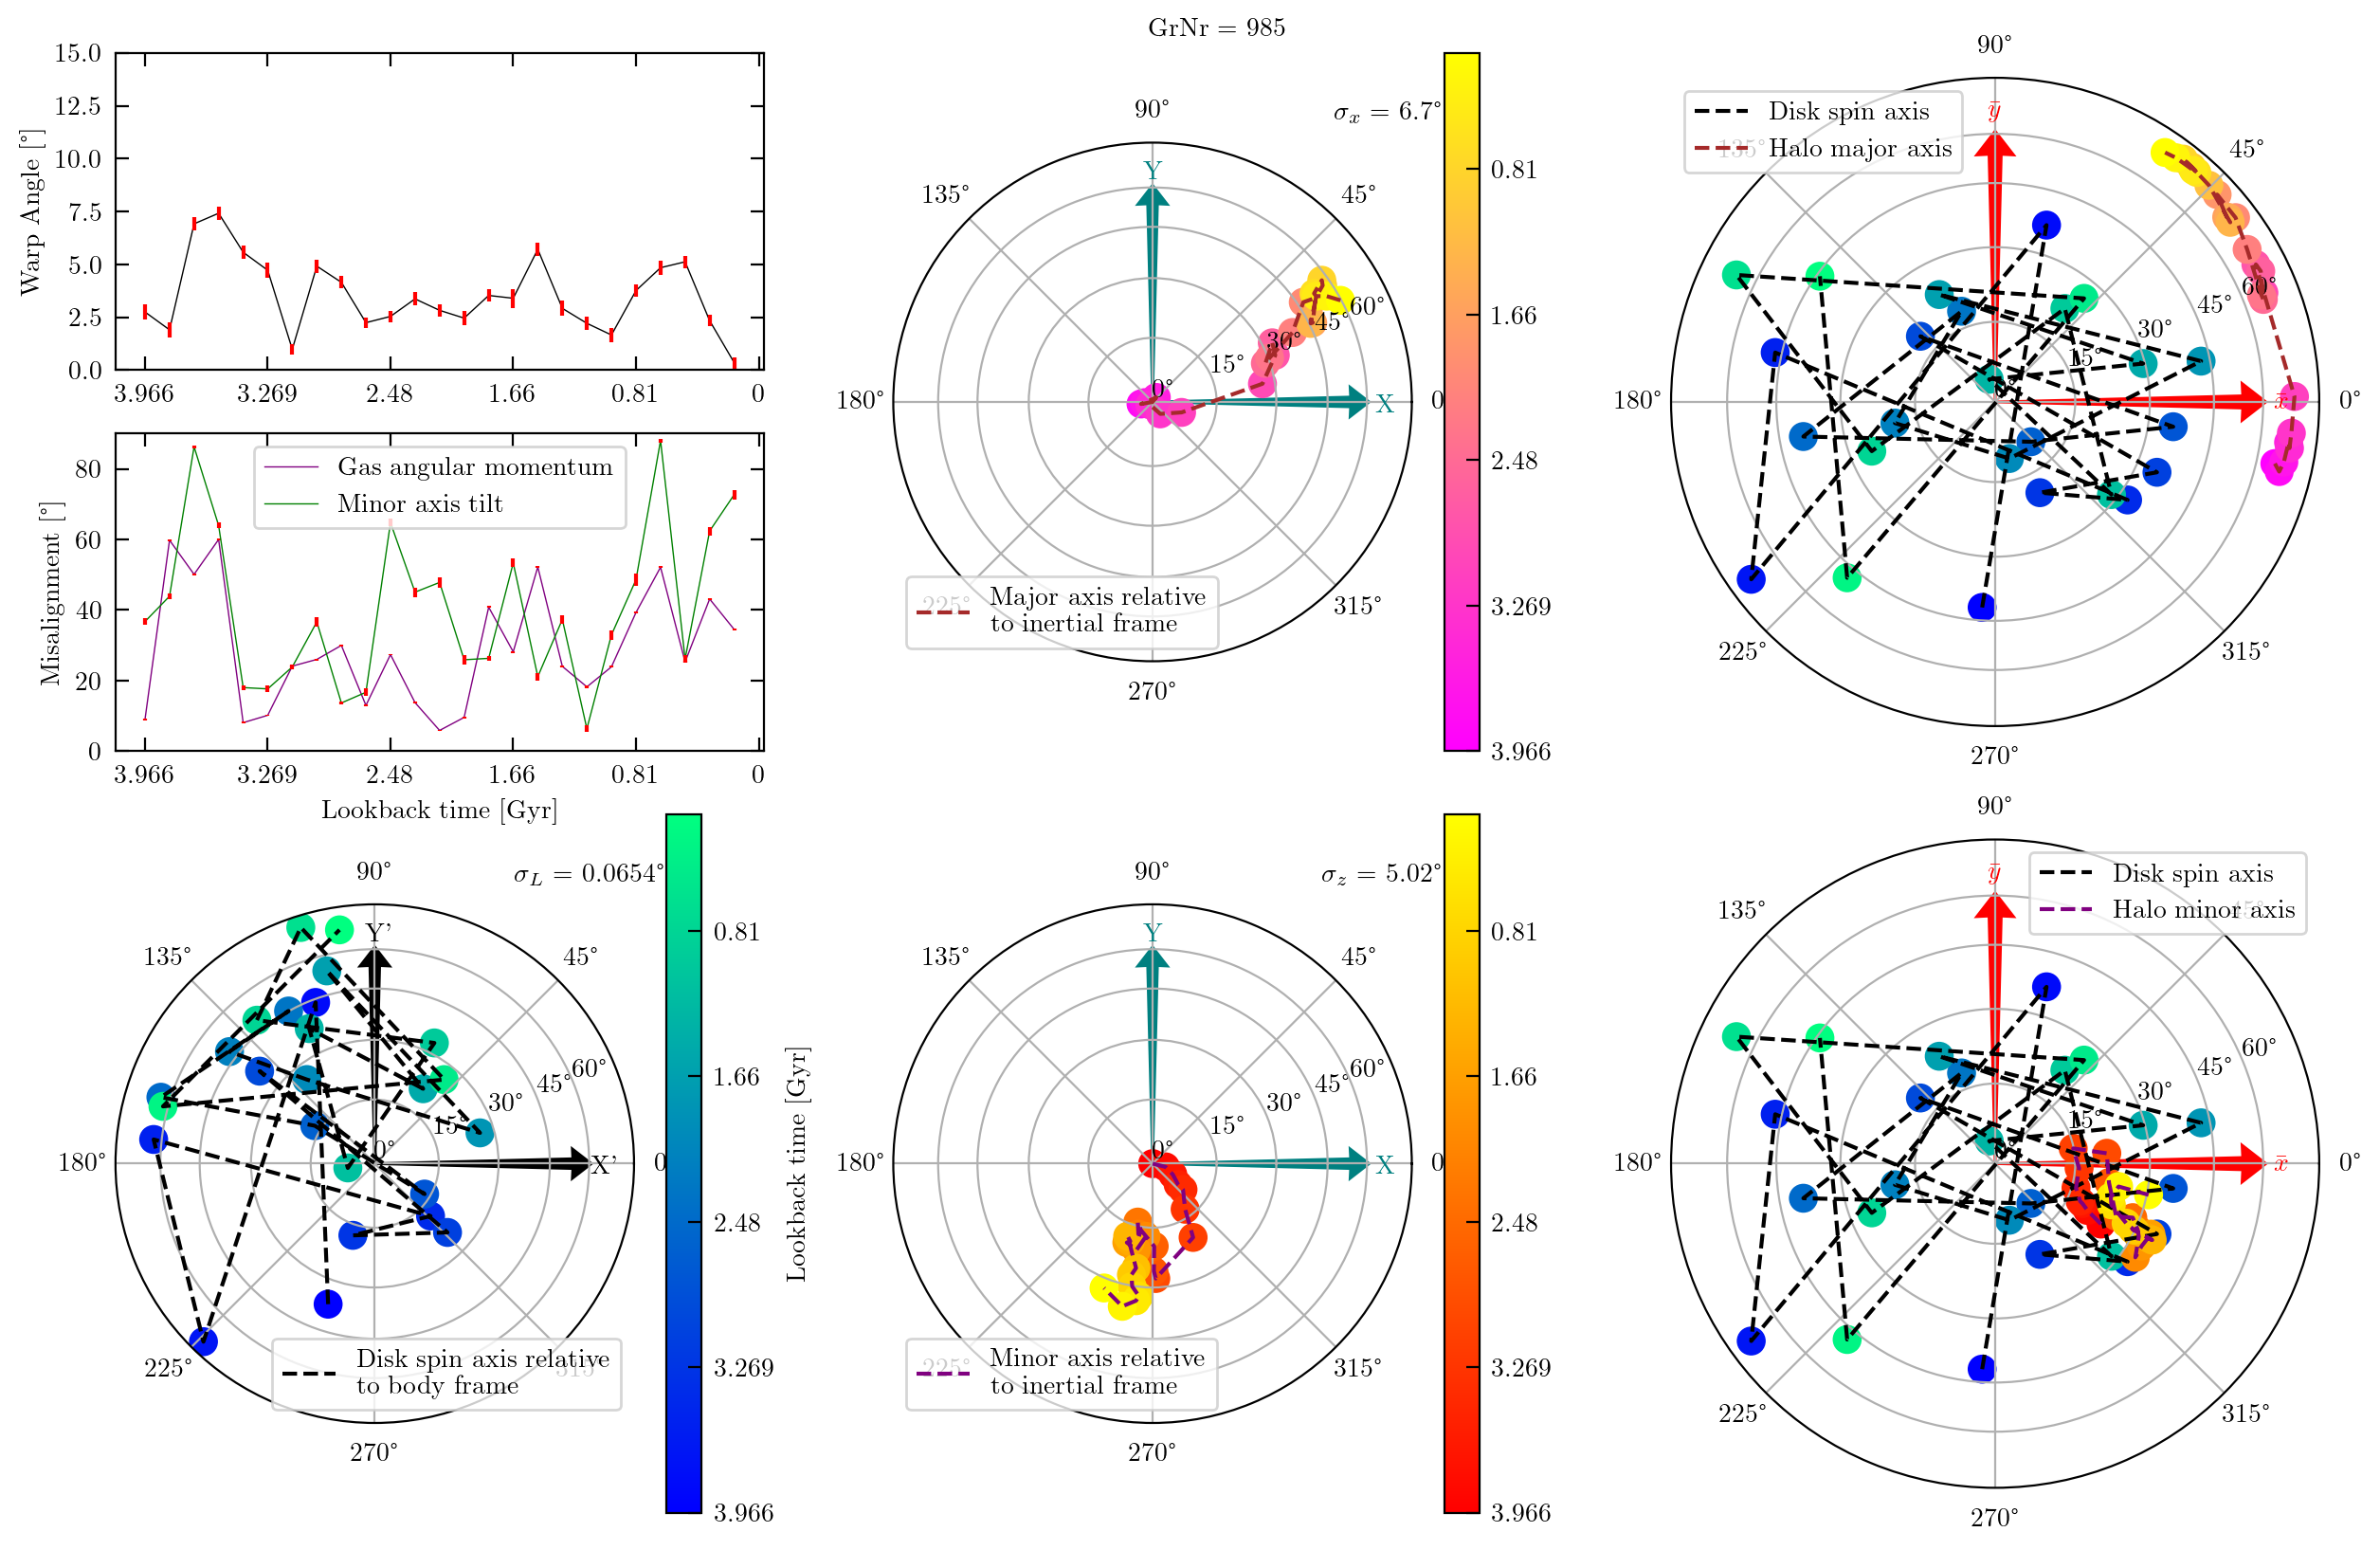

In [19]:
diskyidx = 11
fig = plt.figure(figsize=(15,10),frameon=True)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gs = gridspec.GridSpec(4,3)
plt.xticks([])
plt.yticks([])
GrNr = final_GrNr[diskyidx]
subfindID = final_diskyIDs[diskyidx]
rel_mag = warp_angles[diskyidx]
plt.title(f'GrNr = {GrNr}',fontsize = 10)

L_body_theta,L_body_phi = get_body_briggs(GrNr, subfindID, False)
x_body_theta,x_body_phi = get_x_briggs(GrNr, subfindID, False)
z_body_theta,z_body_phi = get_z_briggs(GrNr, subfindID, False)
L_theta_z,L_phi_z,z_theta_z,z_phi_z = get_minor_briggs(GrNr, subfindID, False)
L_theta_x,L_phi_x,z_theta_x,z_phi_x = get_major_briggs(GrNr, subfindID, False)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylim(0,15)
ax1.plot(snapshot_times, warp_angles[diskyidx], c='black', linewidth = 0.5)
ax1.errorbar(snapshot_times, warp_angles[diskyidx], yerr = warp_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax1.set_ylabel(r'Warp Angle [°]',fontsize = 10)
ax1.tick_params(labelsize=10)

ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
ax2.set_ylim(0,90)
ax2.plot(snapshot_times, gas_angles[diskyidx], c='purple', linewidth = 1/2,label='Gas angular momentum')
ax2.errorbar(snapshot_times, gas_angles[diskyidx], yerr = gas_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax2.plot(snapshot_times, z_angles[diskyidx], c='green', linewidth = 1/2,label='Minor axis tilt')
ax2.errorbar(snapshot_times, z_angles[diskyidx], yerr = z_angles_stds[diskyidx],fmt='none',ecolor='red') 

ax2.set_ylabel('Misalignment [°]',fontsize = 10)
ax2.legend(fontsize=10)
ax2.set_xlabel('Lookback time [Gyr]',fontsize = 10)
ax2.tick_params(labelsize=10)

ax4 = fig.add_subplot(gs[2:, 0],projection = 'polar')
ax4.plot(L_body_phi, np.sin(L_body_theta),c='black',linestyle = '--',label='Disk spin axis relative \n to body frame')
color_scatter = ax4.scatter(L_body_phi, np.sin(L_body_theta),c=np.arange(len(L_body_phi)),s=100,cmap='winter')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
cbar.set_label('Lookback time [Gyr]',fontsize = 10)
ax4.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax4.tick_params(labelsize=10)
ax4.set_rlim([0,np.pi/3])
ax4.legend(fontsize=10)
ax4.text(1.06, 1.08, f'$\sigma_L$ = {truncate(np.mean(np.array([disk_phi_stds[diskyidx],disk_theta_stds[diskyidx]])),4)}°', 
        transform=ax4.transAxes, va='top', ha='right',fontsize = 10)
ax4.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.annotate("Y'", c='black',xy=(np.pi/2-np.pi/192,0.9),ha='center',fontsize = 10)
ax4.annotate("X'", c='black',xy=(-np.pi/192,0.87),va='center',fontsize = 10)

ax5 = fig.add_subplot(gs[:2,1],projection='polar')
ax5.plot(x_body_phi, np.sin(x_body_theta),c='brown',linestyle = '--',markersize=1,label='Major axis relative \n to inertial frame')
color_scatter = ax5.scatter(x_body_phi, np.sin(x_body_theta),c=np.arange(len(x_body_phi)),s=100,cmap='spring')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
ax5.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax5.tick_params(labelsize=10)
ax5.set_rlim([0,np.pi/3])
ax5.legend(fontsize=10)
ax5.text(1.06, 1.08, f'$\sigma_x$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[0],1)}°', 
        transform=ax5.transAxes, va='top', ha='right',fontsize = 10)
ax5.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax5.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax6 = fig.add_subplot(gs[2:, 1],projection='polar')
ax6.plot(z_body_phi, np.sin(z_body_theta),c='purple',linestyle = '--',markersize=1,label='Minor axis relative \n to inertial frame')
color_scatter = ax6.scatter(z_body_phi, np.sin(z_body_theta),c=np.arange(len(z_body_phi)),s=100,cmap='autumn')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
ax6.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax6.tick_params(labelsize=10)
ax6.set_rlim([0,np.pi/3])
ax6.legend(fontsize=10)
ax6.text(1.06, 1.08, f'$\sigma_z$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[1],2)}°', 
        transform=ax6.transAxes, va='top', ha='right',fontsize = 10)
ax6.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax6.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax7 = fig.add_subplot(gs[2:,2],projection='polar')
ax7.plot(L_phi_z, np.sin(L_theta_z),c='black',linestyle = '--',label='Disk spin axis')
ax7.scatter(L_phi_z, np.sin(L_theta_z),c=np.arange(len(L_phi_z)),s=100,cmap='winter')
ax7.plot(z_phi_z, np.sin(z_theta_z),c='purple',linestyle = '--',markersize=1,label='Halo minor axis')
ax7.scatter(z_phi_z, np.sin(z_theta_z),c=np.arange(len(z_phi_z)),s=100,cmap='autumn')
ax7.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax7.tick_params(labelsize=10)
ax7.set_rlim([0,np.pi/3])
ax7.legend(fontsize=10)
ax7.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax7.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

ax8 = fig.add_subplot(gs[:2,2],projection='polar')
ax8.plot(L_phi_x, np.sin(L_theta_x),c='black',linestyle = '--',label='Disk spin axis')
ax8.scatter(L_phi_x, np.sin(L_theta_x),c=np.arange(len(L_phi_x)),s=100,cmap='winter')
ax8.plot(z_phi_x, np.sin(z_theta_x),c='brown',linestyle = '--',markersize=1,label='Halo major axis')
ax8.scatter(z_phi_x, np.sin(z_theta_x),c=np.arange(len(z_phi_x)),s=100,cmap='spring')
ax8.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax8.tick_params(labelsize=10)
ax8.set_rlim([0,np.pi/3])
ax8.legend(fontsize=10)
ax8.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax8.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

Text(0, 0.9, '$\\bar{x}$')

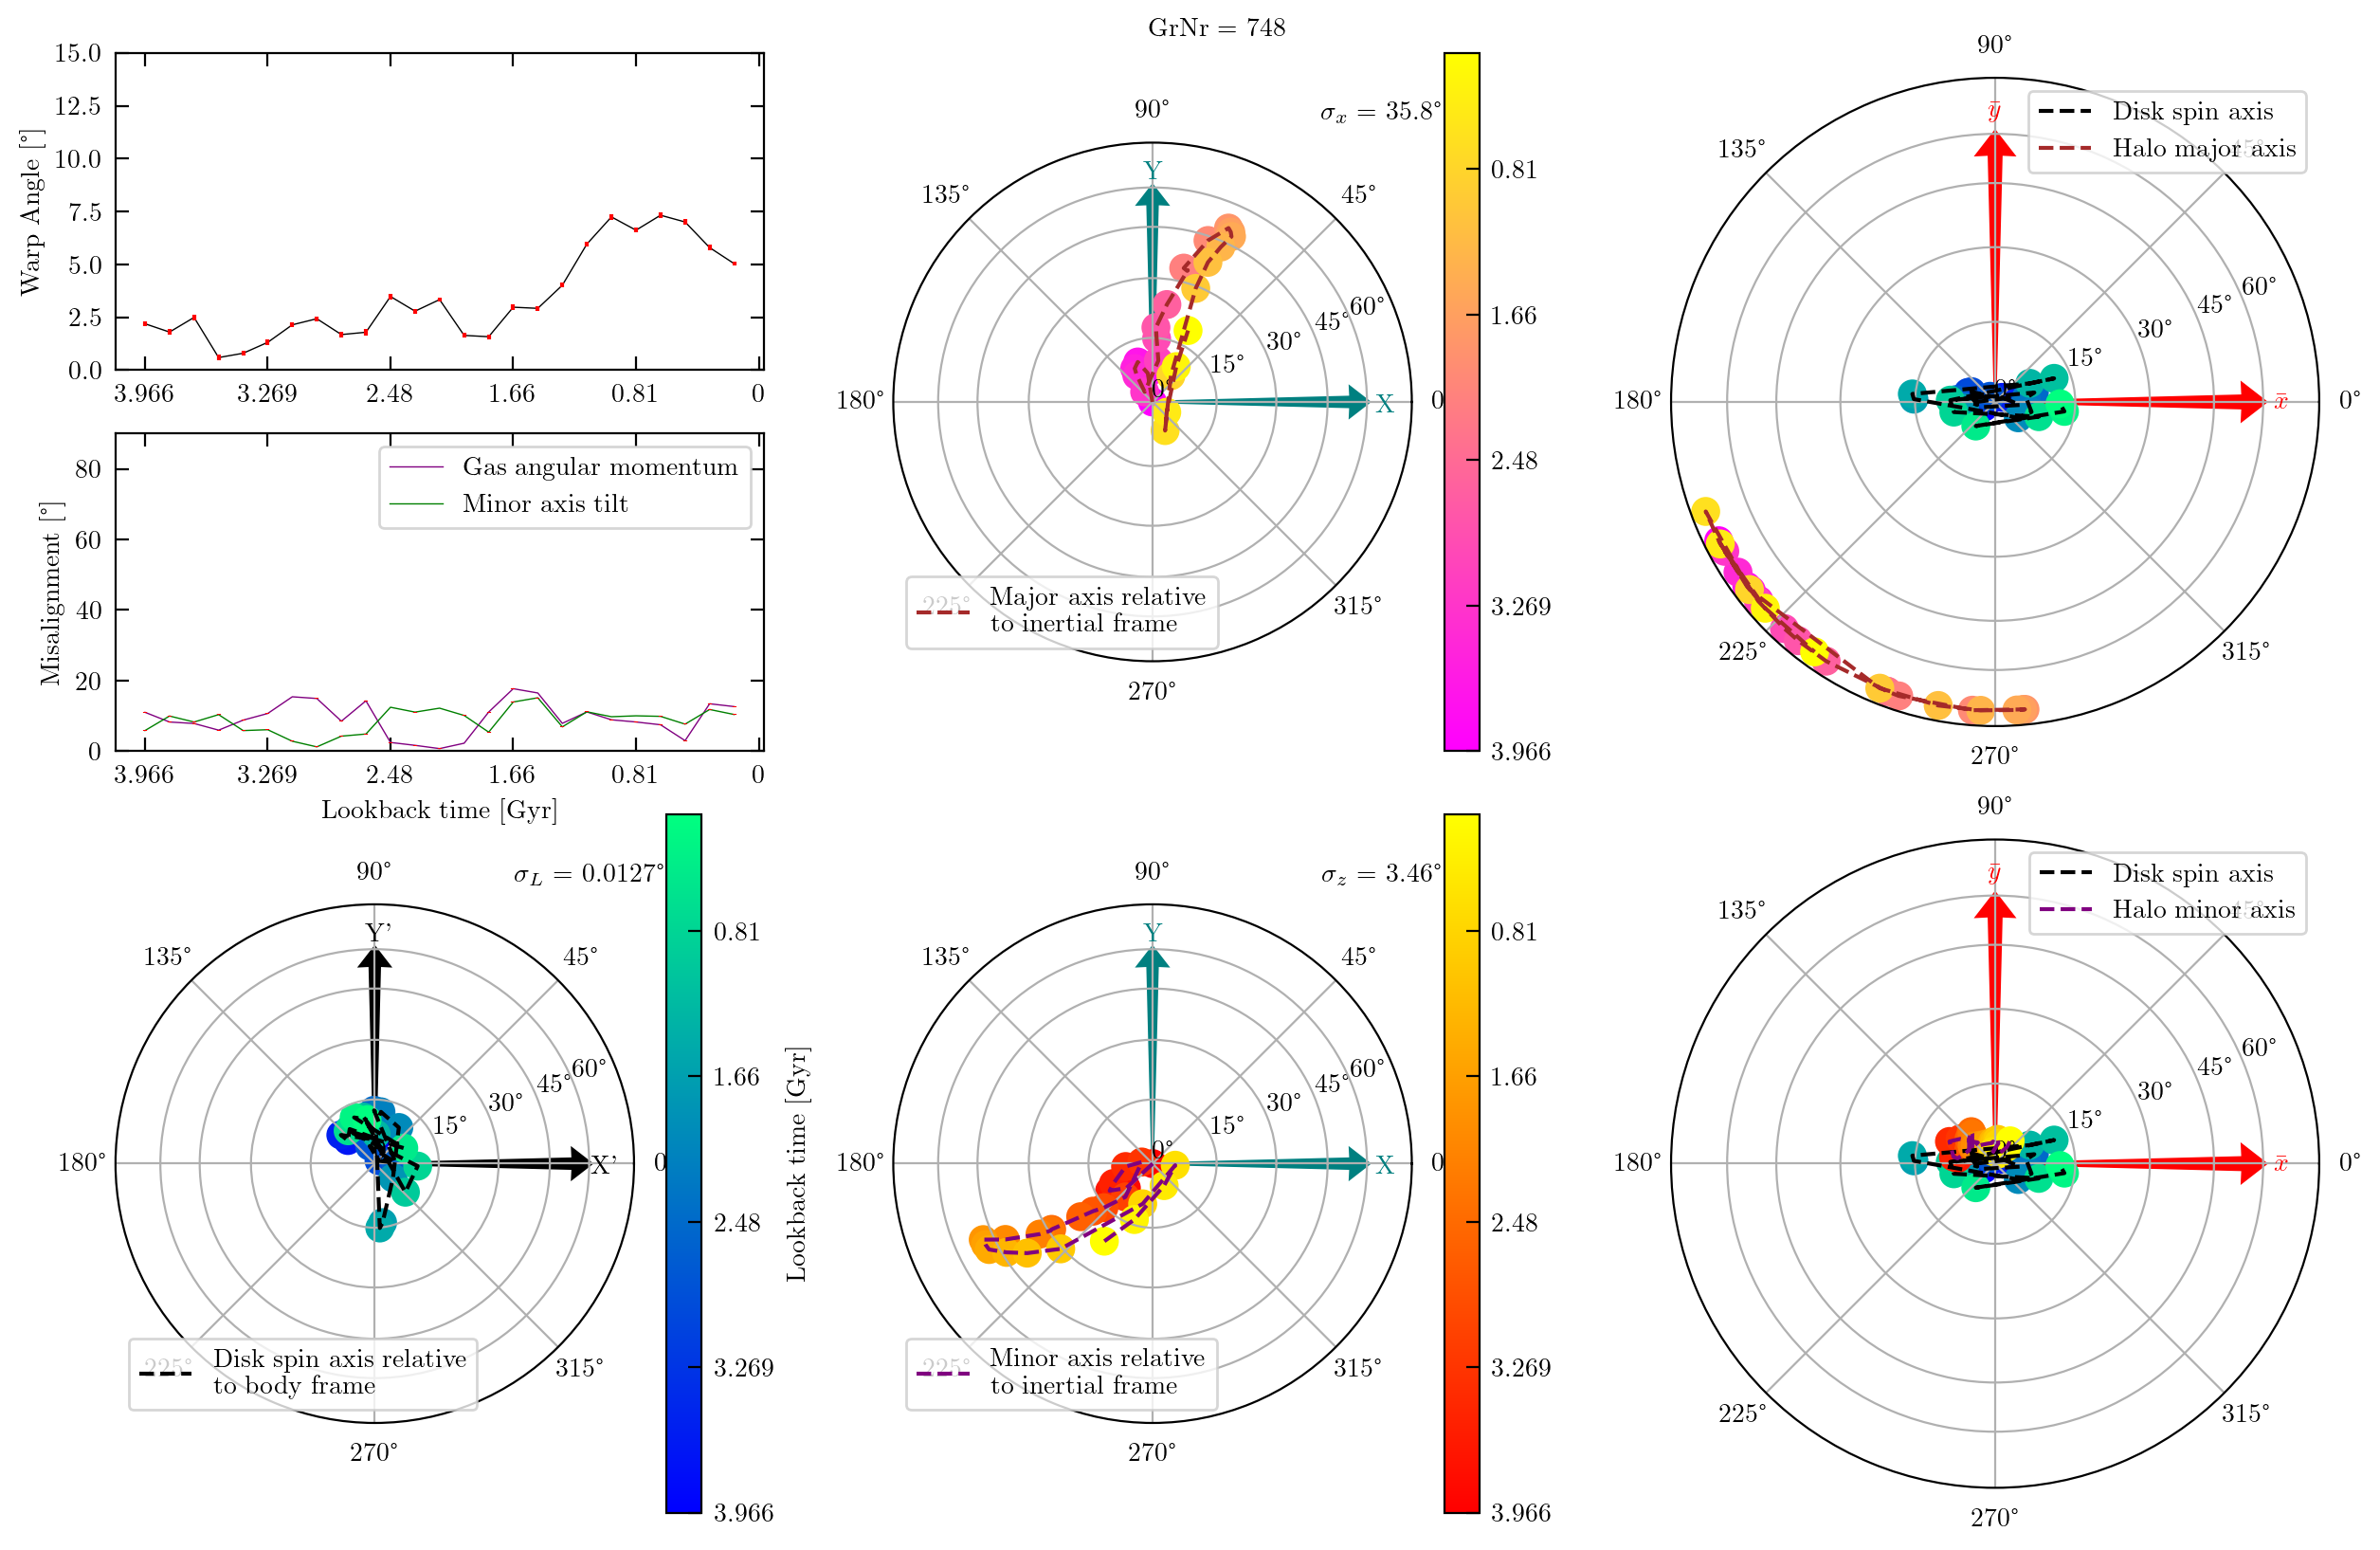

In [20]:
diskyidx = 5
fig = plt.figure(figsize=(15,10),frameon=True)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gs = gridspec.GridSpec(4,3)
plt.xticks([])
plt.yticks([])
GrNr = final_GrNr[diskyidx]
subfindID = final_diskyIDs[diskyidx]
rel_mag = warp_angles[diskyidx]
plt.title(f'GrNr = {GrNr}',fontsize = 10)

L_body_theta,L_body_phi = get_body_briggs(GrNr, subfindID, False)
x_body_theta,x_body_phi = get_x_briggs(GrNr, subfindID, False)
z_body_theta,z_body_phi = get_z_briggs(GrNr, subfindID, False)
L_theta_z,L_phi_z,z_theta_z,z_phi_z = get_minor_briggs(GrNr, subfindID, False)
L_theta_x,L_phi_x,z_theta_x,z_phi_x = get_major_briggs(GrNr, subfindID, False)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylim(0,15)
ax1.plot(snapshot_times, warp_angles[diskyidx], c='black', linewidth = 0.5)
ax1.errorbar(snapshot_times, warp_angles[diskyidx], yerr = warp_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax1.set_ylabel(r'Warp Angle [°]',fontsize = 10)
ax1.tick_params(labelsize=10)

ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
ax2.set_ylim(0,90)
ax2.plot(snapshot_times, gas_angles[diskyidx], c='purple', linewidth = 1/2,label='Gas angular momentum')
ax2.errorbar(snapshot_times, gas_angles[diskyidx], yerr = gas_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax2.plot(snapshot_times, z_angles[diskyidx], c='green', linewidth = 1/2,label='Minor axis tilt')
ax2.errorbar(snapshot_times, z_angles[diskyidx], yerr = z_angles_stds[diskyidx],fmt='none',ecolor='red') 

ax2.set_ylabel('Misalignment [°]',fontsize = 10)
ax2.legend(fontsize=10)
ax2.set_xlabel('Lookback time [Gyr]',fontsize = 10)
ax2.tick_params(labelsize=10)

ax4 = fig.add_subplot(gs[2:, 0],projection = 'polar')
ax4.plot(L_body_phi, np.sin(L_body_theta),c='black',linestyle = '--',label='Disk spin axis relative \n to body frame')
color_scatter = ax4.scatter(L_body_phi, np.sin(L_body_theta),c=np.arange(len(L_body_phi)),s=100,cmap='winter')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
cbar.set_label('Lookback time [Gyr]',fontsize = 10)
ax4.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax4.tick_params(labelsize=10)
ax4.set_rlim([0,np.pi/3])
ax4.legend(fontsize=10)
ax4.text(1.06, 1.08, f'$\sigma_L$ = {truncate(np.mean(np.array([disk_phi_stds[diskyidx],disk_theta_stds[diskyidx]])),4)}°', 
        transform=ax4.transAxes, va='top', ha='right',fontsize = 10)
ax4.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.annotate("Y'", c='black',xy=(np.pi/2-np.pi/192,0.9),ha='center',fontsize = 10)
ax4.annotate("X'", c='black',xy=(-np.pi/192,0.87),va='center',fontsize = 10)

ax5 = fig.add_subplot(gs[:2,1],projection='polar')
ax5.plot(x_body_phi, np.sin(x_body_theta),c='brown',linestyle = '--',markersize=1,label='Major axis relative \n to inertial frame')
color_scatter = ax5.scatter(x_body_phi, np.sin(x_body_theta),c=np.arange(len(x_body_phi)),s=100,cmap='spring')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
ax5.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax5.tick_params(labelsize=10)
ax5.set_rlim([0,np.pi/3])
ax5.legend(fontsize=10)
ax5.text(1.06, 1.08, f'$\sigma_x$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[0],1)}°', 
        transform=ax5.transAxes, va='top', ha='right',fontsize = 10)
ax5.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax5.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax6 = fig.add_subplot(gs[2:, 1],projection='polar')
ax6.plot(z_body_phi, np.sin(z_body_theta),c='purple',linestyle = '--',markersize=1,label='Minor axis relative \n to inertial frame')
color_scatter = ax6.scatter(z_body_phi, np.sin(z_body_theta),c=np.arange(len(z_body_phi)),s=100,cmap='autumn')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
ax6.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax6.tick_params(labelsize=10)
ax6.set_rlim([0,np.pi/3])
ax6.legend(fontsize=10)
ax6.text(1.06, 1.08, f'$\sigma_z$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[1],2)}°', 
        transform=ax6.transAxes, va='top', ha='right',fontsize = 10)
ax6.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax6.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax7 = fig.add_subplot(gs[2:,2],projection='polar')
ax7.plot(L_phi_z, np.sin(L_theta_z),c='black',linestyle = '--',label='Disk spin axis')
ax7.scatter(L_phi_z, np.sin(L_theta_z),c=np.arange(len(L_phi_z)),s=100,cmap='winter')
ax7.plot(z_phi_z, np.sin(z_theta_z),c='purple',linestyle = '--',markersize=1,label='Halo minor axis')
ax7.scatter(z_phi_z, np.sin(z_theta_z),c=np.arange(len(z_phi_z)),s=100,cmap='autumn')
ax7.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax7.tick_params(labelsize=10)
ax7.set_rlim([0,np.pi/3])
ax7.legend(fontsize=10)
ax7.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax7.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

ax8 = fig.add_subplot(gs[:2,2],projection='polar')
ax8.plot(L_phi_x, np.sin(L_theta_x),c='black',linestyle = '--',label='Disk spin axis')
ax8.scatter(L_phi_x, np.sin(L_theta_x),c=np.arange(len(L_phi_x)),s=100,cmap='winter')
ax8.plot(z_phi_x, np.sin(z_theta_x),c='brown',linestyle = '--',markersize=1,label='Halo major axis')
ax8.scatter(z_phi_x, np.sin(z_theta_x),c=np.arange(len(z_phi_x)),s=100,cmap='spring')
ax8.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax8.tick_params(labelsize=10)
ax8.set_rlim([0,np.pi/3])
ax8.legend(fontsize=10)
ax8.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax8.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

Text(0, 0.9, '$\\bar{x}$')

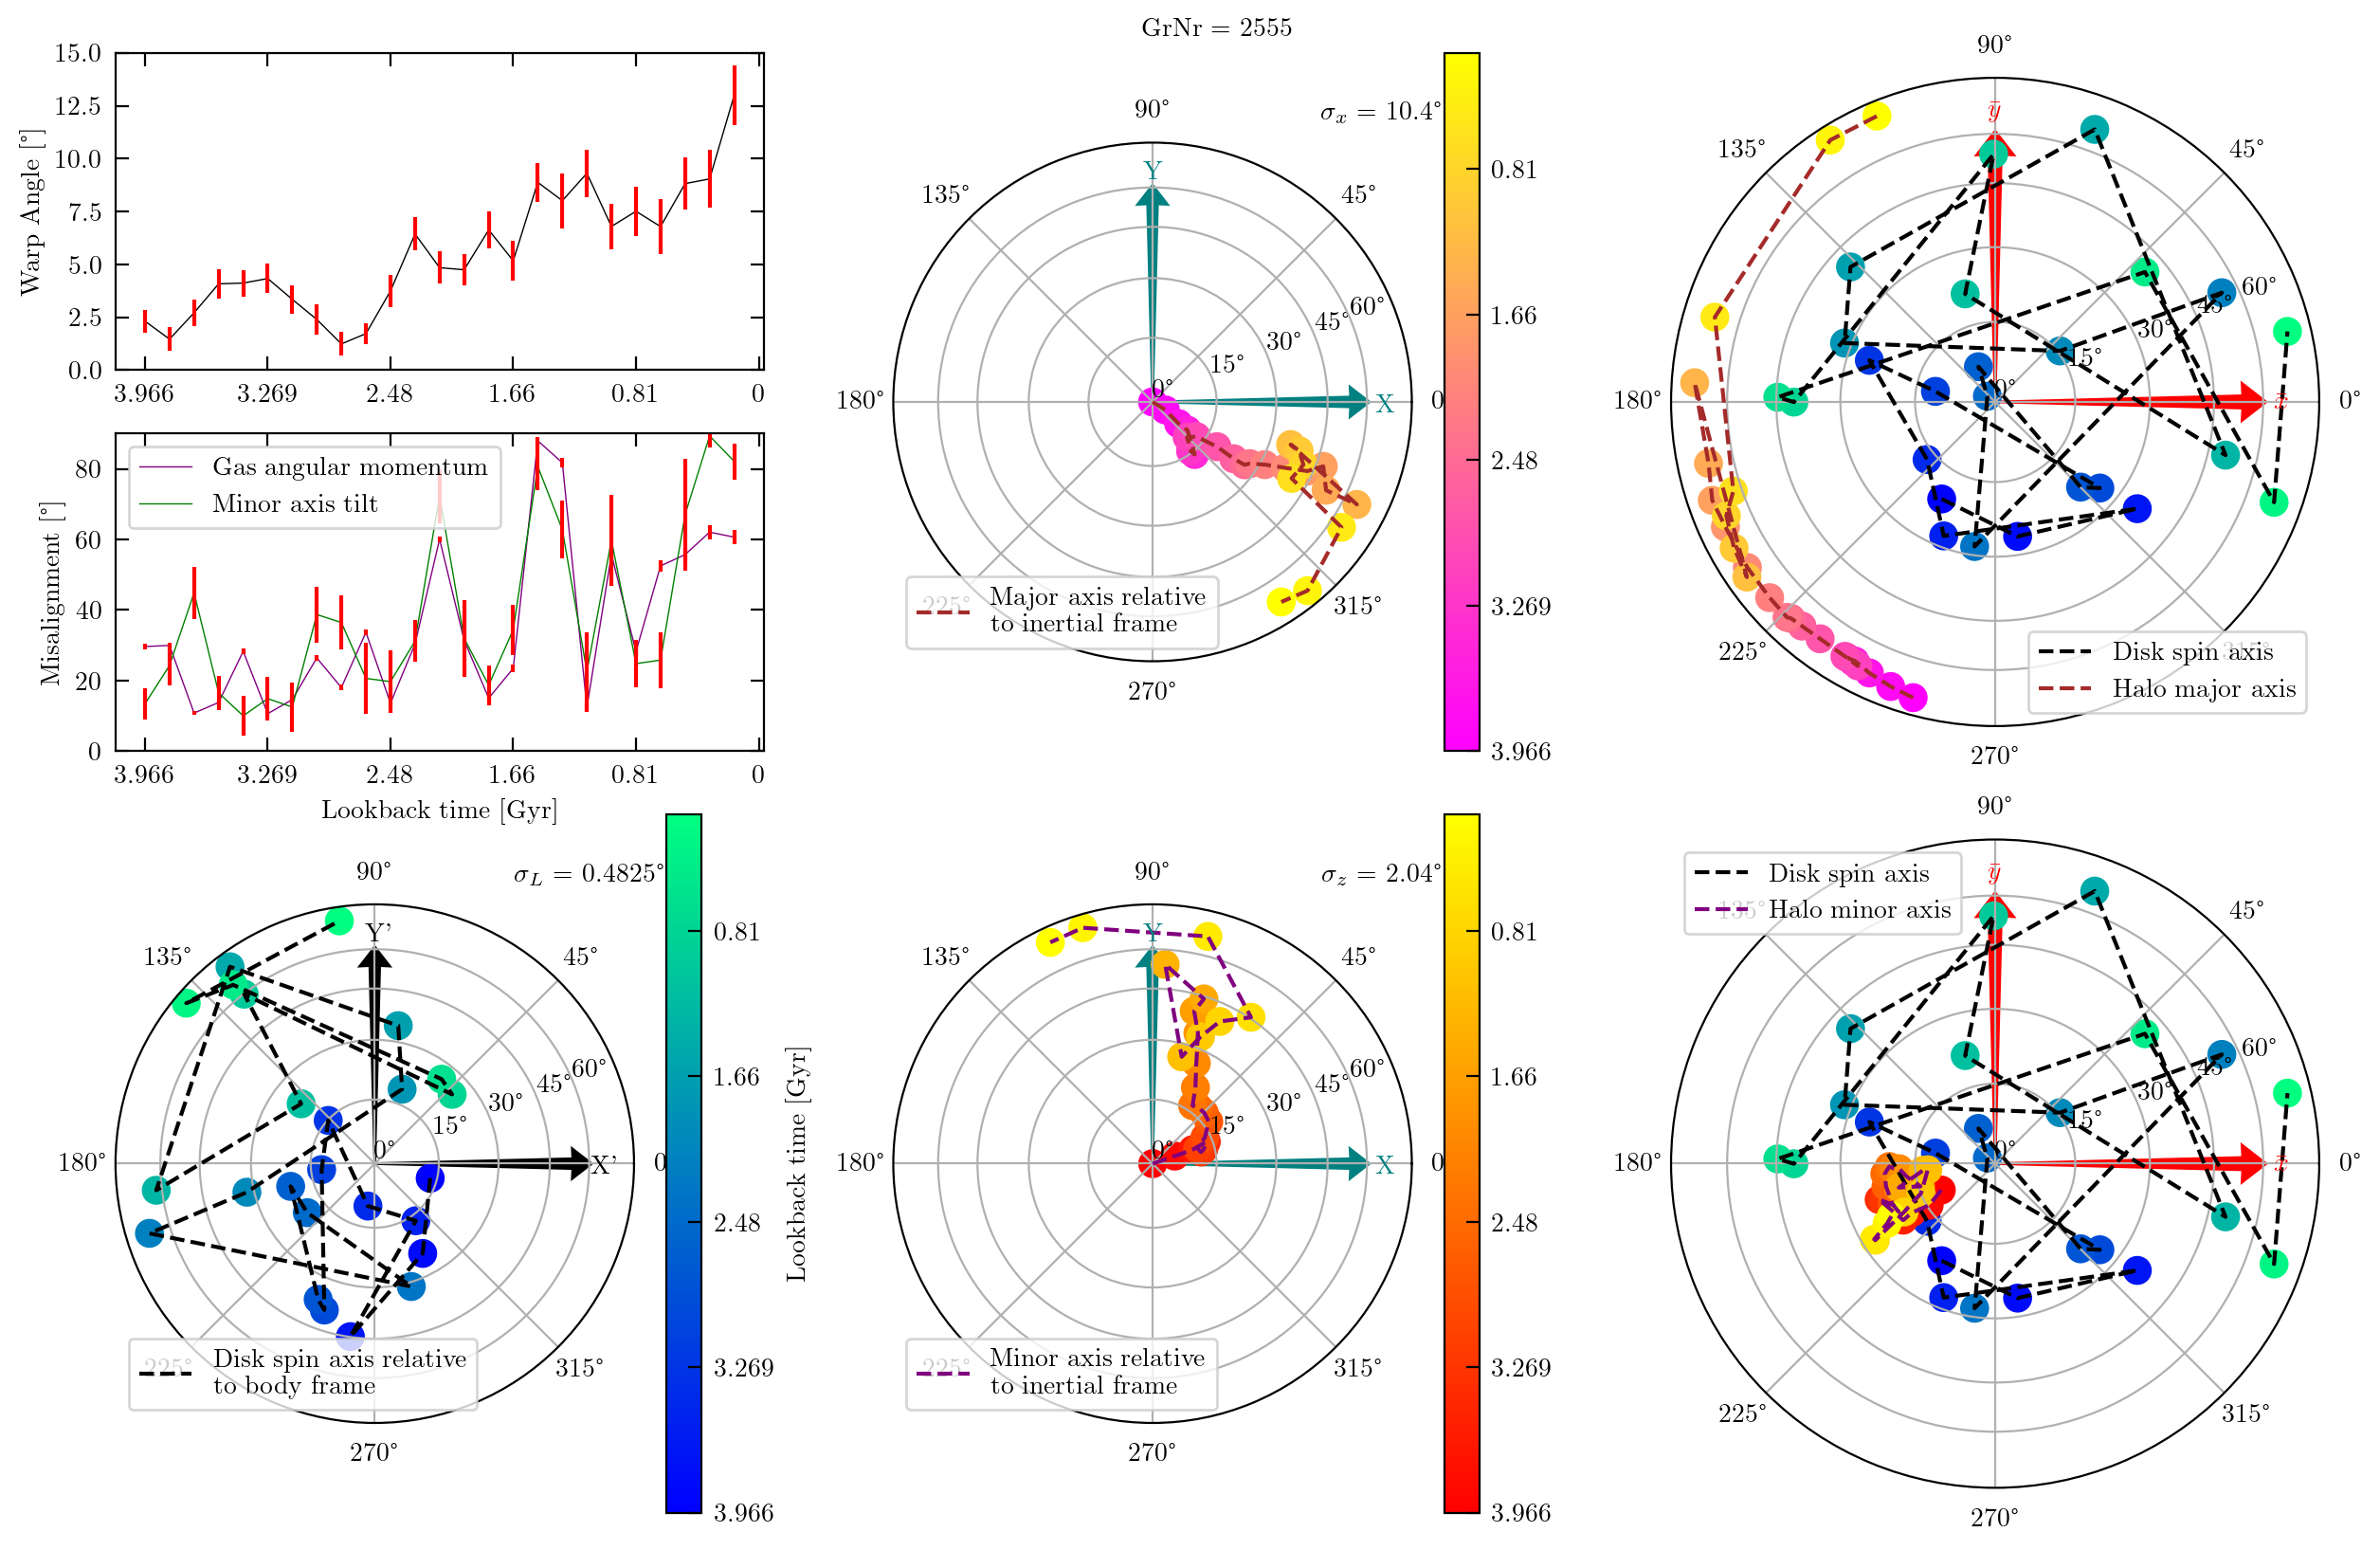

In [21]:
diskyidx = 36
fig = plt.figure(figsize=(15,10),frameon=True)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gs = gridspec.GridSpec(4,3)
plt.xticks([])
plt.yticks([])
GrNr = final_GrNr[diskyidx]
subfindID = final_diskyIDs[diskyidx]
rel_mag = warp_angles[diskyidx]
plt.title(f'GrNr = {GrNr}',fontsize = 10)

L_body_theta,L_body_phi = get_body_briggs(GrNr, subfindID, False)
x_body_theta,x_body_phi = get_x_briggs(GrNr, subfindID, False)
z_body_theta,z_body_phi = get_z_briggs(GrNr, subfindID, False)
L_theta_z,L_phi_z,z_theta_z,z_phi_z = get_minor_briggs(GrNr, subfindID, False)
L_theta_x,L_phi_x,z_theta_x,z_phi_x = get_major_briggs(GrNr, subfindID, False)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylim(0,15)
ax1.plot(snapshot_times, warp_angles[diskyidx], c='black', linewidth = 0.5)
ax1.errorbar(snapshot_times, warp_angles[diskyidx], yerr = warp_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax1.set_ylabel(r'Warp Angle [°]',fontsize = 10)
ax1.tick_params(labelsize=10)

ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
ax2.set_ylim(0,90)
ax2.plot(snapshot_times, gas_angles[diskyidx], c='purple', linewidth = 1/2,label='Gas angular momentum')
ax2.errorbar(snapshot_times, gas_angles[diskyidx], yerr = gas_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax2.plot(snapshot_times, z_angles[diskyidx], c='green', linewidth = 1/2,label='Minor axis tilt')
ax2.errorbar(snapshot_times, z_angles[diskyidx], yerr = z_angles_stds[diskyidx],fmt='none',ecolor='red') 

ax2.set_ylabel('Misalignment [°]',fontsize = 10)
ax2.legend(fontsize=10)
ax2.set_xlabel('Lookback time [Gyr]',fontsize = 10)
ax2.tick_params(labelsize=10)

ax4 = fig.add_subplot(gs[2:, 0],projection = 'polar')
ax4.plot(L_body_phi, np.sin(L_body_theta),c='black',linestyle = '--',label='Disk spin axis relative \n to body frame')
color_scatter = ax4.scatter(L_body_phi, np.sin(L_body_theta),c=np.arange(len(L_body_phi)),s=100,cmap='winter')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
cbar.set_label('Lookback time [Gyr]',fontsize = 10)
ax4.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax4.tick_params(labelsize=10)
ax4.set_rlim([0,np.pi/3])
ax4.legend(fontsize=10)
ax4.text(1.06, 1.08, f'$\sigma_L$ = {truncate(np.mean(np.array([disk_phi_stds[diskyidx],disk_theta_stds[diskyidx]])),4)}°', 
        transform=ax4.transAxes, va='top', ha='right',fontsize = 10)
ax4.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.annotate("Y'", c='black',xy=(np.pi/2-np.pi/192,0.9),ha='center',fontsize = 10)
ax4.annotate("X'", c='black',xy=(-np.pi/192,0.87),va='center',fontsize = 10)

ax5 = fig.add_subplot(gs[:2,1],projection='polar')
ax5.plot(x_body_phi, np.sin(x_body_theta),c='brown',linestyle = '--',markersize=1,label='Major axis relative \n to inertial frame')
color_scatter = ax5.scatter(x_body_phi, np.sin(x_body_theta),c=np.arange(len(x_body_phi)),s=100,cmap='spring')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
ax5.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax5.tick_params(labelsize=10)
ax5.set_rlim([0,np.pi/3])
ax5.legend(fontsize=10)
ax5.text(1.06, 1.08, f'$\sigma_x$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[0],1)}°', 
        transform=ax5.transAxes, va='top', ha='right',fontsize = 10)
ax5.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax5.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax6 = fig.add_subplot(gs[2:, 1],projection='polar')
ax6.plot(z_body_phi, np.sin(z_body_theta),c='purple',linestyle = '--',markersize=1,label='Minor axis relative \n to inertial frame')
color_scatter = ax6.scatter(z_body_phi, np.sin(z_body_theta),c=np.arange(len(z_body_phi)),s=100,cmap='autumn')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
ax6.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax6.tick_params(labelsize=10)
ax6.set_rlim([0,np.pi/3])
ax6.legend(fontsize=10)
ax6.text(1.06, 1.08, f'$\sigma_z$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[1],2)}°', 
        transform=ax6.transAxes, va='top', ha='right',fontsize = 10)
ax6.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax6.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax7 = fig.add_subplot(gs[2:,2],projection='polar')
ax7.plot(L_phi_z, np.sin(L_theta_z),c='black',linestyle = '--',label='Disk spin axis')
ax7.scatter(L_phi_z, np.sin(L_theta_z),c=np.arange(len(L_phi_z)),s=100,cmap='winter')
ax7.plot(z_phi_z, np.sin(z_theta_z),c='purple',linestyle = '--',markersize=1,label='Halo minor axis')
ax7.scatter(z_phi_z, np.sin(z_theta_z),c=np.arange(len(z_phi_z)),s=100,cmap='autumn')
ax7.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax7.tick_params(labelsize=10)
ax7.set_rlim([0,np.pi/3])
ax7.legend(fontsize=10)
ax7.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax7.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

ax8 = fig.add_subplot(gs[:2,2],projection='polar')
ax8.plot(L_phi_x, np.sin(L_theta_x),c='black',linestyle = '--',label='Disk spin axis')
ax8.scatter(L_phi_x, np.sin(L_theta_x),c=np.arange(len(L_phi_x)),s=100,cmap='winter')
ax8.plot(z_phi_x, np.sin(z_theta_x),c='brown',linestyle = '--',markersize=1,label='Halo major axis')
ax8.scatter(z_phi_x, np.sin(z_theta_x),c=np.arange(len(z_phi_x)),s=100,cmap='spring')
ax8.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax8.tick_params(labelsize=10)
ax8.set_rlim([0,np.pi/3])
ax8.legend(fontsize=10)
ax8.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax8.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

Text(0, 0.9, '$\\bar{x}$')

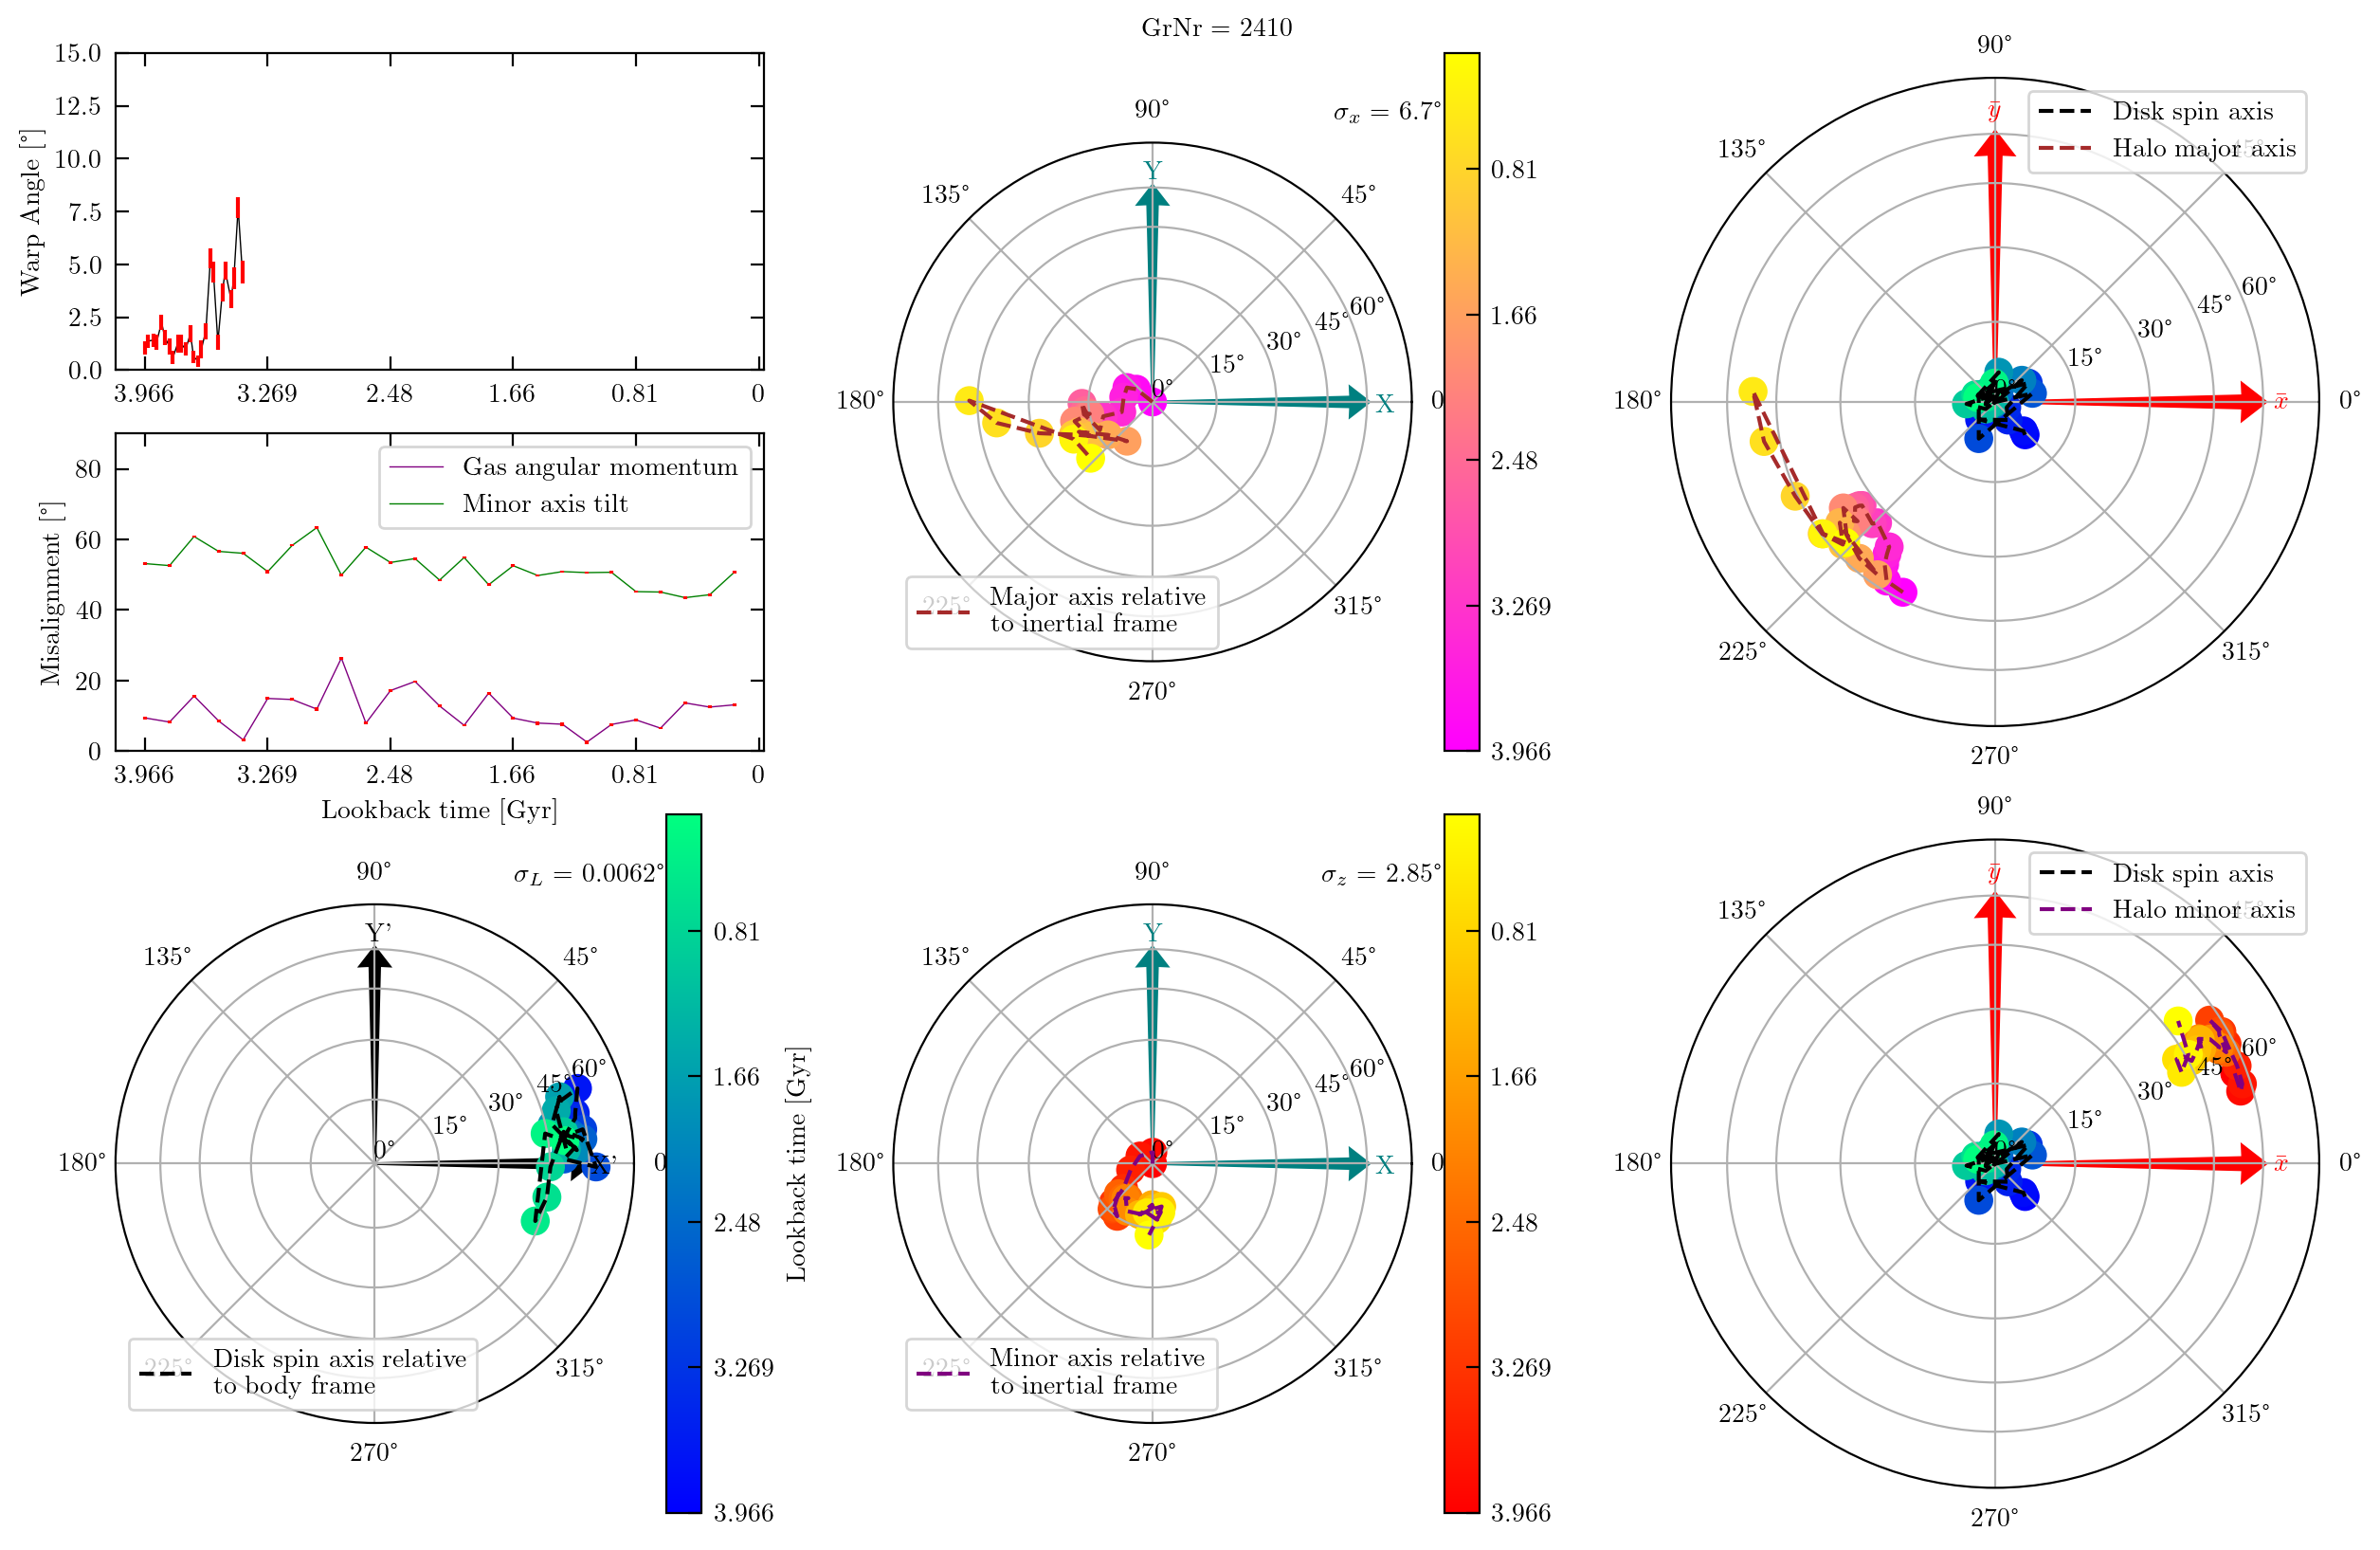

In [28]:
diskyidx = 34
fig = plt.figure(figsize=(15,10),frameon=True)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gs = gridspec.GridSpec(4,3)
plt.xticks([])
plt.yticks([])
GrNr = final_GrNr[diskyidx]
subfindID = final_diskyIDs[diskyidx]
rel_mag = warp_angles[diskyidx]
plt.title(f'GrNr = {GrNr}',fontsize = 10)

L_body_theta,L_body_phi = get_body_briggs(GrNr, subfindID, False)
x_body_theta,x_body_phi = get_x_briggs(GrNr, subfindID, False)
z_body_theta,z_body_phi = get_z_briggs(GrNr, subfindID, False)
L_theta_z,L_phi_z,z_theta_z,z_phi_z = get_minor_briggs(GrNr, subfindID, False)
L_theta_x,L_phi_x,z_theta_x,z_phi_x = get_major_briggs(GrNr, subfindID, False)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylim(0,15)
ax1.plot(snapshot_times, warp_angles[diskyidx], c='black', linewidth = 0.5)
ax1.errorbar(snapshot_times, warp_angles[diskyidx], yerr = warp_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax1.set_ylabel(r'Warp Angle [°]',fontsize = 10)
ax1.tick_params(labelsize=10)

ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
ax2.set_ylim(0,90)
ax2.plot(snapshot_times, gas_angles[diskyidx], c='purple', linewidth = 1/2,label='Gas angular momentum')
ax2.errorbar(snapshot_times, gas_angles[diskyidx], yerr = gas_angles_stds[diskyidx],fmt='none',ecolor='red') 
ax2.plot(snapshot_times, z_angles[diskyidx], c='green', linewidth = 1/2,label='Minor axis tilt')
ax2.errorbar(snapshot_times, z_angles[diskyidx], yerr = z_angles_stds[diskyidx],fmt='none',ecolor='red') 

ax2.set_ylabel('Misalignment [°]',fontsize = 10)
ax2.legend(fontsize=10)
ax2.set_xlabel('Lookback time [Gyr]',fontsize = 10)
ax2.tick_params(labelsize=10)

ax4 = fig.add_subplot(gs[2:, 0],projection = 'polar')
ax4.plot(L_body_phi, np.sin(L_body_theta),c='black',linestyle = '--',label='Disk spin axis relative \n to body frame')
color_scatter = ax4.scatter(L_body_phi, np.sin(L_body_theta),c=np.arange(len(L_body_phi)),s=100,cmap='winter')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
cbar.set_label('Lookback time [Gyr]',fontsize = 10)
ax4.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax4.tick_params(labelsize=10)
ax4.set_rlim([0,np.pi/3])
ax4.legend(fontsize=10)
ax4.text(1.06, 1.08, f'$\sigma_L$ = {truncate(np.mean(np.array([disk_phi_stds[diskyidx],disk_theta_stds[diskyidx]])),4)}°', 
        transform=ax4.transAxes, va='top', ha='right',fontsize = 10)
ax4.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='black', ec='black',zorder=0)
ax4.annotate("Y'", c='black',xy=(np.pi/2-np.pi/192,0.9),ha='center',fontsize = 10)
ax4.annotate("X'", c='black',xy=(-np.pi/192,0.87),va='center',fontsize = 10)

ax5 = fig.add_subplot(gs[:2,1],projection='polar')
ax5.plot(x_body_phi, np.sin(x_body_theta),c='brown',linestyle = '--',markersize=1,label='Major axis relative \n to inertial frame')
color_scatter = ax5.scatter(x_body_phi, np.sin(x_body_theta),c=np.arange(len(x_body_phi)),s=100,cmap='spring')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
ax5.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax5.tick_params(labelsize=10)
ax5.set_rlim([0,np.pi/3])
ax5.legend(fontsize=10)
ax5.text(1.06, 1.08, f'$\sigma_x$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[0],1)}°', 
        transform=ax5.transAxes, va='top', ha='right',fontsize = 10)
ax5.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax5.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax5.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax6 = fig.add_subplot(gs[2:, 1],projection='polar')
ax6.plot(z_body_phi, np.sin(z_body_theta),c='purple',linestyle = '--',markersize=1,label='Minor axis relative \n to inertial frame')
color_scatter = ax6.scatter(z_body_phi, np.sin(z_body_theta),c=np.arange(len(z_body_phi)),s=100,cmap='autumn')
cbar = plt.colorbar(color_scatter)
cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
ax6.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax6.tick_params(labelsize=10)
ax6.set_rlim([0,np.pi/3])
ax6.legend(fontsize=10)
ax6.text(1.06, 1.08, f'$\sigma_z$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[1],2)}°', 
        transform=ax6.transAxes, va='top', ha='right',fontsize = 10)
ax6.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
ax6.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
ax6.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

ax7 = fig.add_subplot(gs[2:,2],projection='polar')
ax7.plot(L_phi_z, np.sin(L_theta_z),c='black',linestyle = '--',label='Disk spin axis')
ax7.scatter(L_phi_z, np.sin(L_theta_z),c=np.arange(len(L_phi_z)),s=100,cmap='winter')
ax7.plot(z_phi_z, np.sin(z_theta_z),c='purple',linestyle = '--',markersize=1,label='Halo minor axis')
ax7.scatter(z_phi_z, np.sin(z_theta_z),c=np.arange(len(z_phi_z)),s=100,cmap='autumn')
ax7.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax7.tick_params(labelsize=10)
ax7.set_rlim([0,np.pi/3])
ax7.legend(fontsize=10)
ax7.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax7.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax7.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

ax8 = fig.add_subplot(gs[:2,2],projection='polar')
ax8.plot(L_phi_x, np.sin(L_theta_x),c='black',linestyle = '--',label='Disk spin axis')
ax8.scatter(L_phi_x, np.sin(L_theta_x),c=np.arange(len(L_phi_x)),s=100,cmap='winter')
ax8.plot(z_phi_x, np.sin(z_theta_x),c='brown',linestyle = '--',markersize=1,label='Halo major axis')
ax8.scatter(z_phi_x, np.sin(z_theta_x),c=np.arange(len(z_phi_x)),s=100,cmap='spring')
ax8.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
ax8.tick_params(labelsize=10)
ax8.set_rlim([0,np.pi/3])
ax8.legend(fontsize=10)
ax8.arrow(np.pi/2, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.arrow(0, 0, 0, 0.8, 
         width=0.05, head_width=3*0.05, 
         head_length=1.5*0.05, fc='red', ec='red',zorder=0)
ax8.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
ax8.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

In [ ]:
for diskyidx in tqdm(range(34,39)):
    plt.figure()
    plt.plot(snapshot_times,gas_angles[diskyidx])
    plt.ylim(0,90)
    
    fig = plt.figure(figsize=(15,10),frameon=True)
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    gs = gridspec.GridSpec(4,3)
    plt.xticks([])
    plt.yticks([])
    GrNr = final_GrNr[diskyidx]
    subfindID = final_diskyIDs[diskyidx]
    rel_mag = warp_angles[diskyidx]
    plt.title(f'GrNr = {GrNr}',fontsize = 10)

    L_body_theta,L_body_phi = get_body_briggs(GrNr, subfindID, False)
    x_body_theta,x_body_phi = get_x_briggs(GrNr, subfindID, False)
    z_body_theta,z_body_phi = get_z_briggs(GrNr, subfindID, False)
    L_theta_z,L_phi_z,z_theta_z,z_phi_z = get_minor_briggs(GrNr, subfindID, False)
    L_theta_x,L_phi_x,z_theta_x,z_phi_x = get_major_briggs(GrNr, subfindID, False)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_ylim(0,15)
    ax1.plot(snapshot_times, warp_angles[diskyidx], c='black', linewidth = 0.5)
    ax1.errorbar(snapshot_times, warp_angles[diskyidx], yerr = warp_angles_stds[diskyidx],fmt='none',ecolor='red') 
    ax1.set_ylabel(r'Warp Angle [°]',fontsize = 10)
    ax1.tick_params(labelsize=10)

    ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
    ax2.set_ylim(0,90)
    ax2.plot(snapshot_times, gas_angles[diskyidx], c='purple', linewidth = 1/2,label='Gas angular momentum')
    ax2.errorbar(snapshot_times, gas_angles[diskyidx], yerr = gas_angles_stds[diskyidx],fmt='none',ecolor='red') 
    ax2.plot(snapshot_times, z_angles[diskyidx], c='green', linewidth = 1/2,label='Minor axis tilt')
    ax2.errorbar(snapshot_times, z_angles[diskyidx], yerr = z_angles_stds[diskyidx],fmt='none',ecolor='red') 
    
    ax2.set_ylabel('Misalignment [°]',fontsize = 10)
    ax2.legend(fontsize=10)
    ax2.set_xlabel('Lookback time [Gyr]',fontsize = 10)
    ax2.tick_params(labelsize=10)

    ax4 = fig.add_subplot(gs[2:, 0],projection = 'polar')
    ax4.plot(L_body_phi, np.sin(L_body_theta),c='black',linestyle = '--',label='Disk spin axis relative \n to body frame')
    color_scatter = ax4.scatter(L_body_phi, np.sin(L_body_theta),c=np.arange(len(L_body_phi)),s=100,cmap='winter')
    cbar = plt.colorbar(color_scatter)
    cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
    cbar.set_label('Lookback time [Gyr]',fontsize = 10)
    ax4.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
    ax4.tick_params(labelsize=10)
    ax4.set_rlim([0,np.pi/3])
    ax4.legend(fontsize=10)
    ax4.text(1.06, 1.08, f'$\sigma_L$ = {truncate(np.mean(np.array([disk_phi_stds[diskyidx],disk_theta_stds[diskyidx]])),4)}°', 
            transform=ax4.transAxes, va='top', ha='right',fontsize = 10)
    ax4.arrow(np.pi/2, 0, 0, 0.8, 
             width=0.05, head_width=3*0.05, 
             head_length=1.5*0.05, fc='black', ec='black',zorder=0)
    ax4.arrow(0, 0, 0, 0.8, 
             width=0.05, head_width=3*0.05, 
             head_length=1.5*0.05, fc='black', ec='black',zorder=0)
    ax4.annotate("Y'", c='black',xy=(np.pi/2-np.pi/192,0.9),ha='center',fontsize = 10)
    ax4.annotate("X'", c='black',xy=(-np.pi/192,0.87),va='center',fontsize = 10)

    ax5 = fig.add_subplot(gs[:2,1],projection='polar')
    ax5.plot(x_body_phi, np.sin(x_body_theta),c='brown',linestyle = '--',markersize=1,label='Major axis relative \n to inertial frame')
    color_scatter = ax5.scatter(x_body_phi, np.sin(x_body_theta),c=np.arange(len(x_body_phi)),s=100,cmap='spring')
    cbar = plt.colorbar(color_scatter)
    cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
    ax5.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
    ax5.tick_params(labelsize=10)
    ax5.set_rlim([0,np.pi/3])
    ax5.legend(fontsize=10)
    ax5.text(1.06, 1.08, f'$\sigma_x$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[0],1)}°', 
            transform=ax5.transAxes, va='top', ha='right',fontsize = 10)
    ax5.arrow(np.pi/2, 0, 0, 0.8, 
             width=0.05, head_width=3*0.05, 
             head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
    ax5.arrow(0, 0, 0, 0.8, 
             width=0.05, head_width=3*0.05, 
             head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
    ax5.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
    ax5.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

    ax6 = fig.add_subplot(gs[2:, 1],projection='polar')
    ax6.plot(z_body_phi, np.sin(z_body_theta),c='purple',linestyle = '--',markersize=1,label='Minor axis relative \n to inertial frame')
    color_scatter = ax6.scatter(z_body_phi, np.sin(z_body_theta),c=np.arange(len(z_body_phi)),s=100,cmap='autumn')
    cbar = plt.colorbar(color_scatter)
    cbar.set_ticklabels(colorbar_lookback,fontsize = 10)
    ax6.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
    ax6.tick_params(labelsize=10)
    ax6.set_rlim([0,np.pi/3])
    ax6.legend(fontsize=10)
    ax6.text(1.06, 1.08, f'$\sigma_z$ = {truncate(np.mean(get_axes_error(N[diskyidx], c_a[diskyidx], b_a[diskyidx]),1)[1],2)}°', 
            transform=ax6.transAxes, va='top', ha='right',fontsize = 10)
    ax6.arrow(np.pi/2, 0, 0, 0.8, 
             width=0.05, head_width=3*0.05, 
             head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
    ax6.arrow(0, 0, 0, 0.8, 
             width=0.05, head_width=3*0.05, 
             head_length=1.5*0.05, fc='teal', ec='teal',zorder=0)
    ax6.annotate("Y", c='teal',xy=(np.pi/2,0.9),ha='center',fontsize = 10)
    ax6.annotate("X", c='teal',xy=(-np.pi/192,0.9),va='center',fontsize = 10)

    ax7 = fig.add_subplot(gs[2:,2],projection='polar')
    ax7.plot(L_phi_z, np.sin(L_theta_z),c='black',linestyle = '--',label='Disk spin axis')
    ax7.scatter(L_phi_z, np.sin(L_theta_z),c=np.arange(len(L_phi_z)),s=100,cmap='winter')
    ax7.plot(z_phi_z, np.sin(z_theta_z),c='purple',linestyle = '--',markersize=1,label='Halo minor axis')
    ax7.scatter(z_phi_z, np.sin(z_theta_z),c=np.arange(len(z_phi_z)),s=100,cmap='autumn')
    ax7.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
    ax7.tick_params(labelsize=10)
    ax7.set_rlim([0,np.pi/3])
    ax7.legend(fontsize=10)
    ax7.arrow(np.pi/2, 0, 0, 0.8, 
             width=0.05, head_width=3*0.05, 
             head_length=1.5*0.05, fc='red', ec='red',zorder=0)
    ax7.arrow(0, 0, 0, 0.8, 
             width=0.05, head_width=3*0.05, 
             head_length=1.5*0.05, fc='red', ec='red',zorder=0)
    ax7.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
    ax7.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

    ax8 = fig.add_subplot(gs[:2,2],projection='polar')
    ax8.plot(L_phi_x, np.sin(L_theta_x),c='black',linestyle = '--',label='Disk spin axis')
    ax8.scatter(L_phi_x, np.sin(L_theta_x),c=np.arange(len(L_phi_x)),s=100,cmap='winter')
    ax8.plot(z_phi_x, np.sin(z_theta_x),c='brown',linestyle = '--',markersize=1,label='Halo major axis')
    ax8.scatter(z_phi_x, np.sin(z_theta_x),c=np.arange(len(z_phi_x)),s=100,cmap='spring')
    ax8.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'],fontsize = 10)
    ax8.tick_params(labelsize=10)
    ax8.set_rlim([0,np.pi/3])
    ax8.legend(fontsize=10)
    ax8.arrow(np.pi/2, 0, 0, 0.8, 
             width=0.05, head_width=3*0.05, 
             head_length=1.5*0.05, fc='red', ec='red',zorder=0)
    ax8.arrow(0, 0, 0, 0.8, 
             width=0.05, head_width=3*0.05, 
             head_length=1.5*0.05, fc='red', ec='red',zorder=0)
    ax8.annotate(r'$\bar{y}$', c='r',xy=(np.pi/2,0.92),ha='center',fontsize = 10)
    ax8.annotate(r'$\bar{x}$',c='r',xy=(0,0.9),va='center',fontsize = 10)

## Mass range check

Just a quick check to show at what mass range we need to exclude the last 4 galaxies in our sample because they're far too small for the warp measurement to work

100%|██████████| 40/40 [02:37<00:00,  3.95s/it]


Text(0, 0.5, 'Snap 75 Galaxy stellar mass ($M_{sol}/h$)')

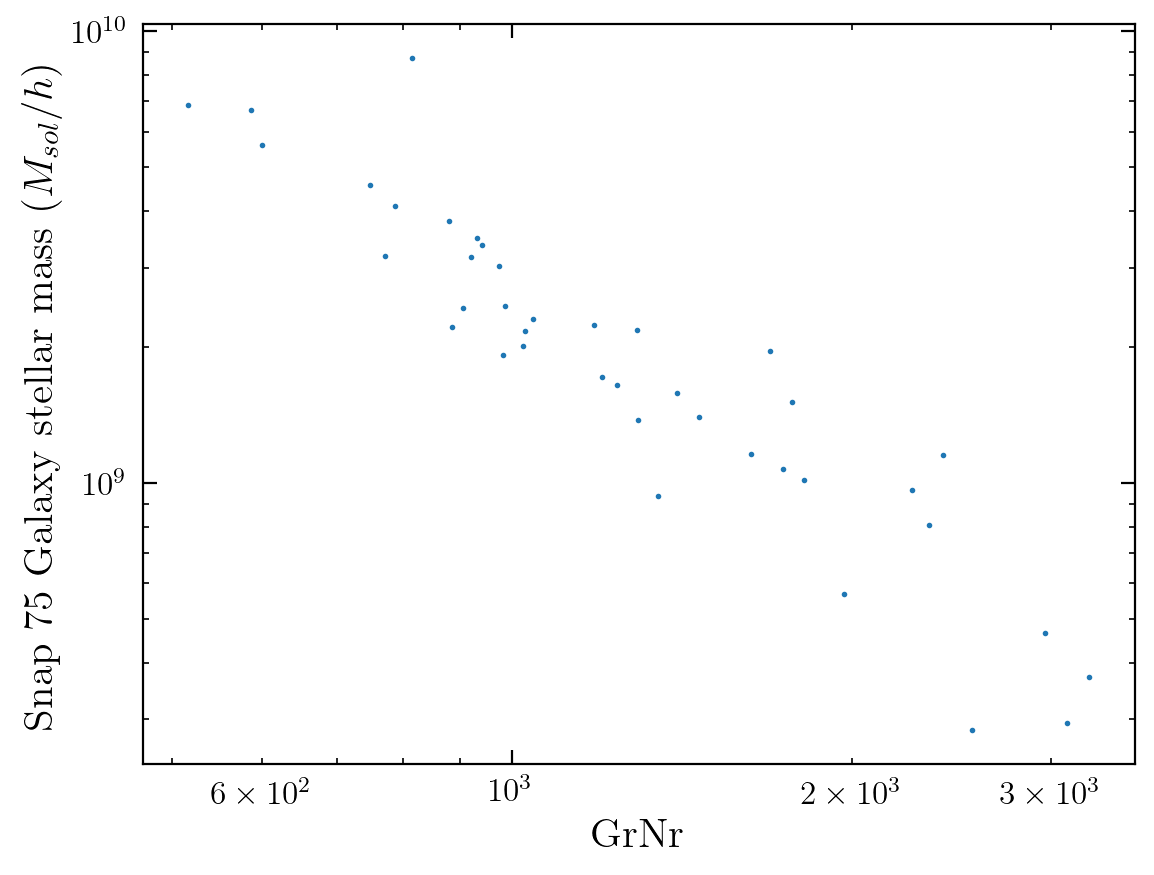

In [52]:
tot_galaxy_masses = []
for subfindID in tqdm(final_diskyIDs):
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)
    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                     fields=['SubhaloGrNr','SnapNum','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'], 
                                     onlyMPB=True)

    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']

    snap = 75
    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 

    particleCoords_bar  = starPos
    particleMass_bar    = starMass * 1e10 #M_sol

    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a
    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    indsInBounds = np.where((r_bar>0)&(r_bar<=2*halfmassrad_i))[0]
    massInGalaxy = particleMass_bar[indsInBounds]
    tot_galaxy_masses.append(np.sum(massInGalaxy))
    
plt.scatter(final_GrNr,tot_galaxy_masses,s=1)
plt.loglog()
plt.xlabel('GrNr')
plt.ylabel('Snap 75 Galaxy stellar mass ($M_{sol}/h$)')

100%|██████████| 40/40 [02:17<00:00,  3.45s/it]


Text(0, 0.5, 'Snap 99 Galaxy stellar mass ($M_{sol}/h$)')

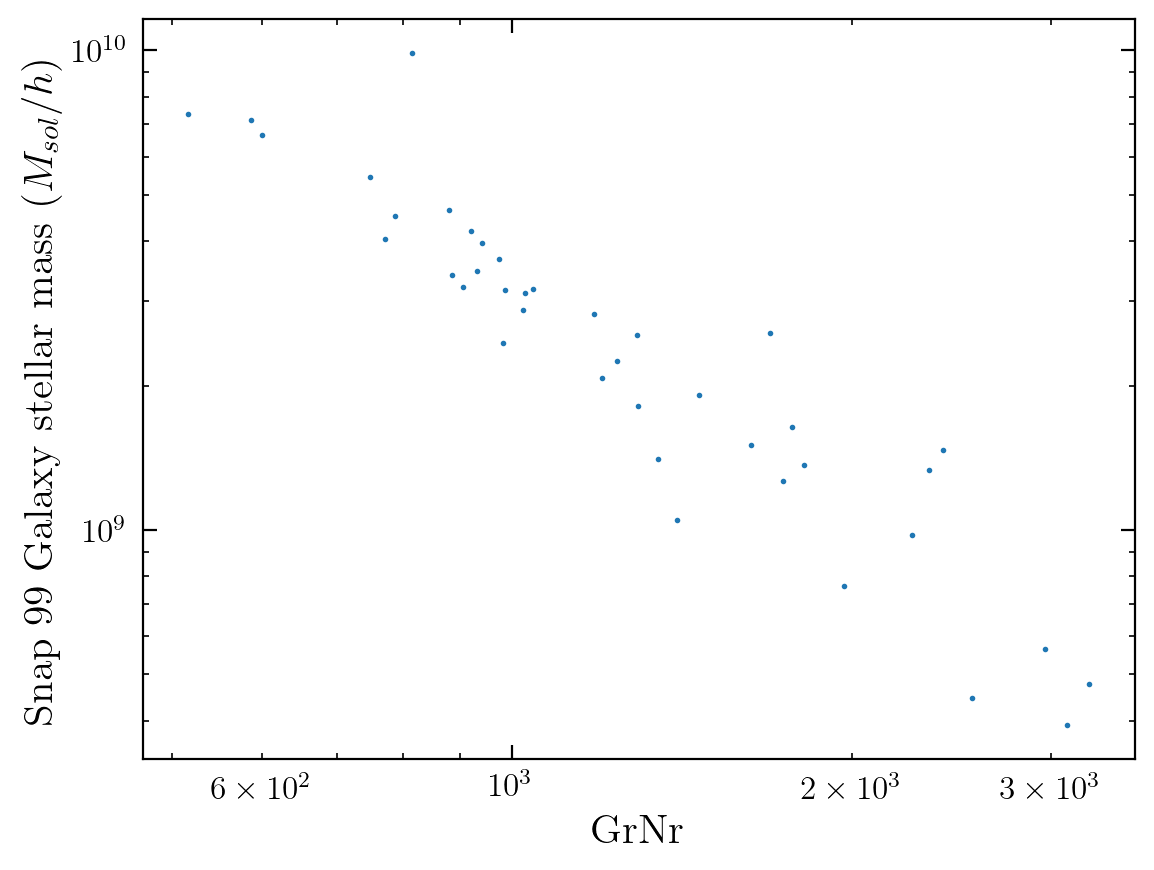

In [53]:
tot_galaxy_masses = []
for subfindID in tqdm(final_diskyIDs):
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)
    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                     fields=['SubhaloGrNr','SnapNum','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'], 
                                     onlyMPB=True)

    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']

    snap = 99
    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 

    particleCoords_bar  = starPos
    particleMass_bar    = starMass * 1e10 #M_sol

    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a
    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    indsInBounds = np.where((r_bar>0)&(r_bar<=2*halfmassrad_i))[0]
    massInGalaxy = particleMass_bar[indsInBounds]
    tot_galaxy_masses.append(np.sum(massInGalaxy))
    
plt.scatter(final_GrNr,tot_galaxy_masses,s=1)
plt.loglog()
plt.xlabel('GrNr')
plt.ylabel('Snap 99 Galaxy stellar mass ($M_{sol}/h$)')